<a href="https://colab.research.google.com/github/markoo26/thehappymountain/blob/main/Reinforcement_Learning_for_Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title 🚚 Cleaned Imports
from scipy import stats
import numpy as np
from numpy.random import default_rng
from collections import Counter
import os
import random
import warnings
import numpy as np
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from collections import deque
from keras.layers import Dense
from keras.models import Sequential
# from tensorflow.python.framework.ops import disable_eager_execution
import plotly.express as px
import pandas as pd
import math
rng = default_rng(seed=100)
from sklearn.preprocessing import StandardScaler
from pylab import plt, mpl
from tensorflow.keras.optimizers import Adam
tf.config.run_functions_eagerly(True)



In [2]:
#@title 🌱 Random seed setup

random.seed(100)
np.random.seed(100)
tf.random.set_seed(100)

In [3]:
#@title 🗄️ File setup `dql_agent.py`

%%writefile dqlagent.py

import os
import random
import warnings
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
from keras.layers import Dense, Flatten
from keras.models import Sequential

warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()

opt = keras.optimizers.Adam


class DQLAgent:
    def __init__(self, symbol, feature, n_features, env, hu=24, lr=0.001):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.gamma = 0.5
        self.trewards = list()
        self.max_treward = -np.inf
        self.n_features = n_features
        self.env = env
        self.episodes = 0
        self._create_model(hu, lr)

    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, activation='relu',
                             input_dim=self.n_features))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse', optimizer=opt(learning_rate=lr))

    def _reshape(self, state):
        state = state.flatten()
        return np.reshape(state, [1, len(state)])

    def act(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state)[0])
                target = self.model.predict(state)
                target[0, action] = reward
                self.model.fit(state, target, epochs=1, verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def learn(self, episodes):
        for e in range(1, episodes + 1):
            self.episodes += 1
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for f in range(1, 5000):
                self.f = f
                action = self.act(state)
                next_state, reward, done, trunc, _ = self.env.step(action)
                treward += reward
                next_state = self._reshape(next_state)
                self.memory.append(
                    [state, action, next_state, reward, done])
                state = next_state
                if done:
                    self.trewards.append(treward)
                    self.max_treward = max(self.max_treward, treward)
                    templ = f'episode={self.episodes:4d} | '
                    templ += f'treward={treward:7.3f}'
                    templ += f' | max={self.max_treward:7.3f}'
                    print(templ, end='\r')
                    break
            if len(self.memory) > self.batch_size:
                self.replay()
        print()

    def test(self, episodes, min_accuracy=0.0,
             min_performance=0.0, verbose=True,
             full=True):
        ma = self.env.min_accuracy
        self.env.min_accuracy = min_accuracy
        if hasattr(self.env, 'min_performance'):
            mp = self.env.min_performance
            self.env.min_performance = min_performance
            self.performances = list()
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            for f in range(1, 5001):
                action = np.argmax(self.model.predict(state)[0])
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                if done:
                    templ = f'total reward={f:4d} | '
                    templ += f'accuracy={self.env.accuracy:.3f}'
                    if hasattr(self.env, 'min_performance'):
                        self.performances.append(self.env.performance)
                        templ += f' | performance={self.env.performance:.3f}'
                    if verbose:
                        if full:
                            print(templ)
                        else:
                            print(templ, end='\r')
                    break
        self.env.min_accuracy = ma
        if hasattr(self.env, 'min_performance'):
            self.env.min_performance = mp
        print()



Writing dqlagent.py


In [4]:
#@title 💰 File setup finance.py

%%writefile finance.py


import random
import numpy as np
import pandas as pd


class ActionSpace:
    def sample(self):
        return random.randint(0, 1)


class Finance:
    url = 'https://certificate.tpq.io/rl4finance.csv'
    def __init__(self, symbol, feature, min_accuracy=0.485, n_features=4):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.action_space = ActionSpace()
        self.min_accuracy = min_accuracy
        self._get_data()
        self._prepare_data()

    def _get_data(self):
        self.raw = pd.read_csv(self.url,
                index_col=0, parse_dates=True)

    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol]).dropna()
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data.dropna(inplace=True)
        self.data_ = (self.data - self.data.mean()) / self.data.std()

    def reset(self):
        self.bar = self.n_features
        self.treward = 0
        state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return state, {}

    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy) and (self.bar > 15):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}


Writing finance.py


In [5]:
#@title 🎰 File setup simulation.py

%%writefile simulation.py


import math
import random
import numpy as np
import pandas as pd
from numpy.random import default_rng

rng = default_rng()


class ActionSpace:
    def sample(self):
        return random.randint(0, 1)


class Simulation:
    def __init__(self, symbol, feature, n_features,
                 start, end, periods,
                 min_accuracy=0.525, x0=100,
                 kappa=1, theta=100, sigma=0.2,
                 normalize=True, new=False):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.start = start
        self.end = end
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.min_accuracy = min_accuracy
        self.normalize = normalize
        self.new = new
        self.action_space = ActionSpace()
        self._simulate_data()
        self._prepare_data()

    def _simulate_data(self):
        index = pd.date_range(start=self.start,
                    end=self.end, periods=self.periods)
        s = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / self.periods
        for t in range(1, len(index)):
            s_ = (s[t - 1] + self.kappa * (self.theta - s[t - 1]) * dt +
                  s[t - 1] * self.sigma * math.sqrt(dt) * random.gauss(0, 1))
            s.append(s_)

        self.data = pd.DataFrame(s, columns=[self.symbol], index=index)

    def _prepare_data(self):
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        if self.normalize:
            self.mu = self.data.mean()
            self.std = self.data.std()
            self.data_ = (self.data - self.mu) / self.std
        else:
            self.data_ = self.data.copy()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data['d'] = self.data['d'].astype(int)

    def _get_state(self):
        return self.data_[self.feature].iloc[self.bar -
                                self.n_features:self.bar]

    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_random_seed(seed)

    def reset(self):
        if self.new:
            self._simulate_data()
            self._prepare_data()
        self.treward = 0
        self.accuracy = 0
        self.bar = self.n_features
        state = self._get_state()
        return state.values, {}

    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.n_features + 15):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}



Writing simulation.py


In [6]:
#@title 🏛️ File setup BSM73.py

%%writefile bsm73.py
# Valuation of European call options
# in Black-Scholes-Merton (1973) model
#
# (c) Dr. Yves J. Hilpisch
# Reinforcement Learning for Finance
#

from math import log, sqrt, exp
from scipy import stats


def bsm_call_value(St, K, T, t, r, sigma):
    ''' Valuation of European call option in BSM model.
    Analytical formula.

    Parameters
    ==========
    St: float
        stock/index level at date/time t
    K: float
        fixed strike price
    T: float
        maturity date/time (in year fractions)
    t: float
        current data/time
    r: float
        constant risk-free short rate
    sigma: float
        volatility factor in diffusion term

    Returns
    =======
    value: float
        present value of the European call option
    '''
    St = float(St)
    d1 = (log(St / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * sqrt(T - t))
    d2 = (log(St / K) + (r - 0.5 * sigma ** 2) * (T - t)) / (sigma * sqrt(T - t))
    # stats.norm.cdf --> cumulative distribution function
    #                    for normal distribution
    value = (St * stats.norm.cdf(d1, 0, 1) -
             K * exp(-r * (T - t)) * stats.norm.cdf(d2, 0, 1))
    return value



Writing bsm73.py


In [9]:
#@title 💾 File setup assetallocation.py

%%writefile assetallocation.py

import os
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
from pylab import plt, mpl
from scipy.optimize import minimize

from dqlagent import *

plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)

opt = keras.optimizers.Adam

os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


class observation_space:
    def __init__(self, n):
        self.shape = (n,)


class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        random.seed(seed)
    def sample(self):
        rn = np.random.random(3)
        return rn / rn.sum()


class Investing:
    def __init__(self, asset_one, asset_two, asset_three,
                 steps=252, amount=1):
        self.asset_one = asset_one
        self.asset_two = asset_two
        self.asset_three = asset_three
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(3)
        self.retrieved = 0
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

    def _generate_data(self):
        if self.retrieved:
            pass
        else:
            url = 'https://certificate.tpq.io/rl4finance.csv'
            self.raw = pd.read_csv(url, index_col=0, parse_dates=True).dropna()
            self.retrieved
        self.data = pd.DataFrame()
        self.data['X'] = self.raw[self.asset_one]
        self.data['Y'] = self.raw[self.asset_two]
        self.data['Z'] = self.raw[self.asset_three]
        s = random.randint(self.steps, len(self.data))
        self.data = self.data.iloc[s-self.steps:s]
        self.data = self.data / self.data.iloc[0]

    def _get_state(self):
        Xt = self.data['X'].iloc[self.bar]
        Yt = self.data['Y'].iloc[self.bar]
        Zt = self.data['Z'].iloc[self.bar]
        date = self.data.index[self.bar]
        return np.array(
            [Xt, Yt, Zt, self.xt, self.yt, self.zt]
            ), {'date': date}

    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)

    def reset(self):
        self.xt = 0
        self.yt = 0
        self.zt = 0
        self.bar = 0
        self.treward = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_value_new = self.initial_balance
        self.episode += 1
        self._generate_data()
        self.state, info = self._get_state()
        return self.state, info

    def add_results(self, pl):
        df = pd.DataFrame({
                   'e': self.episode, 'date': self.date,
                   'xt': self.xt, 'yt': self.yt, 'zt': self.zt,
                   'pv': self.portfolio_value,
                   'pv_new': self.portfolio_value_new, 'p&l[$]': pl,
                   'p&l[%]': pl / self.portfolio_value_new * 100,
                   'Xt': self.state[0], 'Yt': self.state[1],
                   'Zt': self.state[2], 'Xt_new': self.new_state[0],
                   'Yt_new': self.new_state[1],
                   'Zt_new': self.new_state[2],
                          }, index=[0])
        self.portfolios = pd.concat((self.portfolios, df), ignore_index=True)

    def step(self, action):
        self.bar += 1
        self.new_state, info = self._get_state()
        self.date = info['date']
        if self.bar == 1:
            self.xt = action[0]
            self.yt = action[1]
            self.zt = action[2]
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = (
                self.xt * self.portfolio_value *
                    self.new_state[0] / self.state[0] +
                self.yt * self.portfolio_value *
                    self.new_state[1] / self.state[1] +
                self.zt * self.portfolio_value *
                    self.new_state[2] / self.state[2]
            )
            pl = self.portfolio_value_new - self.portfolio_value
            self.xt = action[0]
            self.yt = action[1]
            self.zt = action[2]
            self.add_results(pl)
            ret = self.portfolios['p&l[%]'].iloc[-1] / 100 * 252
            vol = self.portfolios['p&l[%]'].rolling(
                20, min_periods=1).std().iloc[-1] * math.sqrt(252)
            sharpe = ret / vol
            reward = sharpe
            self.portfolio_value = self.portfolio_value_new
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}


class InvestingAgent(DQLAgent):
    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, input_dim=self.n_features,
                        activation='relu'))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(loss='mse',
                optimizer=opt(learning_rate=lr))

    def opt_action(self, state):
        bnds = 3 * [(0, 1)]
        cons = [{'type': 'eq', 'fun': lambda x: x.sum() - 1}]
        def f(state, x):
            s = state.copy()
            s[0, 3] = x[0]
            s[0, 4] = x[1]
            s[0, 5] = x[2]
            pen = np.mean((state[0, 3:] - x) ** 2)
            return self.model.predict(s)[0, 0] - pen
        try:
            state = self._reshape(state)
            self.action = minimize(lambda x: -f(state, x),
                                   3 * [1 / 3],
                                   bounds=bnds,
                                   constraints=cons,
                                   options={
                                       'eps': 1e-4,
                                        },
                                   method='SLSQP'
                                  )['x']
        except:
            print(state)
        return self.action

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        action = self.opt_action(state)
        return action

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            target = reward
            if not done:
                ns = next_state.copy()
                action = self.opt_action(ns)
                ns[0, 3:] = action
                target += self.gamma * self.model.predict(ns)[0, 0]
            self.model.fit(state, np.array([target]), epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, len(self.env.data) + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f'episode={e} | '
                    templ += f'total reward={treward:4.2f}'
                    if verbose:
                        print(templ, end='\r')
                    break
        print()



Overwriting assetallocation.py


In [ ]:
#@title 🪙 Tossing a coin 100x times

ssp = [1, 0] # state space probabilities
asp = [1, 0] # agent space probabilities

def epoch():
    tr = 0
    for _ in range(100):
        a = rng.choice(asp)
        s = rng.choice(ssp)
        if a == s:
            tr += 1
    return tr

rl = np.array([epoch() for _ in range(250)])

rl_df = pd.DataFrame({'reward': rl})
fig = px.histogram(rl, title = f'Normal coin toss. Mean RL: {rl.mean()}')
fig.show()


In [ ]:
#@title 🤥 Tossing a biased coin
ssp = [1, 1, 1, 1, 0]
asp = [1, 0]

rl = np.array([epoch() for _ in range(250)])
rl[:10]

rl_df = pd.DataFrame({'reward': rl})
fig = px.histogram(rl, title = f'Biased coin toss. Mean RL: {rl.mean()}')
fig.show()


In [ ]:
#@title ♻️ Update `asp` based on what was selected before
ssp = [1, 1, 1, 1, 0]

def epoch(n):
    tr = 0
    asp = [0, 1]
    for _ in range(n):
        a = rng.choice(asp)
        s = rng.choice(ssp)
        if a == s:
            tr += 1
        asp.append(s)
    return tr

rl = np.array([epoch(100) for _ in range(250)])

rl_df = pd.DataFrame({'reward': rl})
fig = px.histogram(rl, title = f'Coin toss with action space updating with last toss result. Mean RL: {rl.mean()}')
fig.show()

In [ ]:
#@title 🏆 Select most_common with Counter
ssp = [1, 1, 1, 1, 0]
def epoch(n):
    tr = 0
    asp = [0, 1]
    for _ in range(n):
        c = Counter(asp)
        a = c.most_common()[0][0]
        s = rng.choice(ssp)
        if a == s:
            tr += 1
        asp.append(s)
    return tr

rl = np.array([epoch(100) for _ in range(250)])
rl_df = pd.DataFrame({'reward': rl})
fig = px.histogram(rl, title = f'Choosing action to be most common from `asp`. Mean RL: {rl.mean()}')
fig.show()

In [ ]:
#@title 🧪 Epoch = 600
ssp = [1, 2, 3, 4, 4, 4, 4, 4, 5, 6]
asp = [1, 2, 3, 4, 5, 6]

def epoch():
    tr = 0
    for _ in range(600):
        a = rng.choice(asp)
        s = rng.choice(ssp)
        if a == s:
            tr += 1
    return tr

rl = np.array([epoch() for _ in range(250)])
rl_df = pd.DataFrame({'reward': rl})
fig = px.histogram(rl, title = f'Biased coin toss. Mean RL: {rl.mean()}')
fig.show()

In [ ]:
#@title 🎲 600 runs per epoch and `asp` from 1 to 6
def epoch():
    tr = 0
    asp = [1, 2, 3, 4, 5, 6]
    for _ in range(600):
        a = rng.choice(asp)
        s = rng.choice(ssp)
        if a == s:
            tr += 1
        asp.append(s)
    return tr

rl = np.array([epoch() for _ in range(250)])
rl_df = pd.DataFrame({'reward': rl})
fig = px.histogram(rl, title = f'Biased coin toss. Mean RL: {rl.mean()}')
fig.show()

In [ ]:
#@title 🔘 Most common once again
def epoch():
    tr = 0
    asp = [1, 2, 3, 4, 5, 6]
    for _ in range(600):
        c = Counter(asp)
        a = c.most_common()[0][0]
        s = rng.choice(ssp)
        if a == s:
            tr += 1
        asp.append(s)
    return tr

rl_df = pd.DataFrame({'reward': rl})
fig = px.histogram(rl, title = f'Biased coin toss. Mean RL: {rl.mean()}')
fig.show()

In [ ]:
#@title 🏒 Load CartPole-v1 environment
import gymnasium as gym

env = gym.make('CartPole-v1')

print(f"env.action_space: {env.action_space}")
print(f"samples from action space: {[int(env.action_space.sample()) for _ in range(10)]}")
print(f"env.observation_space: {env.observation_space}")
print("Resetting env output: [cart position, cart velocity, pole angle, pole angular velocity]")
print(env.reset(seed=100))
print("Make a 0 step:")
print(env.step(0))
print("Make a 1 step:")
print(env.step(1))

In [ ]:
#@title 🕵️‍♀️ Random Agent

N_STEPS = 20 #@param {type:'integer'}

class RandomAgent:
    def __init__(self):
        self.env = gym.make('CartPole-v1')
    def play(self, episodes=1):
        self.trewards = list()
        for e in range(episodes):
            self.env.reset()
            for step in range(1, 100):
                a = self.env.action_space.sample()
                state, reward, done, trunc, info = self.env.step(a)
                if done:
                    self.trewards.append(step)
                    break

ra = RandomAgent()
ra.play(N_STEPS)
print(f"Played {N_STEPS} steps")
print(f"Rewards of RandomAgent: {ra.trewards}")
print(f"Average reward per episode: {round(sum(ra.trewards) / len(ra.trewards), 2)}")


In [4]:
#@title 📖 DQL Agent definition
warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = '0'



opt = keras.optimizers.Adam(learning_rate=0.0001)

random.seed(100)
tf.random.set_seed(100)

class DQLAgent:
    def __init__(self):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.gamma = 0.9
        self.trewards = list()
        self.max_treward = 0
        self._create_model()
        self.env = gym.make('CartPole-v1')
    def _create_model(self):
        self.model = Sequential()
        self.model.add(Dense(24, activation='relu', input_dim=4)) # 4 input dimensions to
        self.model.add(Dense(24, activation='relu'))
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse', optimizer=opt)

class DQLAgent(DQLAgent):
    def act(self, state):
        if random.random() < self.epsilon: # epsilon-greedy setup
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])

    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state, verbose=False)[0]) # discounted reward by gamma
            target = self.model.predict(state, verbose=False)
            target[0, action] = reward
            self.model.fit(state, target, epochs=2, verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay # decay the epsilon

    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, 4])
            for f in range(1, 5000):
                action = self.act(state)
                next_state, reward, done, trunc, _ = \
                    self.env.step(action)
                next_state = np.reshape(next_state, [1, 4])
                self.memory.append(
                    [state, action, next_state, reward, done]) # Build memory
                state = next_state
                if done or trunc:
                    self.trewards.append(f)
                    self.max_treward = max(self.max_treward, f)
                    templ = f'episode={e:4d} | treward={f:4d}'
                    templ += f' | max={self.max_treward:4d}'
                    print(templ, end='\r')
                    break
            if len(self.memory) > self.batch_size: # Relationship between memory and batch_size
                self.replay()

    def test(self, episodes):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, 4])
            for f in range(1, 5001):
                action = np.argmax(self.model.predict(state, verbose=False)[0])
                state, reward, done, trunc, _ = self.env.step(action)
                state = np.reshape(state, [1, 4])
                if done or trunc:
                    print(f, end=' ')
                    break

In [ ]:
#@title 🏋️‍♀️ DQL Agent training
#@markdown To run this cell, the `run_functions_eagerly` config needs to be setup.
tf.config.run_functions_eagerly(True)
agent = DQLAgent()
%time agent.learn(5)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
CPU times: user 44.4 s, sys: 655 ms, total: 45 s
Wall time: 48.1 s


In [ ]:
#@title 🧔 Trained DQL Agent properties


print(f"Epsilon of DQL Agent: {agent.epsilon}")
print(f"Test 15 steps of DQL Agent: {agent.test(15)}")

Epsilon of DQL Agent: 0.9875623439452151
9 8 67 9 10 9 10 10 40 8 9 10 9 10 10 Test 15 steps of DQL Agent: None


In [ ]:
#@title 🌪️ Plot evolution of current state over time
memory_length = len(agent.memory)
current_states = [m[0] for m in agent.memory] #current state
current_states_array = np.concatenate(current_states)

# current_states_array.shape
cs_0 = current_states_array[:, 0]
cs_1 = current_states_array[:, 1]
cs_2 = current_states_array[:, 2]
cs_3 = current_states_array[:, 3]

current_states_df = pd.DataFrame({'cs_0': cs_0, 'cs_1': cs_1, 'cs_2': cs_2, 'cs_3': cs_3})
current_states_df_melted = current_states_df.melt(value_vars=['cs_0', 'cs_1', 'cs_2', 'cs_3'])
current_states_df_melted['step'] = [i+1 for i in range(memory_length)] * 4
px.line(current_states_df_melted, x='step', y='value', color='variable', title = 'Current state evolution ')

In [ ]:
#@title 🏛️ Finance class setup

class ActionSpace:
    def sample(self):
        return random.randint(0, 1)

action_space = ActionSpace()

class Finance:
    url = 'https://certificate.tpq.io/rl4finance.csv'
    def __init__(self, symbol, feature,
                 min_accuracy=0.485, n_features=4):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.action_space = ActionSpace()
        self.min_accuracy = min_accuracy
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url,
                index_col=0, parse_dates=True)

In [ ]:
#@title 💵 Finance instance
class Finance(Finance):

    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol]).dropna()
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data.dropna(inplace=True)
        self.data_ = (self.data - self.data.mean()) / self.data.std()

    def reset(self):
        self.bar = self.n_features
        self.treward = 0
        state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return state, {}

    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy) and (self.bar > 15):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

fin = Finance(symbol='EUR=', feature='EUR=')

In [ ]:
#@title 🖨️ Finance class sample printouts
print(f"Available indices in the Finance class with symbol='EUR', feature='EUR': {list(fin.raw.columns)}")
print(f"Reset fin class output: {fin.reset()}")
fin = Finance('EUR=', 'r')
print(f"Reset fin class output for params ('EUR=', 'r') [lagged, normalized log returns]: {fin.reset()[0]}")


Available indices in the Finance class with symbol='EUR', feature='EUR': ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N', '.SPX', '.VIX', 'SPY', 'EUR=', 'XAU=', 'GDX', 'GLD']
Reset fin class output: (array([-1.19130476, -1.21344494,  0.61099805, -0.16094865]), {})
Reset fin class output for params ('EUR=', 'r'): [-1.19130476 -1.21344494  0.61099805 -0.16094865]


In [ ]:
#@title 🕵️‍♂️ Random Agent against EUR x r Finance environment

N_STEPS = 15 #@param {type:'integer'}
class RandomAgent:
    def __init__(self):
        self.env = Finance('EUR=', 'r')
    def play(self, episodes=1):
        self.trewards = list()
        for e in range(episodes):
            self.env.reset()
            for step in range(1, 100):
                a = self.env.action_space.sample()
                state, reward, done, trunc, info = self.env.step(a)
                if done:
                    self.trewards.append(step)
                    break


ra = RandomAgent()
ra.play(N_STEPS)

print(f"Rewards achieved by RandomAgent within 15 steps: {ra.trewards}")
print(f"Average reward from RandomAgent: {round(sum(ra.trewards) / len(ra.trewards), 2)}")
print(f"Length of data gathered within fin Finance instance: {len(fin.data)}")


Rewards achieved by RandomAgent within 15 steps: [13, 12, 15, 13, 12, 36, 12, 71, 12, 13, 40]
Average reward from RandomAgent: 22.64
Length of data gathered within fin Finance instance2607


In [ ]:
#@title 🥷 DQLAgent('EUR=', 'r', 0.495, 4)

warnings.simplefilter('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

opt = keras.optimizers.Adam(learning_rate=0.0001)

class DQLAgent:
    def __init__(self, symbol, feature, min_accuracy, n_features=4):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.gamma = 0.5
        self.trewards = list()
        self.max_treward = 0
        self.n_features = n_features
        self._create_model()
        self.env = Finance(symbol, feature,
                    min_accuracy, n_features)
    def _create_model(self):
        self.model = Sequential()
        self.model.add(Dense(24, activation='relu',
                             input_dim=self.n_features))
        self.model.add(Dense(24, activation='relu'))
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse', optimizer=opt)
    def act(self, state):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state, verbose=False)[0])
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            if not done:
                reward += self.gamma * np.amax(
                    self.model.predict(next_state, verbose=False)[0])
            target = self.model.predict(state, verbose=False)
            target[0, action] = reward
            self.model.fit(state, target, epochs=1, verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def learn(self, episodes):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, self.n_features])
            for f in range(1, 5000):
                action = self.act(state)
                next_state, reward, done, trunc, _ = \
                    self.env.step(action)
                next_state = np.reshape(next_state,
                                        [1, self.n_features])
                self.memory.append(
                    [state, action, next_state, reward, done])
                state = next_state
                if done:
                    self.trewards.append(f)
                    self.max_treward = max(self.max_treward, f)
                    templ = f'episode={e:4d} | treward={f:4d}'
                    templ += f' | max={self.max_treward:4d}'
                    print(templ, end='\r')
                    break
            if len(self.memory) > self.batch_size:
                self.replay()
    def test(self, episodes):
        ma = self.env.min_accuracy
        self.env.min_accuracy = 0.5
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = np.reshape(state, [1, self.n_features])
            for f in range(1, 5001):
                action = np.argmax(self.model.predict(state, verbose=False)[0])
                state, reward, done, trunc, _ = self.env.step(action)
                state = np.reshape(state, [1, self.n_features])
                if done:
                    tmpl = f'total reward={f} | '
                    tmpl += f'accuracy={self.env.accuracy:.3f}'
                    print(tmpl)
                    break
        self.env.min_accuracy = ma

In [ ]:
#@title 🧑‍🎓 Make the DQLAgent learn
%time agent.learn(250)

agent.test(5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

9 9 8 9 9 

In [ ]:
#@title ☢️ NoisyData class setup
class ActionSpace:
    def sample(self):
        return random.randint(0, 1)

class NoisyData:
    url = 'https://certificate.tpq.io/findata.csv'
    def __init__(self, symbol, feature, n_features=4,
                 min_accuracy=0.485, noise=True,
                 noise_std=0.001):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.noise = noise
        self.noise_std = noise_std
        self.action_space = ActionSpace()
        self.min_accuracy = min_accuracy
        self._get_data()
        self._prepare_data()
    def _get_data(self):
        self.raw = pd.read_csv(self.url,
                index_col=0, parse_dates=True)



In [ ]:
#@title 📁 Create an instance of NoisyData
class NoisyData(NoisyData):

    def _prepare_data(self):
        self.data = pd.DataFrame(self.raw[self.symbol]).dropna()
        if self.noise:
            std = self.data.mean() * self.noise_std
            self.data[self.symbol] = (self.data[self.symbol] +
                rng.normal(0, std, len(self.data)))
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data.dropna(inplace=True)
        ma, mi = self.data.max(), self.data.min()
        self.data_ = (self.data - mi) / (ma - mi)

    def reset(self):
        if self.noise:
            self._prepare_data()
        self.bar = self.n_features
        self.treward = 0
        state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return state, {}

    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.n_features + 15):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

In [ ]:
#@title ♠️ Noisy data for EUR / EUR and EUR / r
fin = NoisyData(symbol='EUR=', feature='EUR=', noise=True, noise_std=0.005)
fin.reset()

fin = NoisyData('EUR=', 'r', n_features=4, noise=True, noise_std=0.005)
fin.reset()

(array([0.81405932, 0.78177195, 0.77616827, 0.78325513]), {})

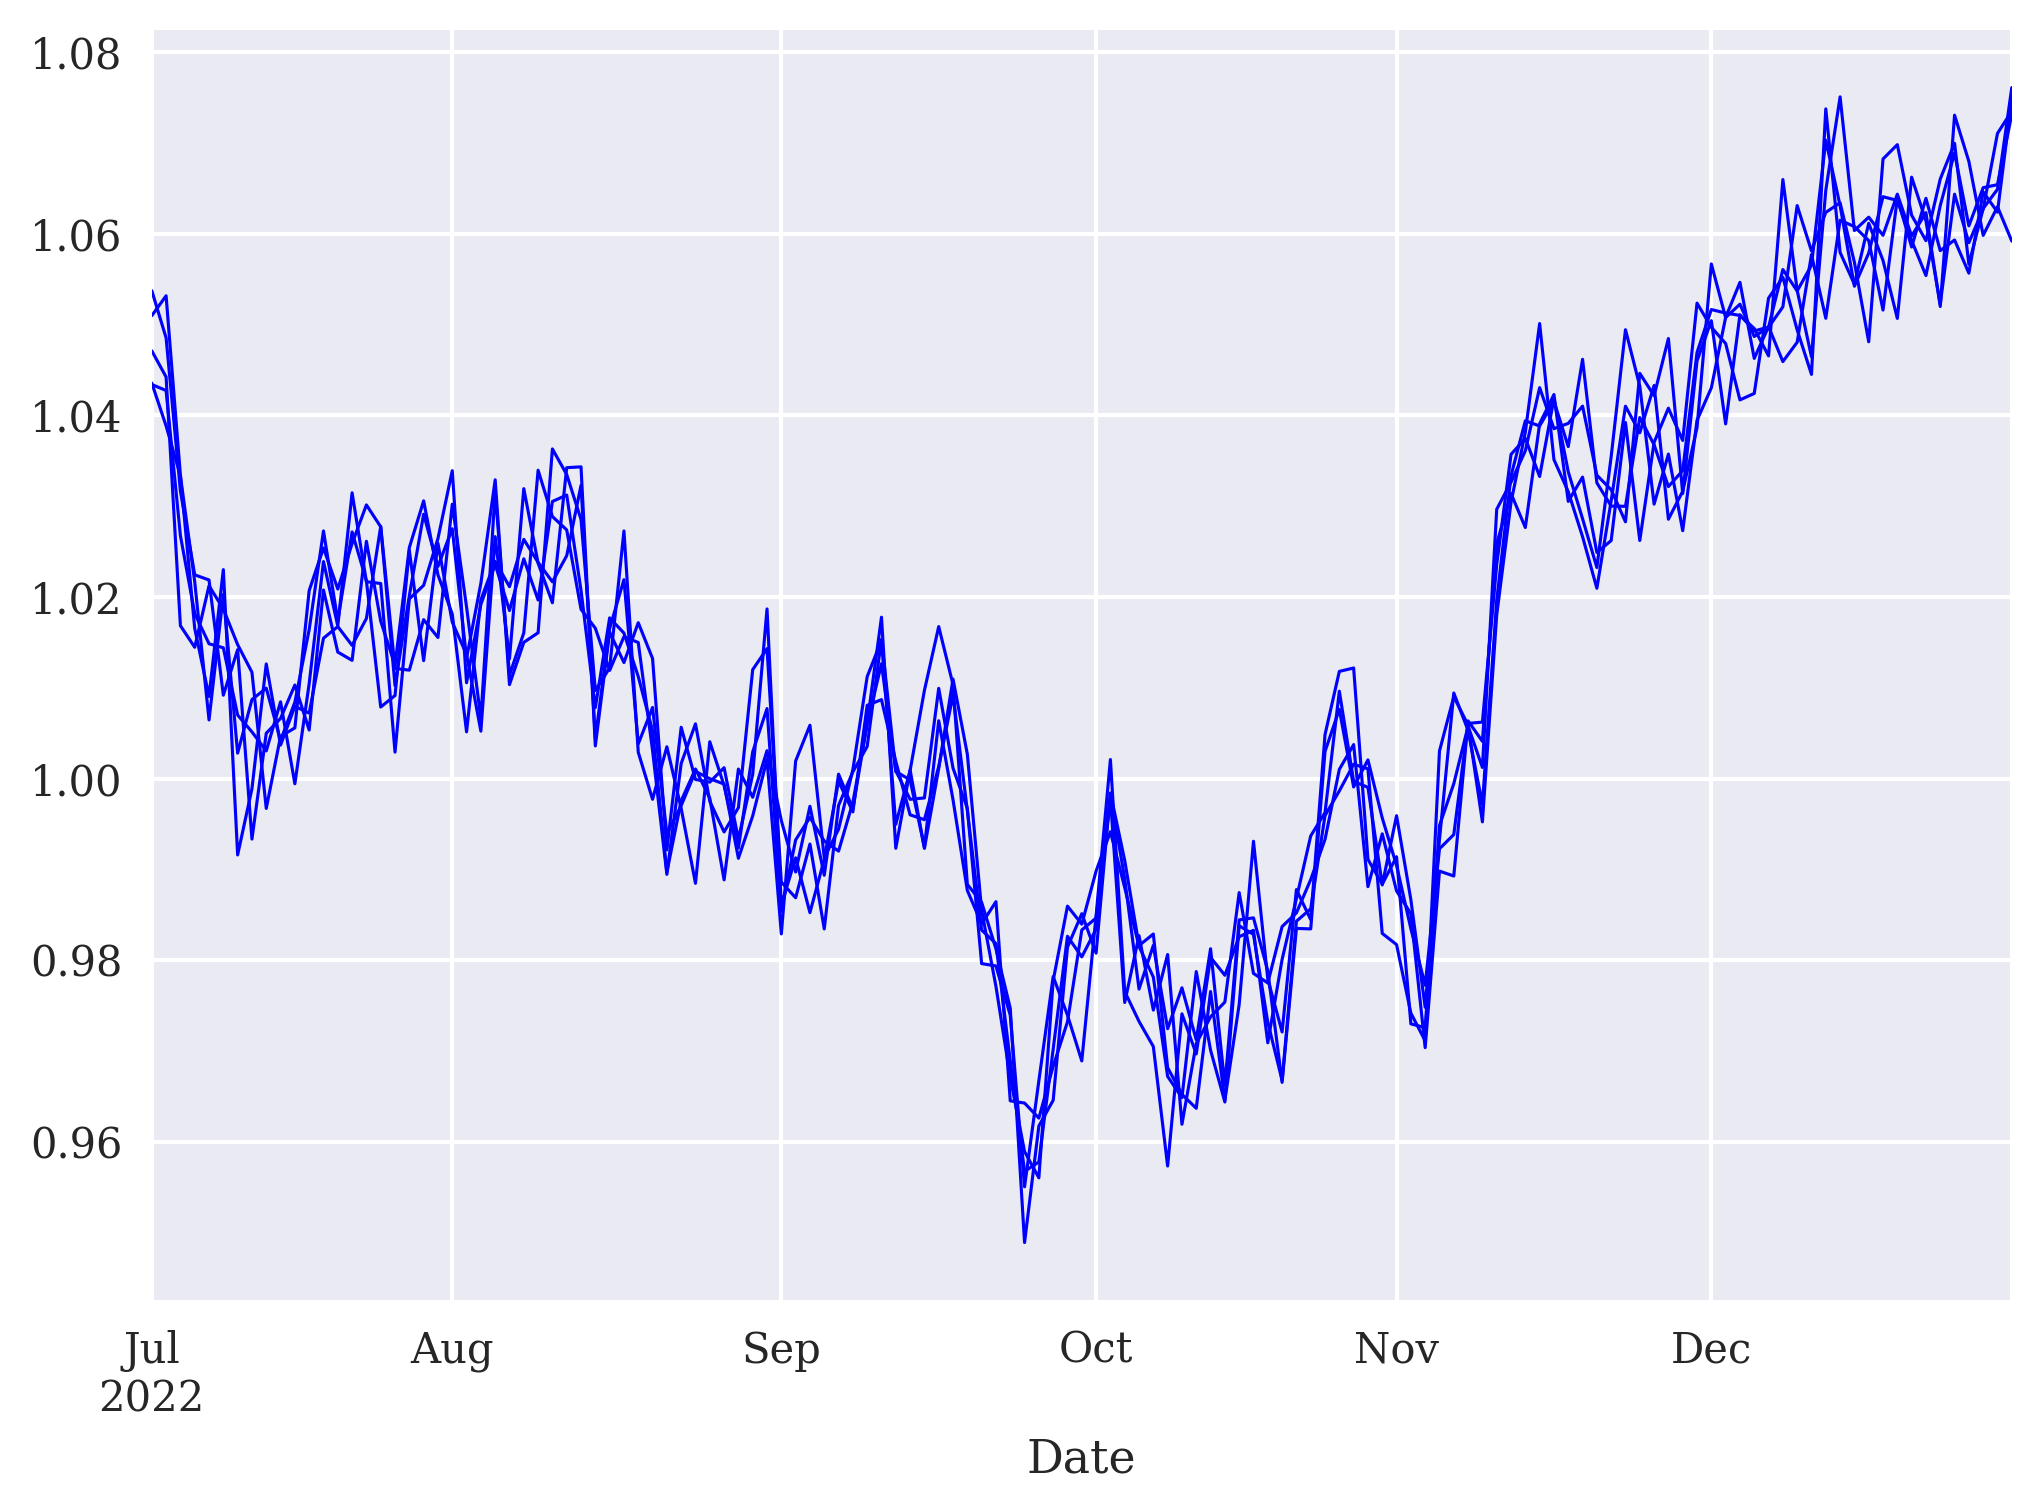

In [ ]:
#@title 💲 Plot some random data from `fin.data`
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'

for _ in range(5):
    fin.reset()
    fin.data[fin.symbol].loc['2022-7-1':].plot(lw=0.75, c='b')

In [ ]:
#@title 🧑‍🤝‍🧑 Run the file to instantiate DQL Agent class
%run dql_agent.py

In [ ]:
#@title 👨‍🏫 Setup the Agent and make him learn
agent = DQLAgent(fin.symbol, fin.feature, fin.n_features, fin)

%time agent.learn(10)

agent.test(5)

In [11]:
#@title 🧙‍♂️ `Simulation` class and instance
class Simulation:
    def __init__(self, symbol, feature, n_features,
                 start, end, periods,
                 min_accuracy=0.525, x0=100,
                 kappa=1, theta=100, sigma=0.2,
                 normalize=True, new=False):
        self.symbol = symbol
        self.feature = feature
        self.n_features = n_features
        self.start = start
        self.end = end
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.min_accuracy = min_accuracy
        self.normalize = normalize
        self.new = new
        self.action_space = ActionSpace()
        self._simulate_data()
        self._prepare_data()

class Simulation(Simulation):

    def _simulate_data(self):
        index = pd.date_range(start=self.start,
                    end=self.end, periods=self.periods)
        x = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / self.periods
        for t in range(1, len(index)):
            x_ = (x[t - 1] + self.kappa * (self.theta - x[t - 1]) * dt +
                  x[t - 1] * self.sigma * math.sqrt(dt) *
                  random.gauss(0, 1))
            x.append(x_)

        self.data = pd.DataFrame(x, columns=[self.symbol], index=index)

    def _prepare_data(self):
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        if self.normalize:
            self.mu = self.data.mean()
            self.std = self.data.std()
            self.data_ = (self.data - self.mu) / self.std
        else:
            self.data_ = self.data.copy()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data['d'] = self.data['d'].astype(int)

    def _get_state(self):
        return self.data_[self.feature].iloc[self.bar -
                                self.n_features:self.bar]
    def seed(self, seed):
        random.seed(seed)
        tf.random.set_seed(seed)
    def reset(self):
        self.treward = 0
        self.accuracy = 0
        self.bar = self.n_features
        if self.new:
            self._simulate_data()
            self._prepare_data()
        state = self._get_state()
        return state.values, {}

    def step(self, action):
        if action == self.data['d'].iloc[self.bar]:
            correct = True
        else:
            correct = False
        reward = 1 if correct else 0
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.n_features)
        if self.bar >= len(self.data):
            done = True
        elif reward == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and self.bar > 25):
            done = True
        else:
            done = False
        next_state = self.data_[self.feature].iloc[
            self.bar - self.n_features:self.bar].values
        return next_state, reward, done, False, {}

In [ ]:
#@title 💱 Simulate EURO with different `theta` and/or `sigma`
sym = 'EUR='

env_base = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=1.1, sigma=0.0,
                 normalize=True)
env_base.seed(100)

env_trend = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=2, sigma=0.1,
                 normalize=True)
env_trend.seed(100)

env_mrev = Simulation(sym, sym, 5, start='2024-1-1', end='2025-1-1',
                 periods=252, x0=1, kappa=1, theta=1, sigma=0.1,
                 normalize=True)
env_mrev.seed(100)


env_mrev.data[sym].iloc[:3]


NameError: name 'ActionSpace' is not defined

In [ ]:
#@title 👁️ Visualize `baseline`, `trend` and `mean_reversion`
env_base.data[sym].plot(figsize=(10, 6), label='baseline', style='r')
env_trend.data[sym].plot(label='trend', style='b:')
env_mrev.data[sym].plot(label='mean-reversion', style='g--')
plt.legend()

NameError: name 'env_base' is not defined

In [ ]:
#@title 🔟 Simulate 10 different processes
sim = Simulation(sym, 'r', 4, start='2024-1-1', end='2028-1-1',
                 periods=2 * 252, min_accuracy=0.485, x0=1,
                 kappa=2, theta=2, sigma=0.15,
                 normalize=True, new=True)
sim.seed(100)

for _ in range(10):
    sim.reset()
    sim.data[sym].plot(figsize=(10, 6), lw=1.0, c='b');

NameError: name 'sym' is not defined

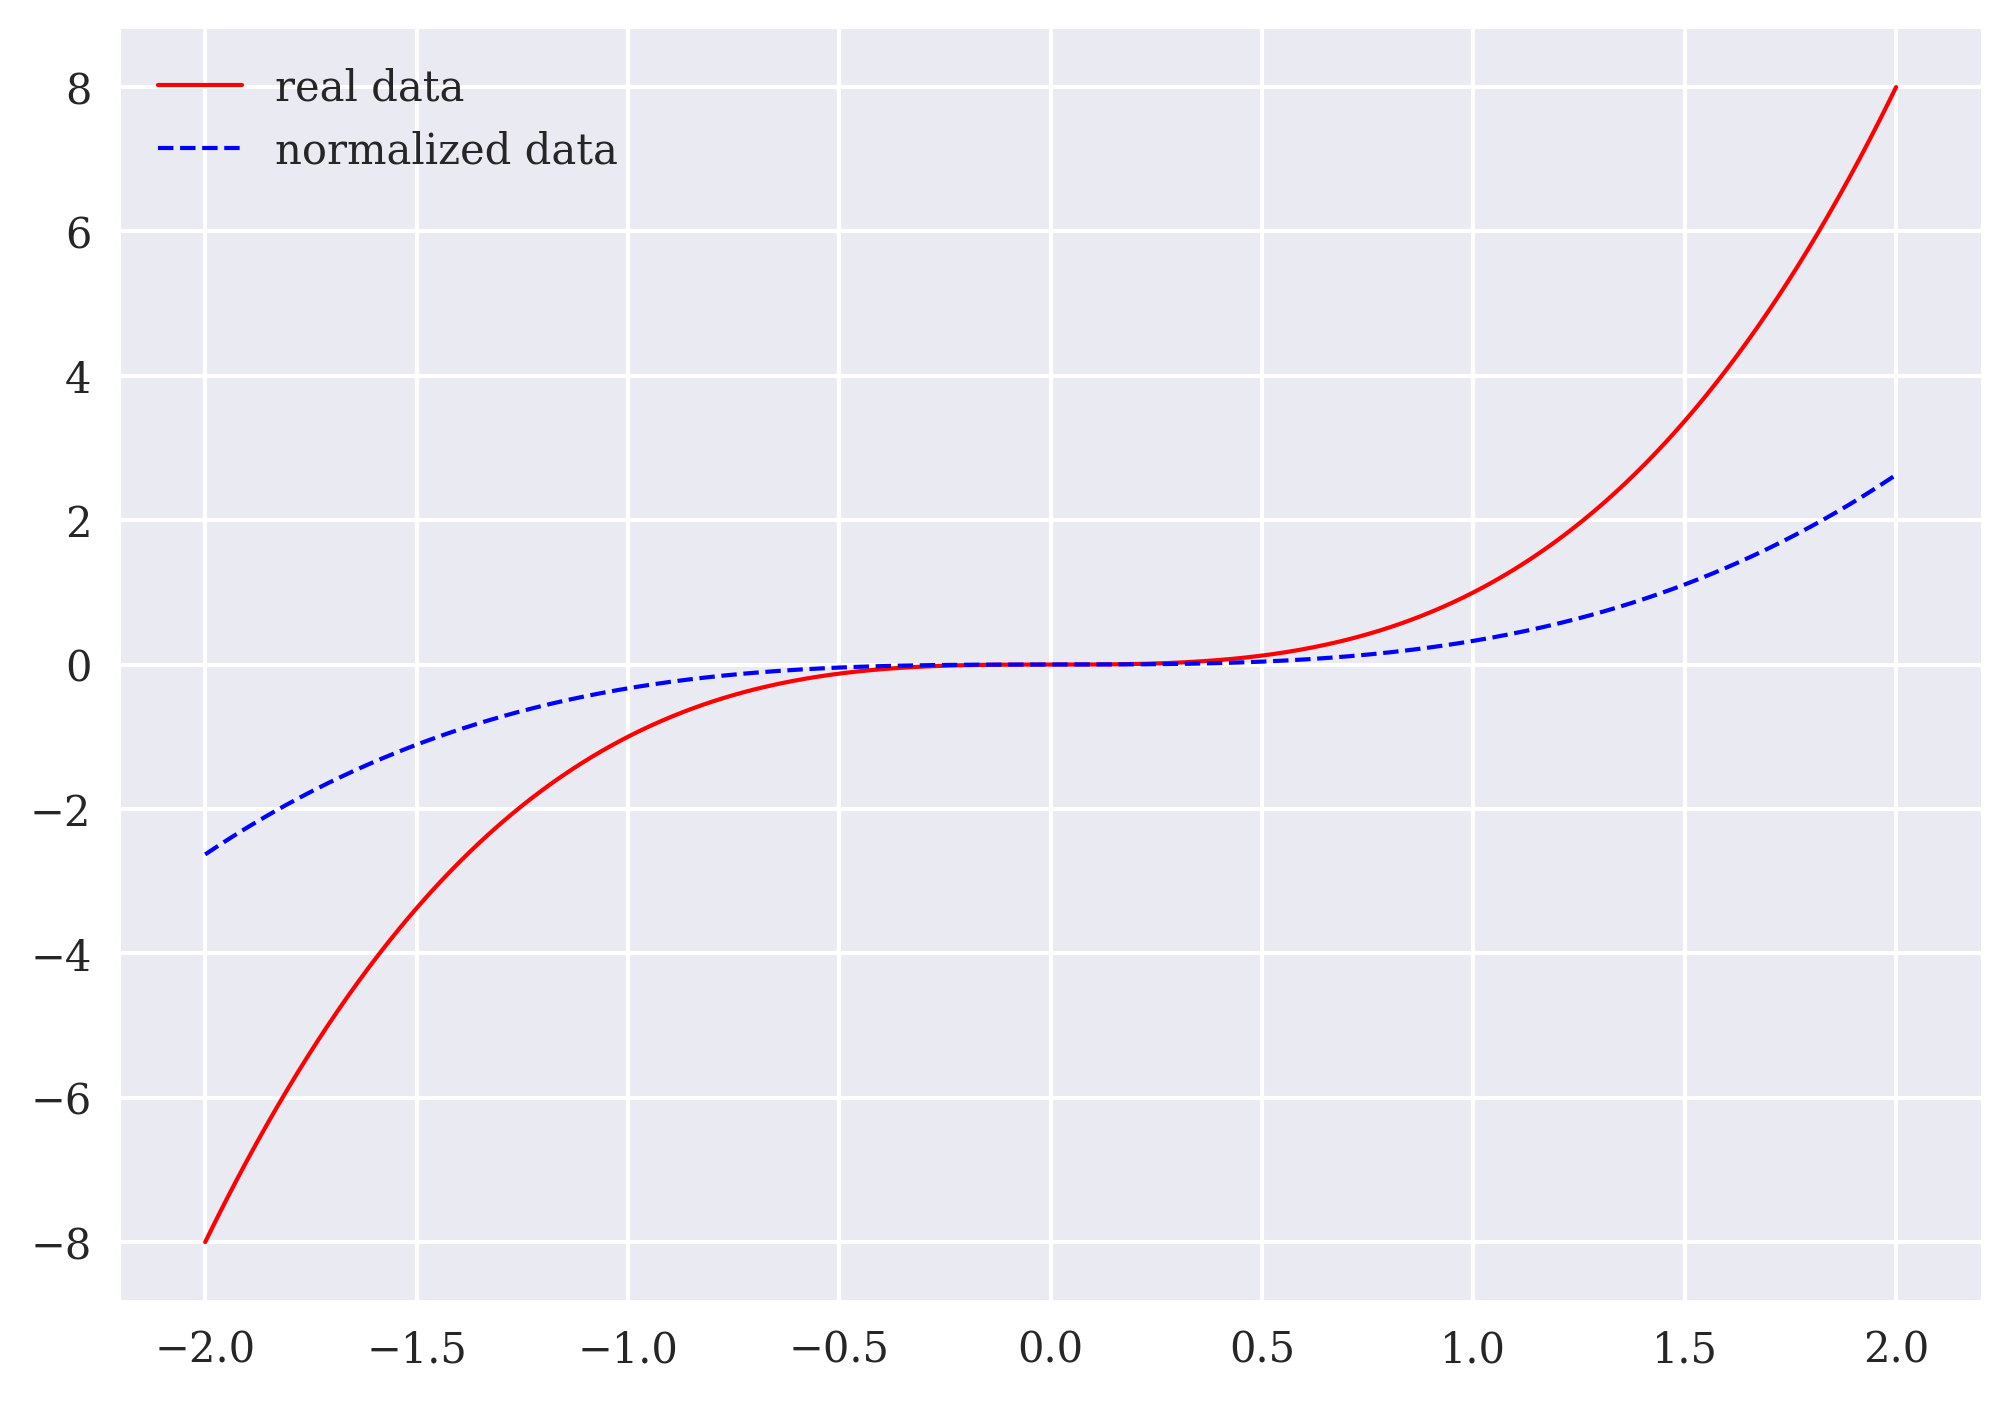

In [ ]:
#@title 🖼️ Plot 'real' vs normalized data with StandardScaler
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

x = np.linspace(-2, 2, 500)

def f(x):
    return x ** 3

y = f(x)


scaler = StandardScaler()

y_ = scaler.fit_transform(y.reshape(-1, 1))




plt.plot(x, y, 'r', lw=1.0,
         label='real data')
plt.plot(x, y_, 'b--', lw=1.0,
         label='normalized data')
plt.legend();


In [ ]:
#@title 🐇 GAN setup

def create_generator(hu=32):
    model = Sequential()
    model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model

def create_discriminator(hu=32):
    model = Sequential()
    model.add(Dense(hu, activation='relu', input_dim=1))
    model.add(Dense(hu, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(),
                  metrics=['accuracy'])
    return model

def create_gan(generator, discriminator, lr=0.001):
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=lr))
    return model

generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(generator, discriminator, 0.0001)

from numpy.random import default_rng

rng = default_rng(seed=100)

def train_models(y_, epochs, batch_size):
    for epoch in range(epochs):
        # Generate synthetic data
        noise = rng.normal(0, 1, (batch_size, 1))
        synthetic_data = generator.predict(noise, verbose=False)
        # Train discriminator
        real_data = y_[rng.integers(0, len(y_), batch_size)]
        discriminator.train_on_batch(real_data, np.ones(batch_size))
        discriminator.train_on_batch(synthetic_data,
                                     np.zeros(batch_size))

        # Train generator
        noise = rng.normal(0, 1, (batch_size, 1))
        gan.train_on_batch(noise, np.ones(batch_size))
        # Print progress
        if epoch % 100 == 0:
            print(f'Epoch: {epoch}')
    return real_data, synthetic_data

In [ ]:
#@title 🏋️ Train a GAN
%%time
real_data, synthetic_data = train_models(y_, epochs=301, batch_size=32)

Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
CPU times: user 26.3 s, sys: 533 ms, total: 26.9 s
Wall time: 31.6 s


In [ ]:
#@title 🔫 Plot synthetic GAN data

plt.plot(real_data, 'r', lw=1.0,
         label='real data (last batch)')
plt.plot(synthetic_data, 'b:', lw=1.0,
         label='synthetic data (last batch)')
plt.legend();

In [ ]:
#@title 🔬 Generate 5 sets of GAN data and compare statistics

data = pd.DataFrame({'real': y}, index=x)

N = 5
for i in range(N):
    noise = rng.normal(0, 1, (len(y), 1))
    synthetic_data = generator.predict(noise, verbose=False)
    data[f'synth_{i:02d}'] = scaler.inverse_transform(synthetic_data)


data.describe().round(3)


real  synth_00  synth_01  synth_02  synth_03  synth_04
count  500.000   500.000   500.000   500.000   500.000   500.000
mean    -0.000     0.004     0.004     0.004     0.004     0.004
std      3.045     0.005     0.005     0.004     0.004     0.005
min     -8.000    -0.002    -0.002    -0.002    -0.002    -0.002
25%     -1.000     0.002     0.002     0.001     0.002     0.002
50%     -0.000     0.003     0.003     0.003     0.003     0.003
75%      1.000     0.005     0.005     0.005     0.005     0.005
max      8.000     0.051     0.041     0.036     0.039     0.055

In [ ]:
#@title 🛑 MSE of Real vs Synth_00
((data.apply(np.sort)['real'] - data.apply(np.sort)['synth_00']) ** 2).mean()

np.float64(9.229833011488068)

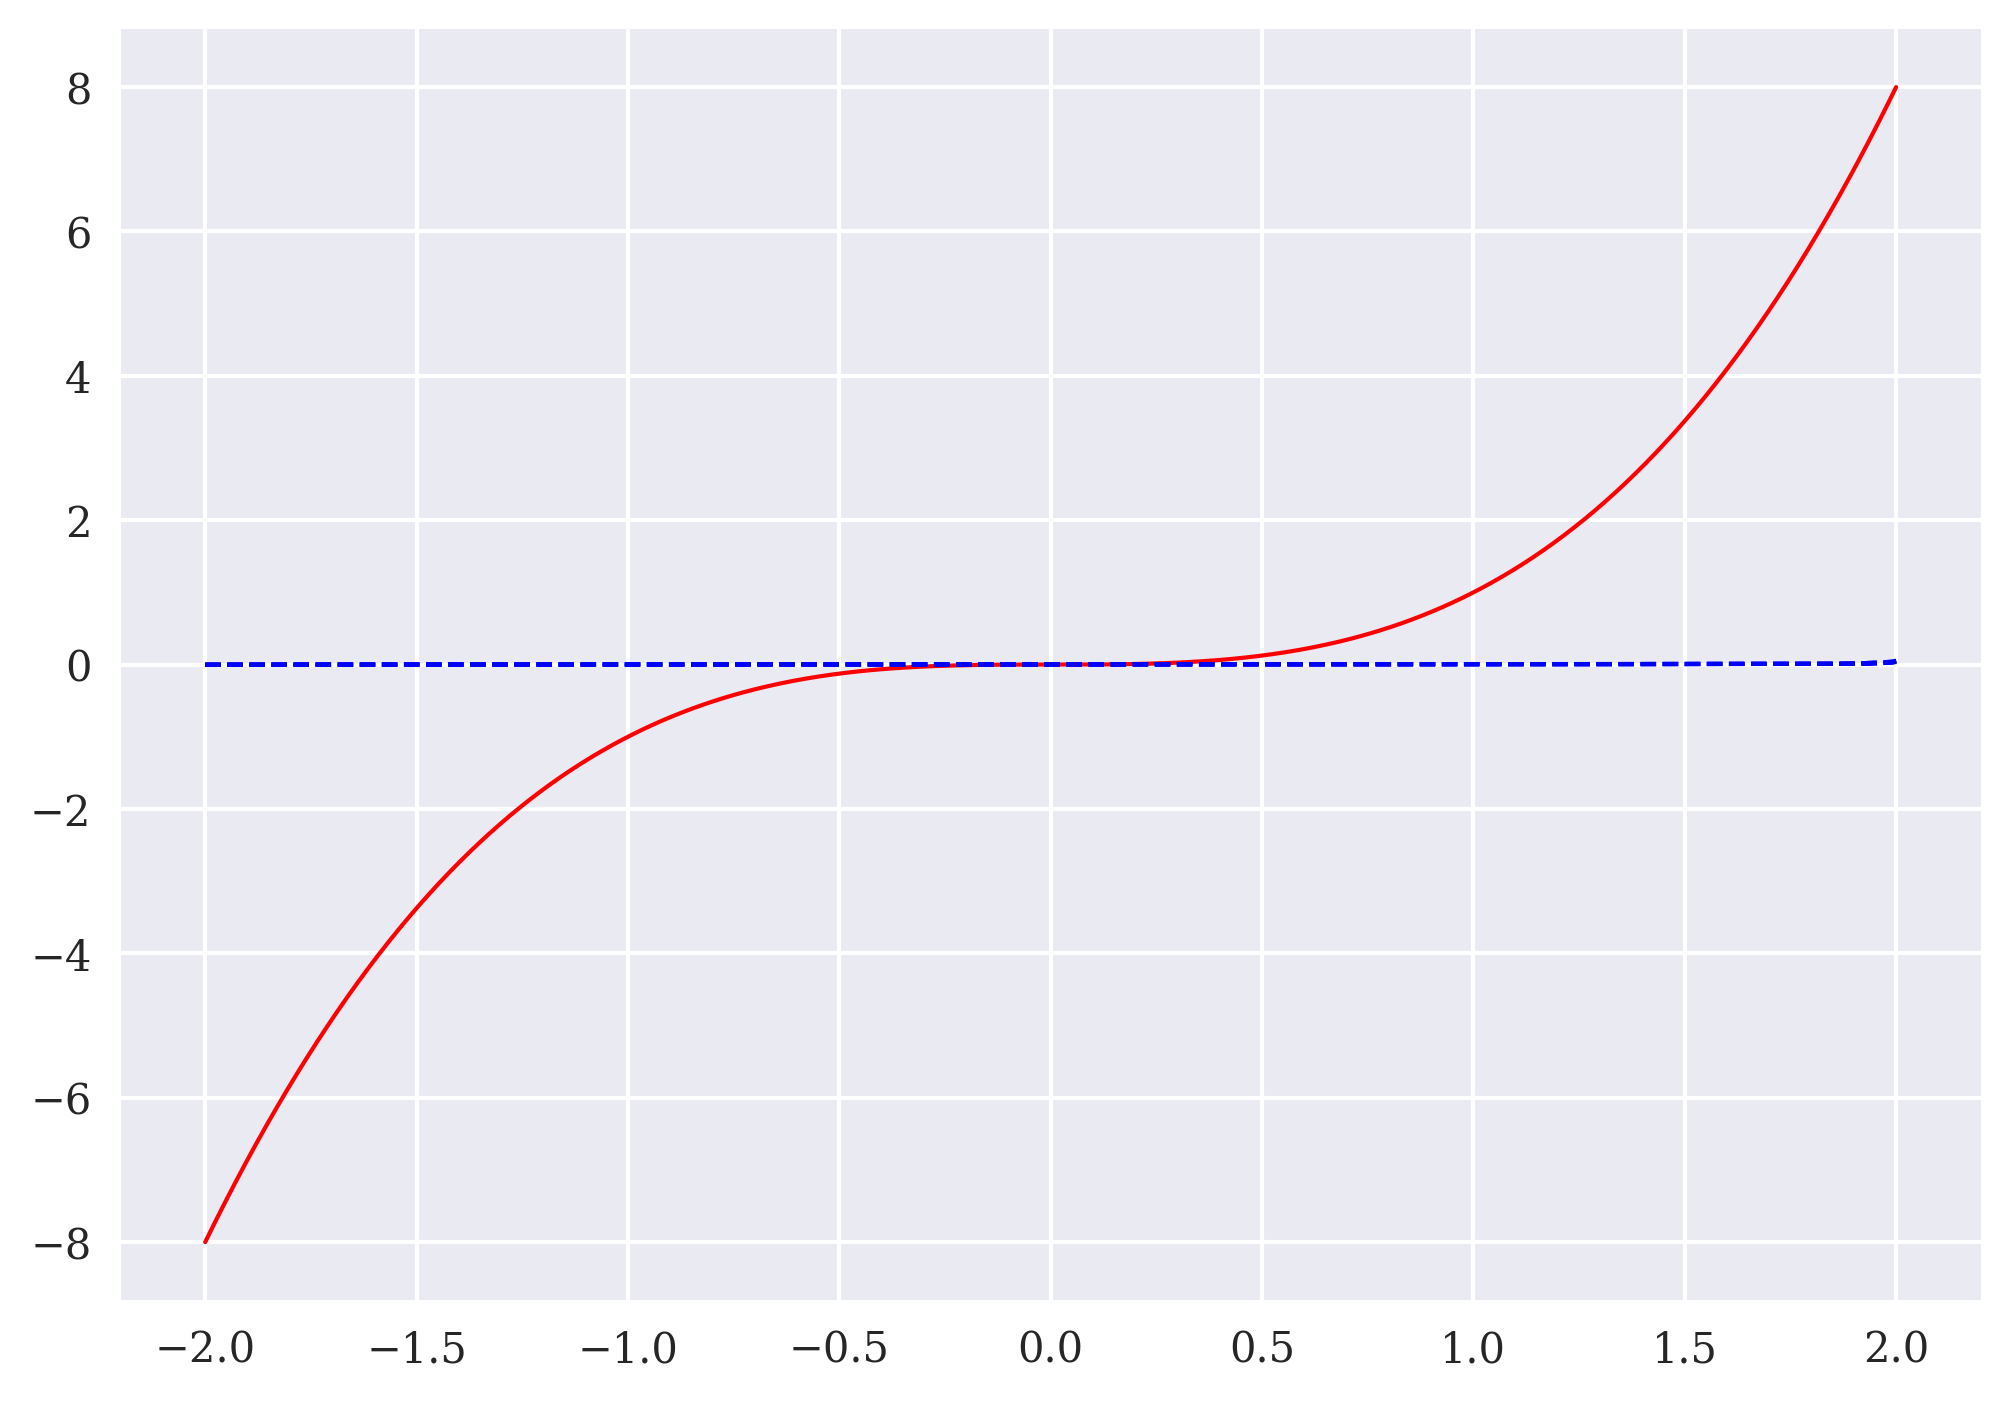

In [ ]:
#@title 🤏 Sorted `data` DataFrame and plotted
data.apply(np.sort).plot(style=['r'] + N * ['b--'], lw=1, legend=False)

In [ ]:
#@title 🙈 GAN against real finance data (GLD)

N_EPOCHS = 501 #@param {type:'integer'}
raw = pd.read_csv('https://certificate.tpq.io/rl4finance.csv',
                 index_col=0, parse_dates=True).dropna()

rets = raw['GLD'].iloc[-2 * 252:]
rets = np.log((rets / rets.shift(1)).dropna())
rets = rets.values

scaler = StandardScaler()

rets_ = scaler.fit_transform(rets.reshape(-1, 1))

rng = default_rng(100)
tf.random.set_seed(100)

generator = create_generator(hu=24)
discriminator = create_discriminator(hu=24)
gan = create_gan(generator, discriminator, lr=0.0001)

%time rd, sd = train_models(y_=rets_, epochs=N_EPOCHS, batch_size=32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
CPU times: user 43.6 s, sys: 838 ms, total: 44.5 s
Wall time: 48.1 s


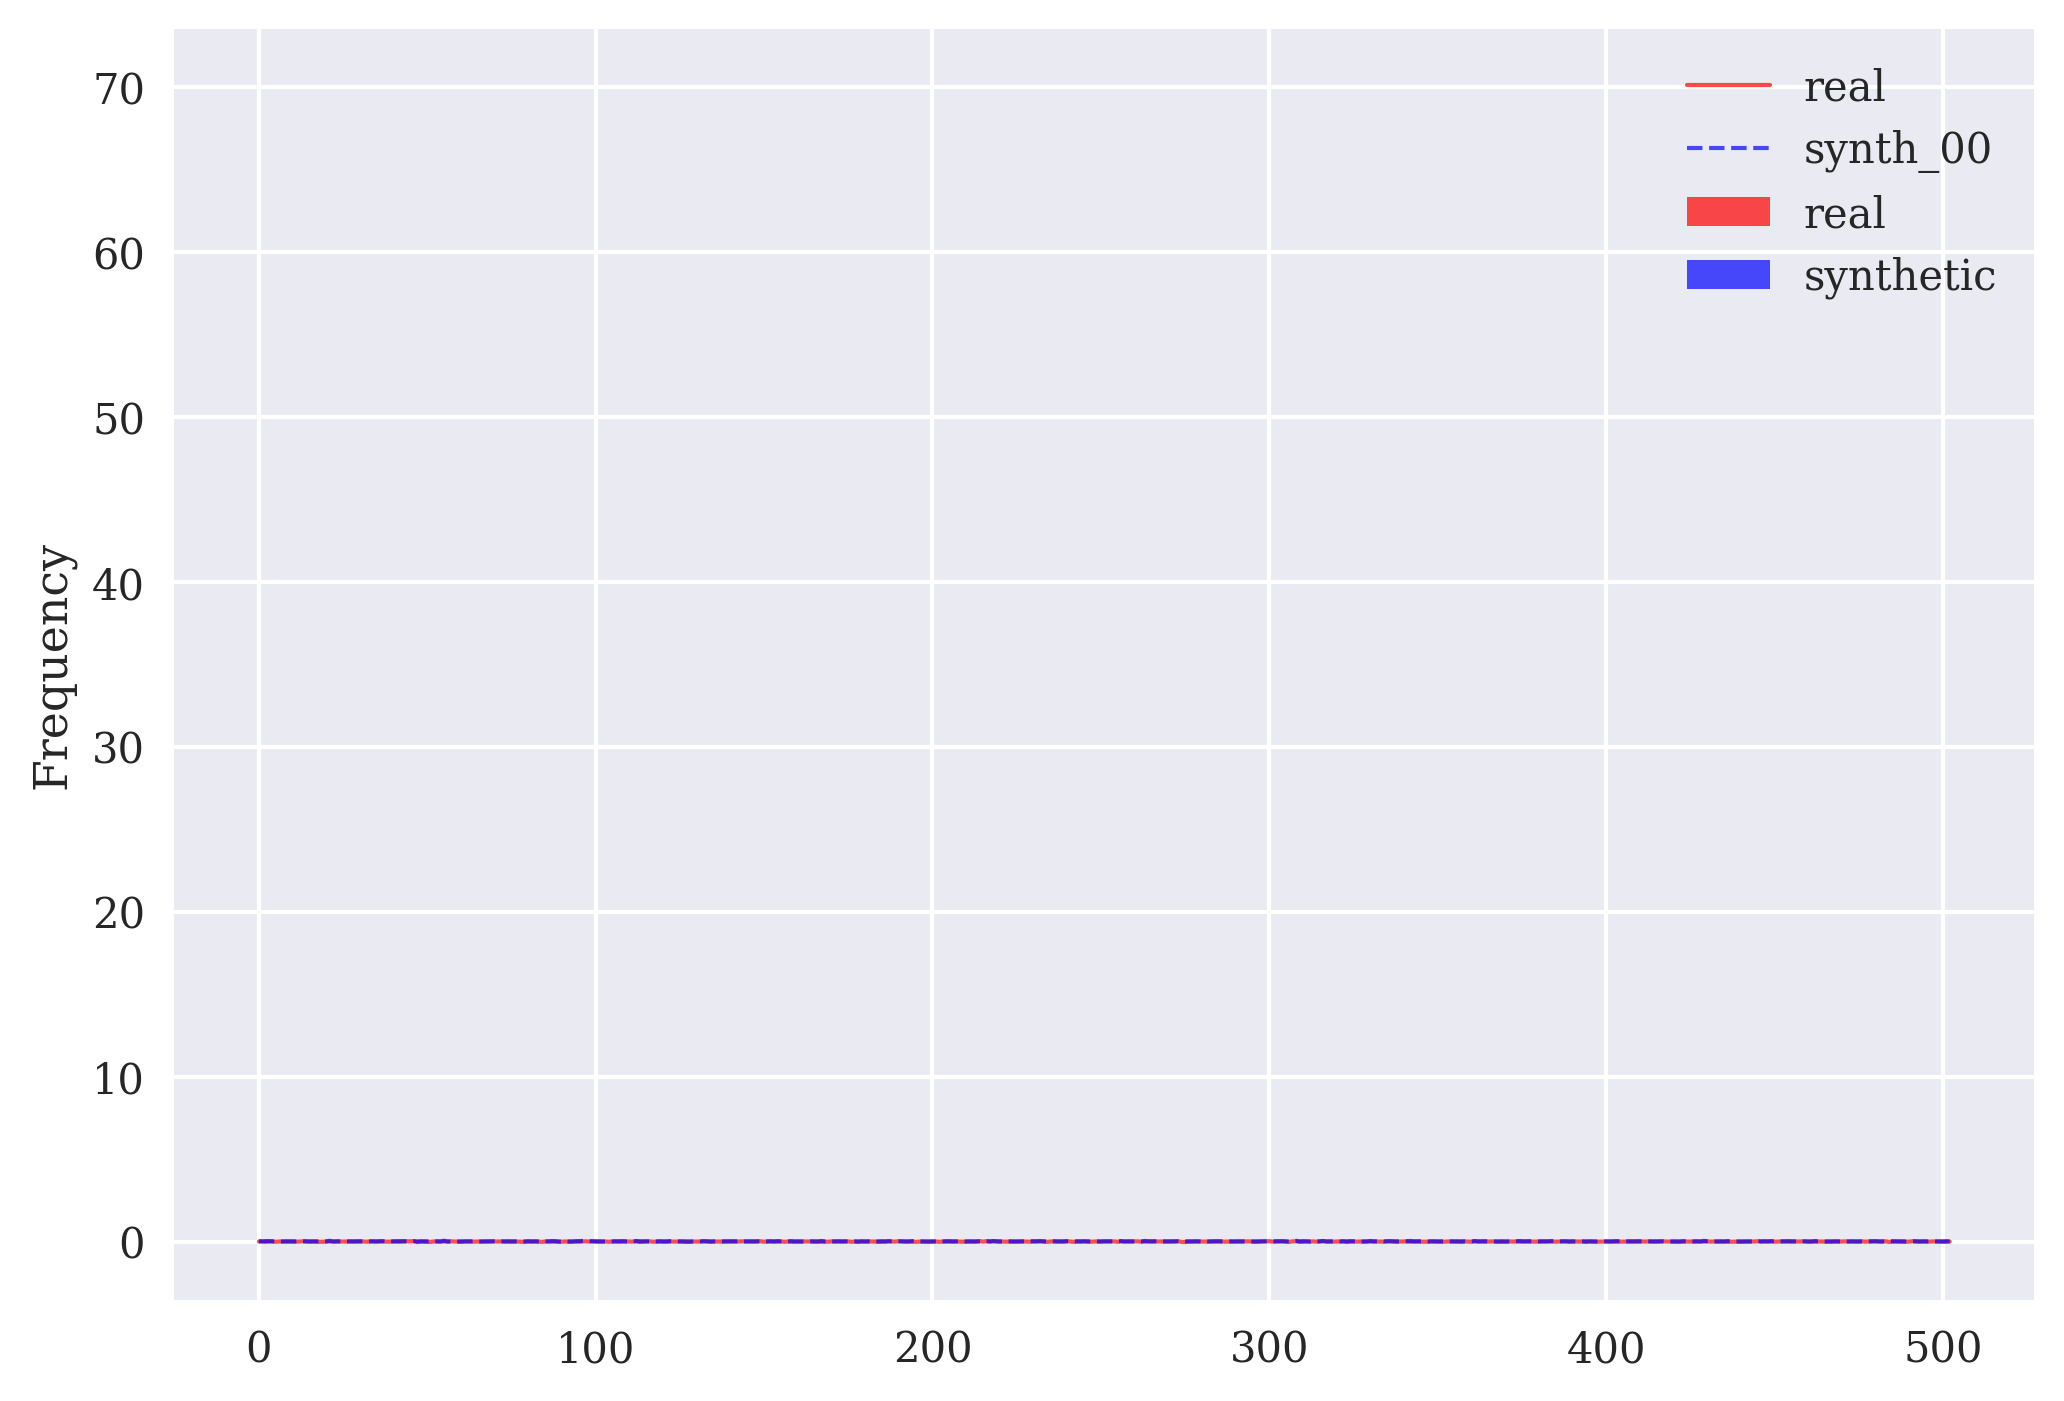

In [ ]:
#@title 👩‍🔬 Real returns vs GAN synthetic returns  (line + hist)

data = pd.DataFrame({'real': rets})

N = 25

for i in range(N):
    noise = np.random.normal(0, 1, (len(rets_), 1))
    synthetic_data = generator.predict(noise, verbose=False)
    data[f'synth_{i:02d}'] = scaler.inverse_transform(
                                            synthetic_data)

res = data.describe().round(4)
res.iloc[:, :5]

data.iloc[:, :2].plot(style=['r', 'b--', 'b--'], lw=1, alpha=0.7);

data['real'].plot(kind='hist', bins=50, label='real',
                  color='r', alpha=0.7)
data['synth_00'].plot(kind='hist', bins=50, alpha=0.7,
                  label='synthetic', color='b', sharex=True)
plt.legend();

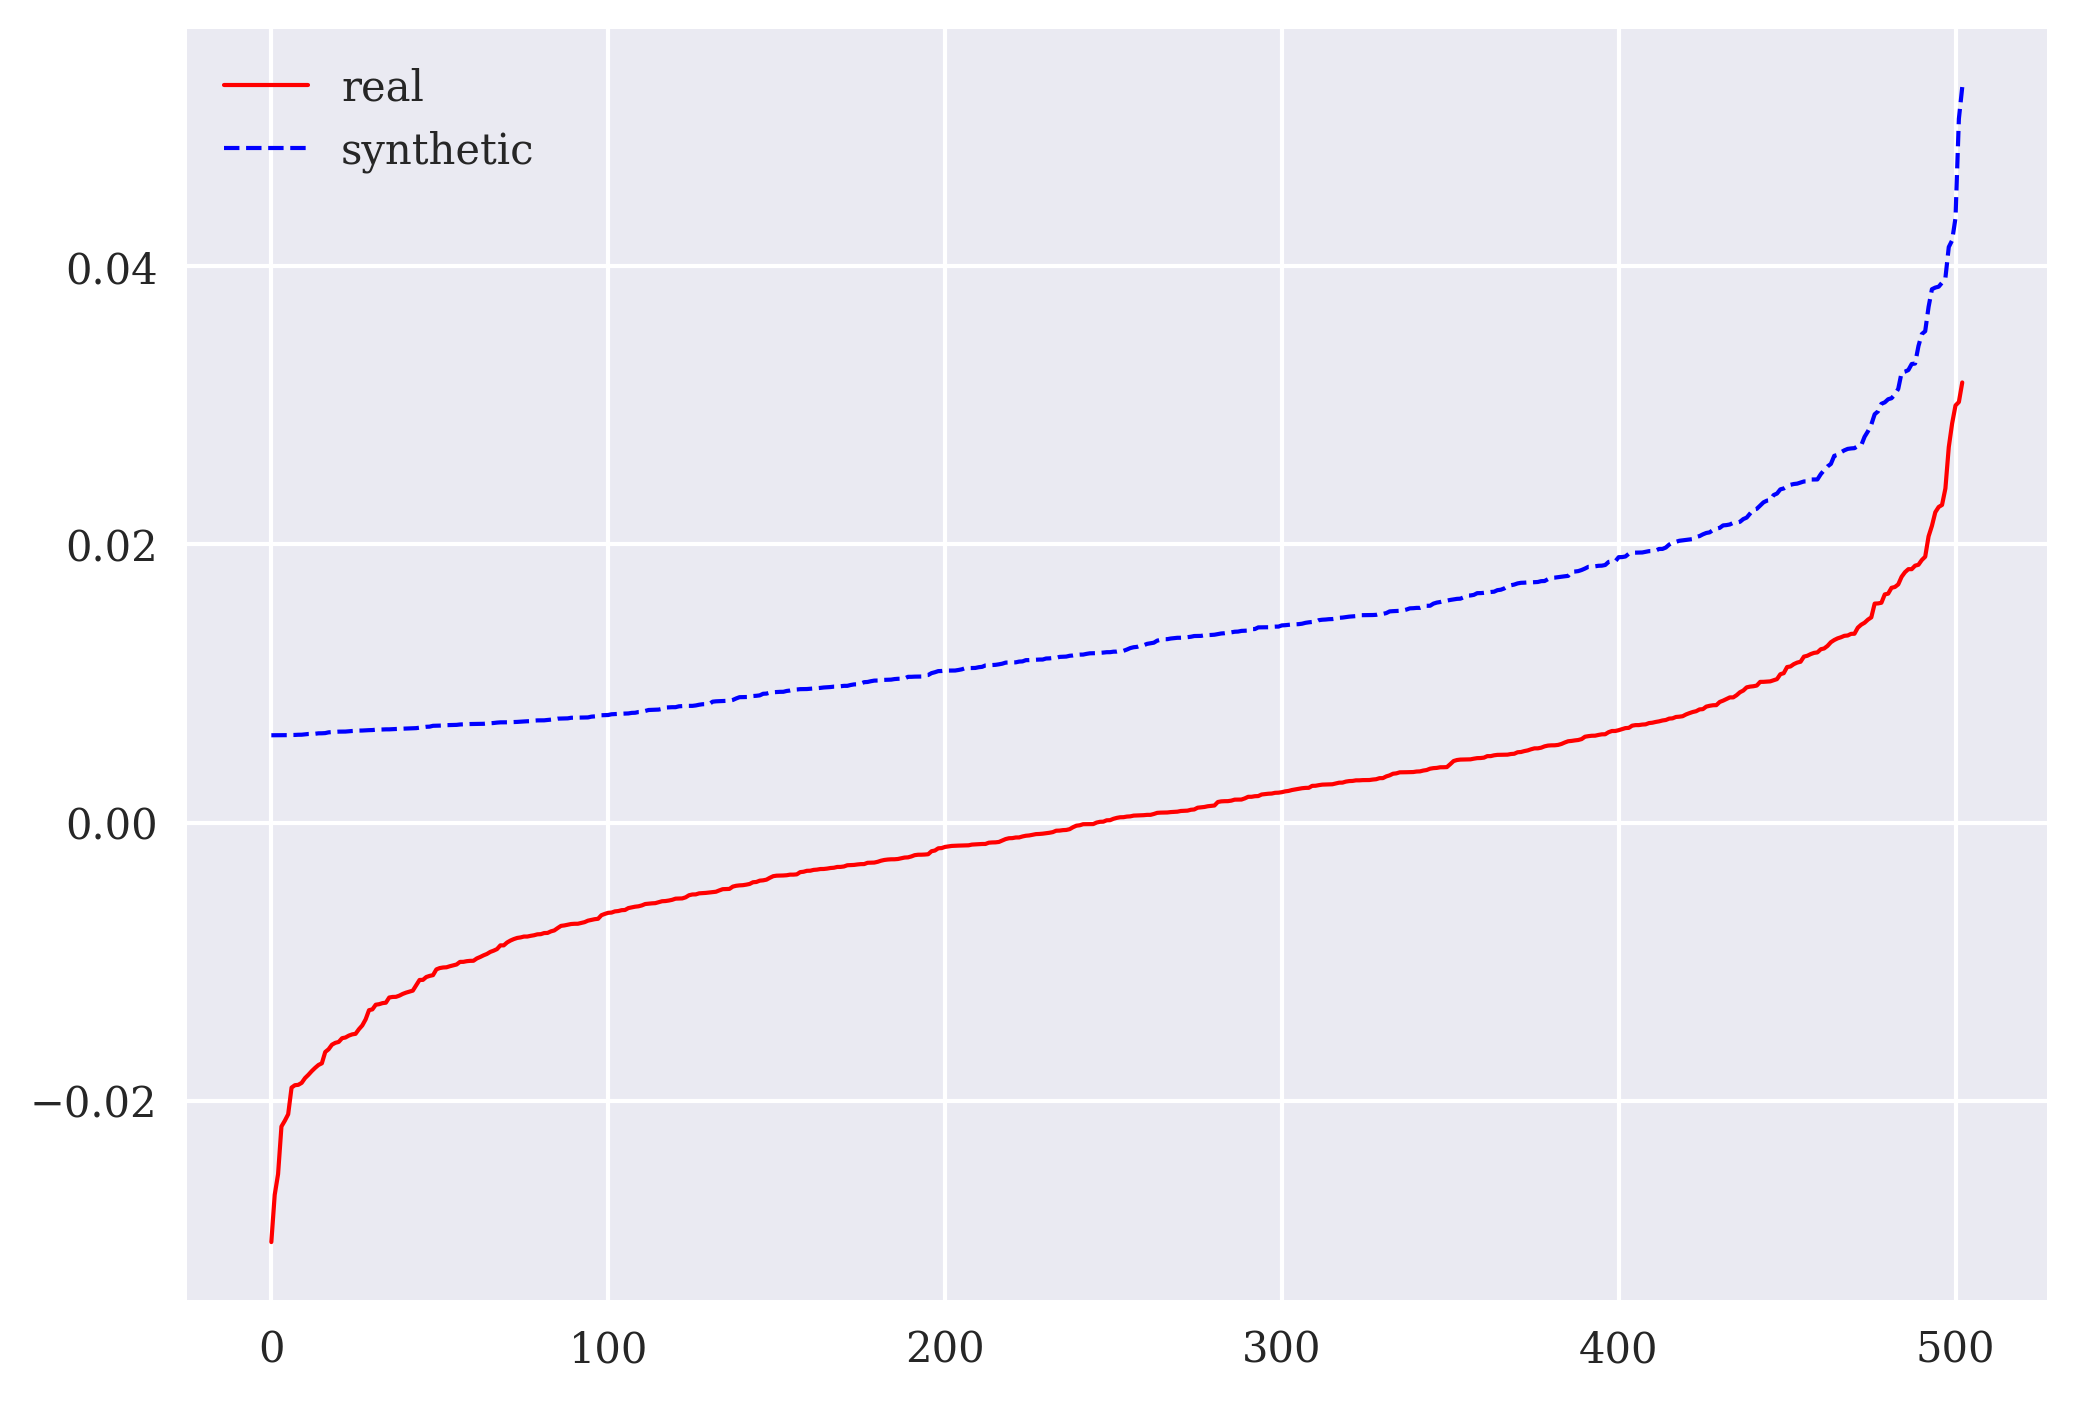

In [ ]:
#@title ⚖️ Compare Real with synthetic_00

plt.plot(np.sort(data['real']), 'r', lw=1.0, label='real')
plt.plot(np.sort(data['synth_00']), 'b--', lw=1.0, label='synthetic')
plt.legend();

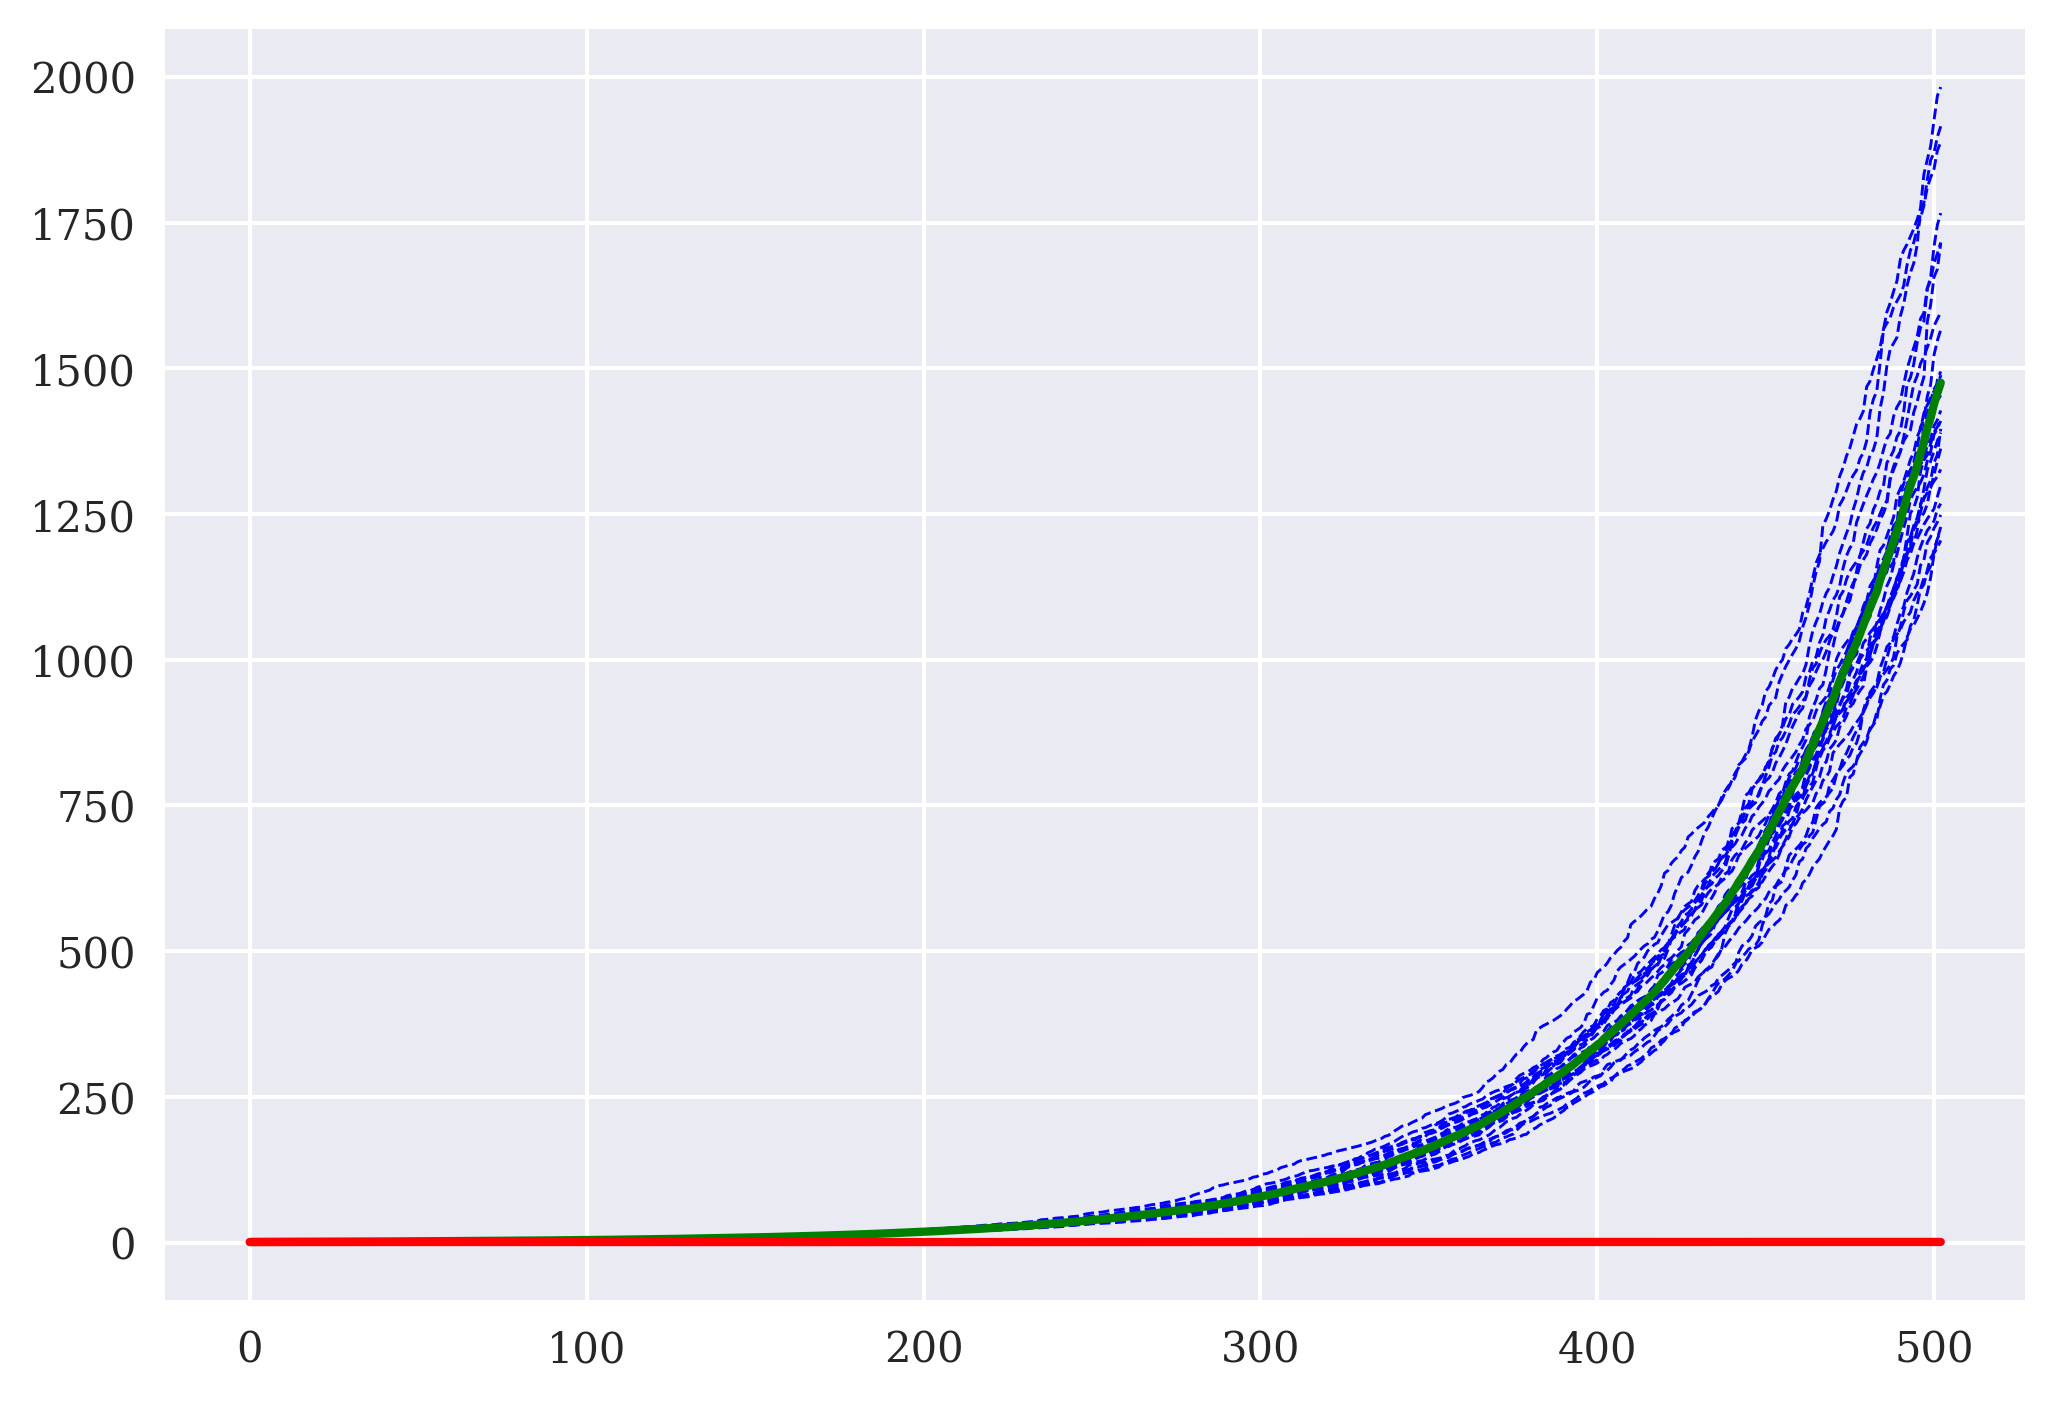

In [ ]:
#@title 🪄 Some magic plot
sn = N
data.iloc[:, 1:sn + 1].cumsum().apply(np.exp).plot(
    style='b--', lw=0.7, legend=False)
data.iloc[:, 1:sn + 1].mean(axis=1).cumsum().apply(
    np.exp).plot(style='g', lw=2)
data['real'].cumsum().apply(np.exp).plot(style='r', lw=2);

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0.0


3

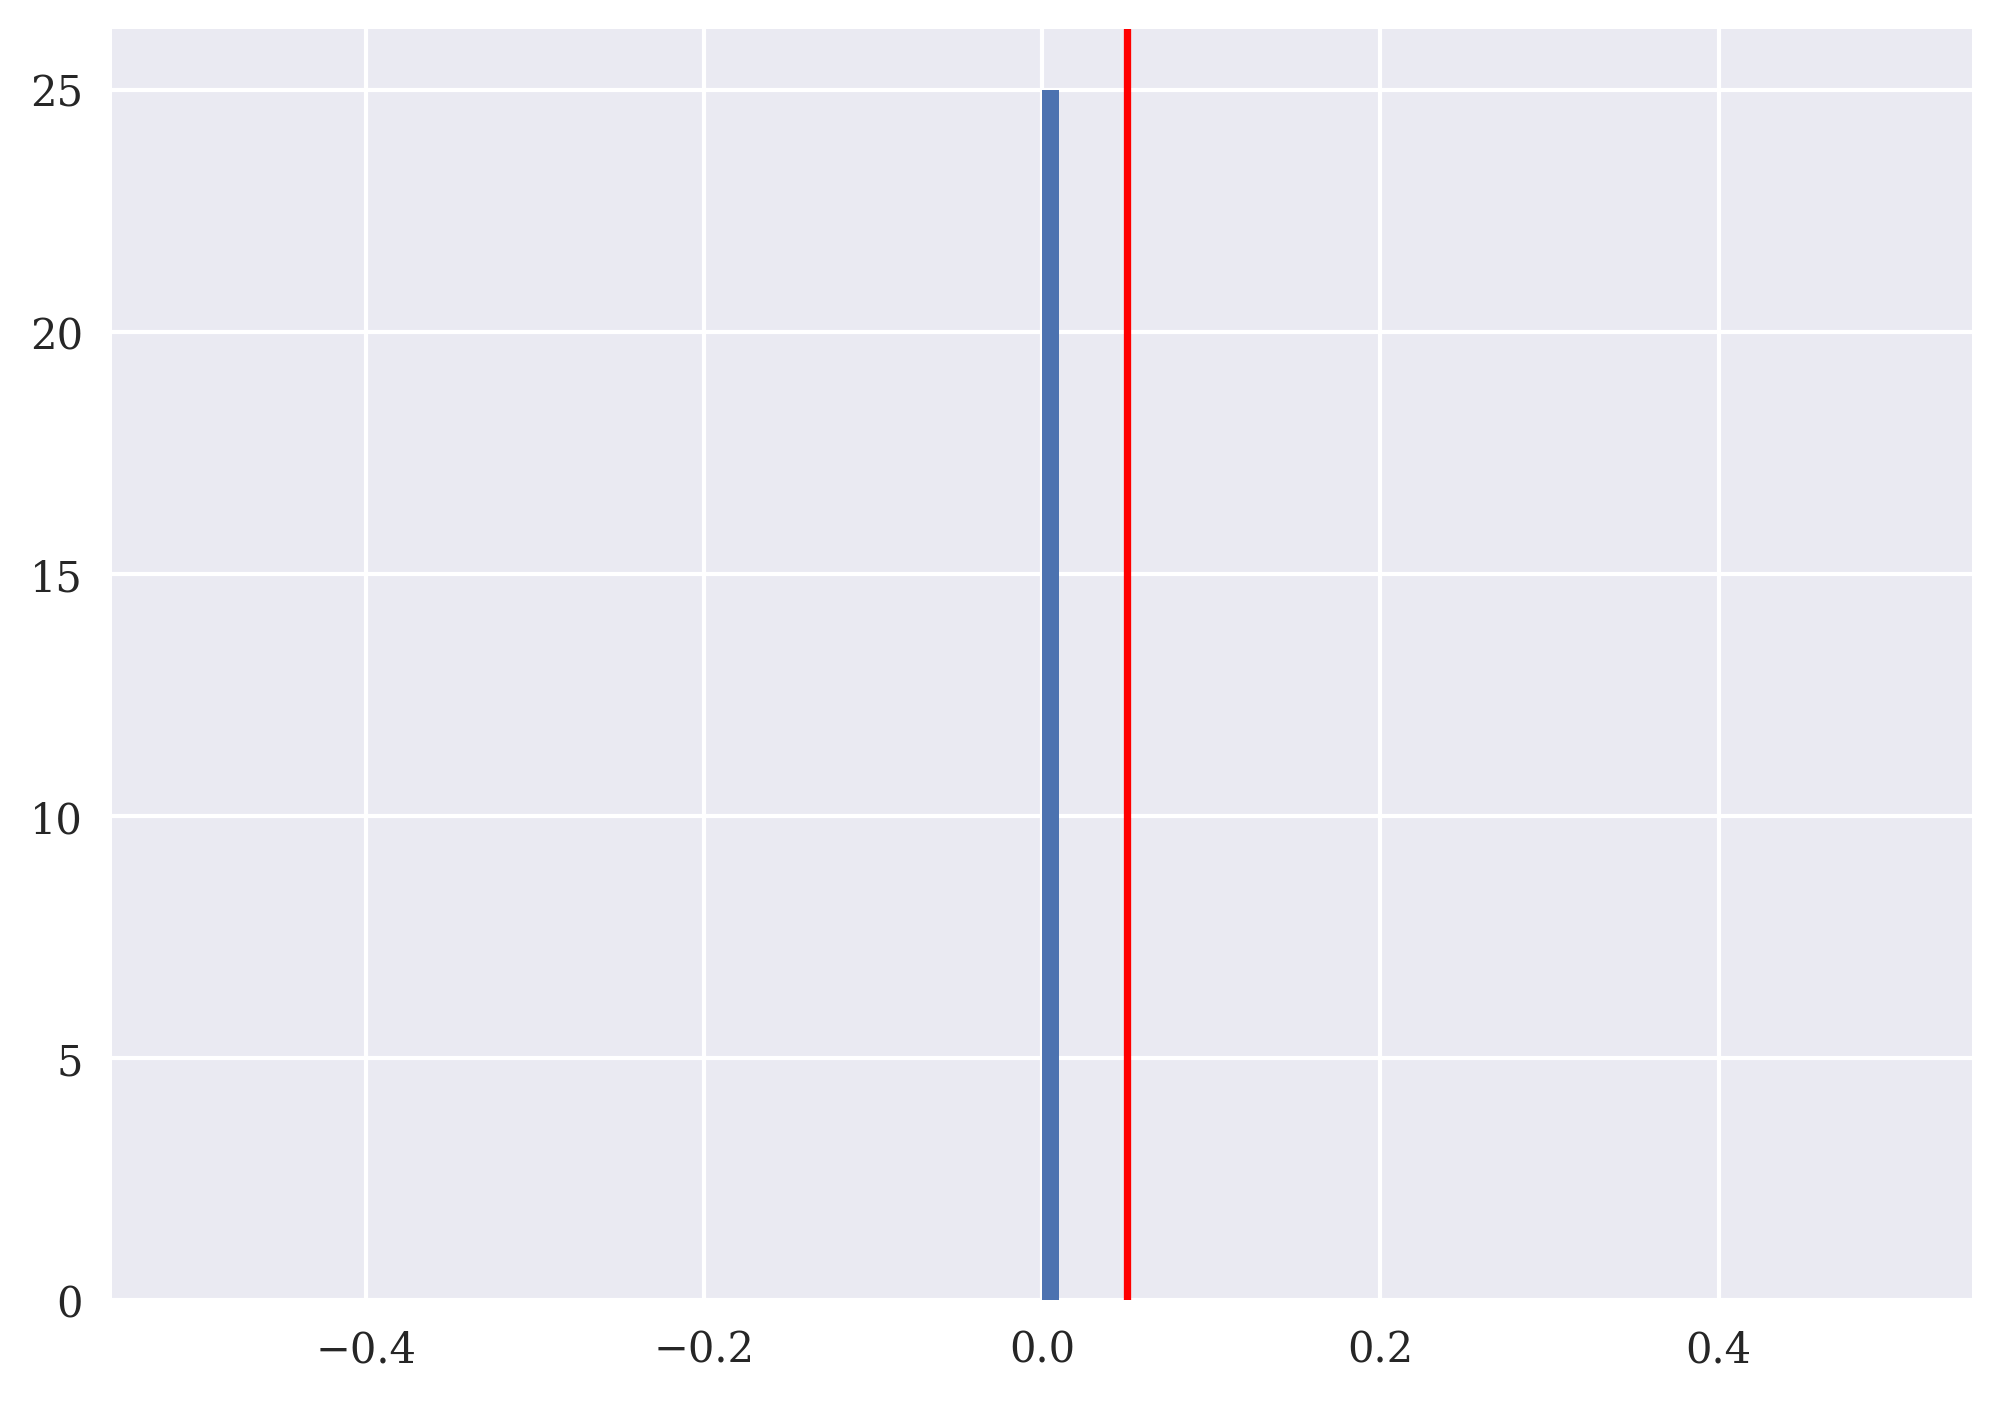

In [ ]:
#@title ❓ Kolmogorov-Smirnov test

pvs = list()
for i in range(N):
    pvs.append(stats.kstest(data[f'synth_{i:02d}'],
                            data['real']).pvalue)
pvs = np.array(pvs)

print(np.sort((pvs > 0.05).astype(int)))
print(sum(np.sort(pvs > 0.05)) / N)

plt.hist(pvs, bins=100)
plt.axvline(0.05, color='r');3

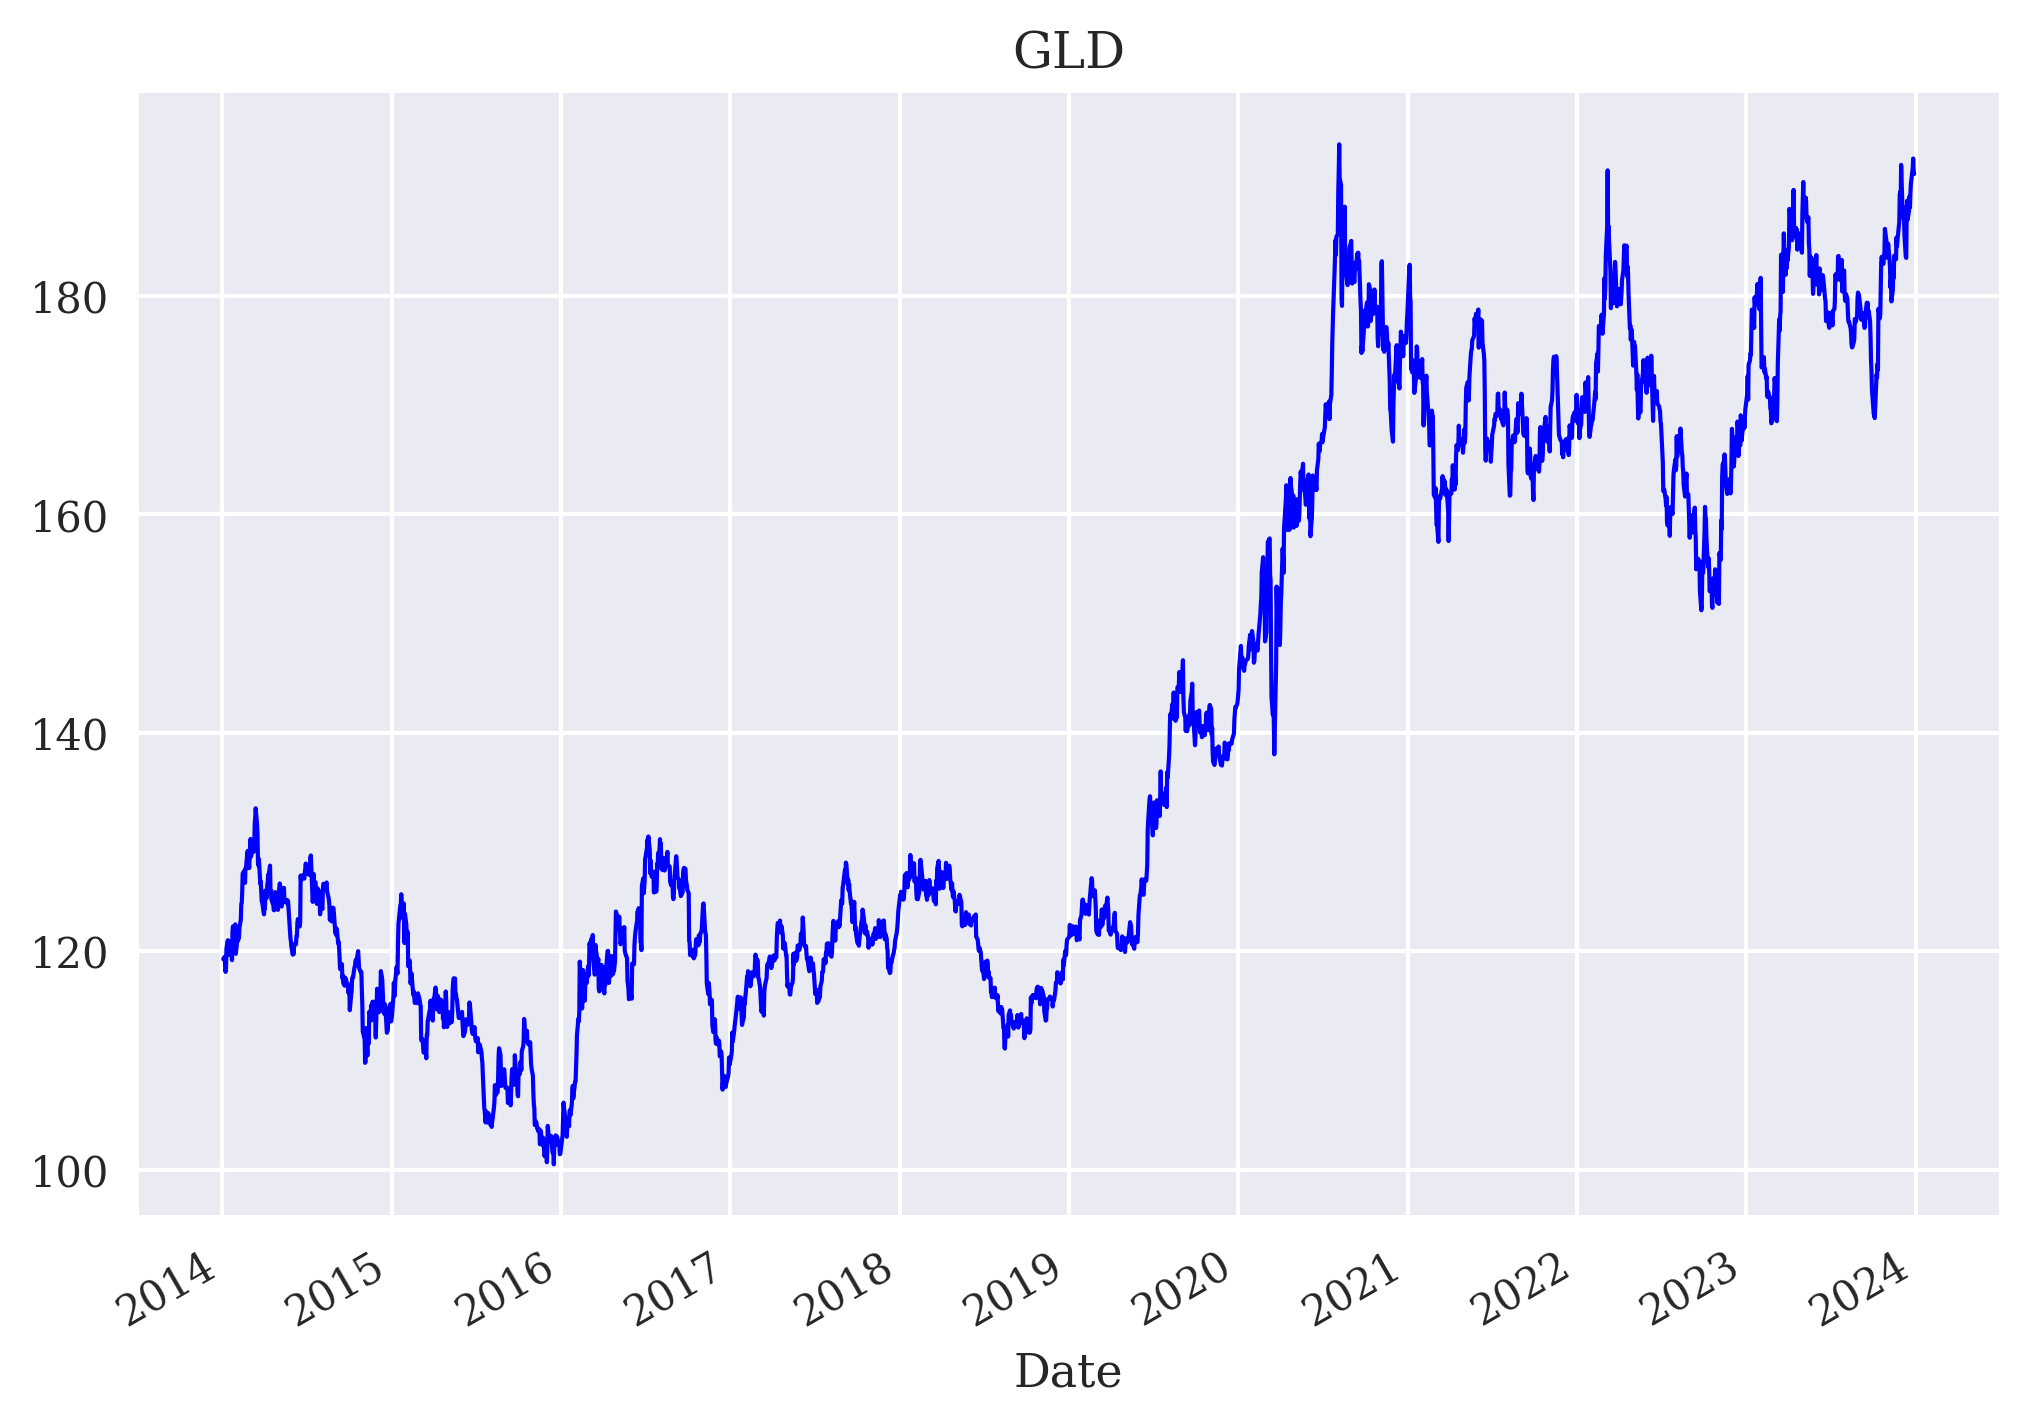

In [13]:
#@title 🌿 Plot GLD evolution of return rates

from finance import *

plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)


finance = Finance('GLD', 'r', min_accuracy=47.5, n_features=8)

finance.data[finance.symbol].plot(title=finance.symbol, lw=1.0, c='b');

In [14]:
#@title 🦉 Make the DQL Agent learn in the environment

from dqlagent import *


N_STEPS = 5 #@param {type:'integer'}

dqlagent = DQLAgent(finance.symbol, finance.feature,
                 finance.n_features, finance, lr=0.0001)

%time dqlagent.learn(N_STEPS)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

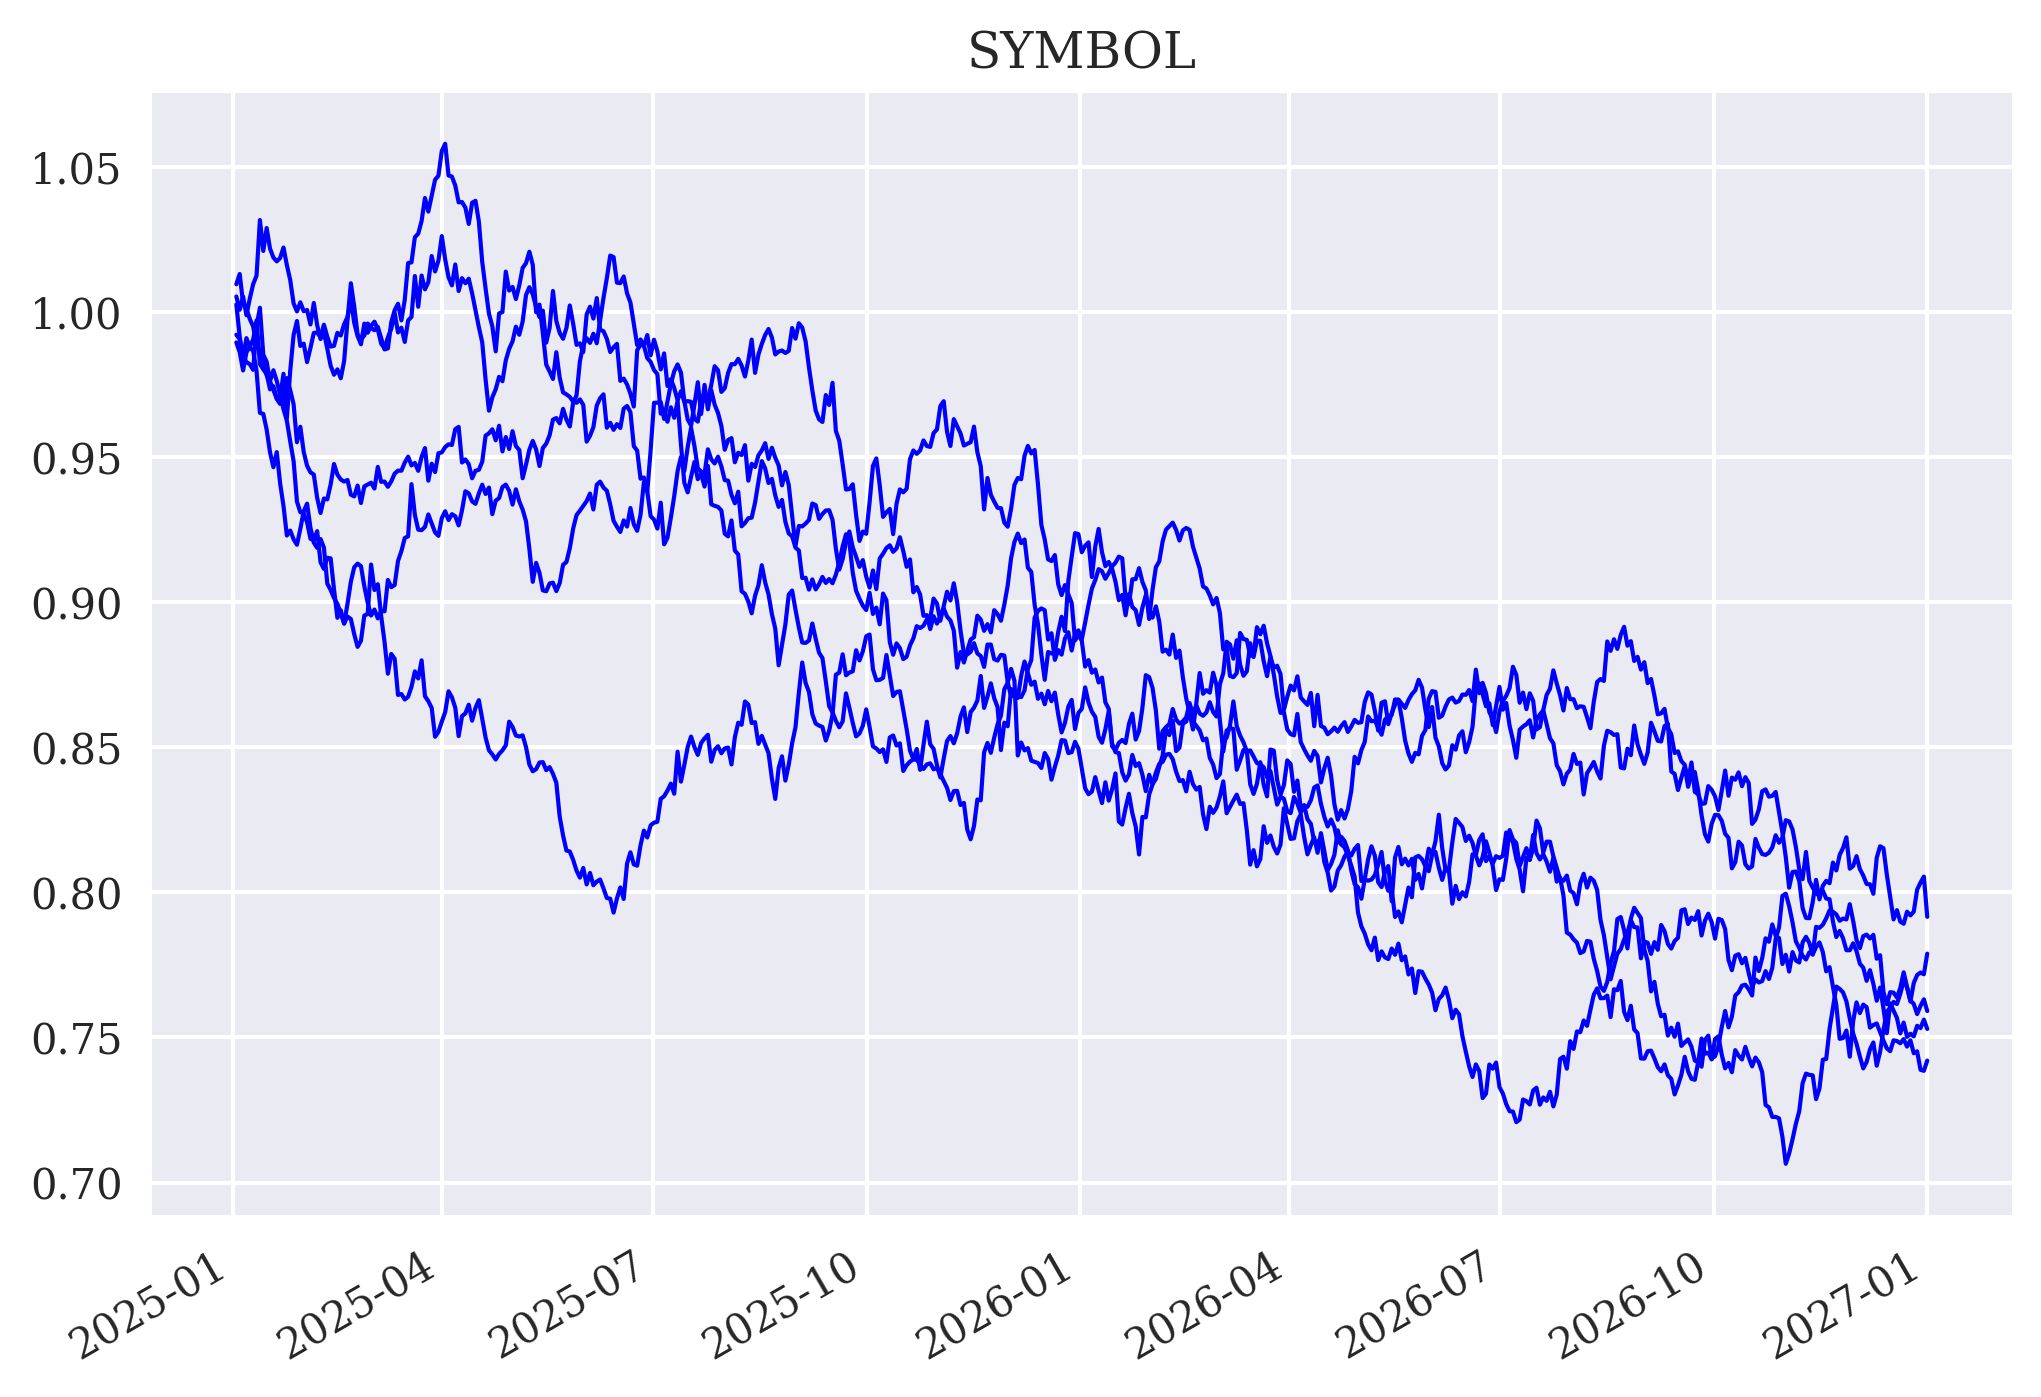

In [15]:
#@title 🧙‍♂️ Simulation for the future
from simulation import Simulation


simulation = Simulation('SYMBOL', 'r', 4, '2025-1-1', '2027-1-1',
                2 * 252, min_accuracy=0.5, x0=1, kappa=1,
                theta=0.75, sigma=0.1, new=True, normalize=True)

for _ in range(5):
    simulation.reset()
    simulation.data[simulation.symbol].plot(title=simulation.symbol,
                                           lw=1.0, c='b');

In [18]:
#@title 🔮 Teach DQLAgent based on the simulation

N_STEPS = 1 #@param {type:'integer'}


agent = DQLAgent(simulation.symbol, simulation.feature, simulation.n_features, simulation)

%time agent.learn(N_STEPS)

agent.test(5)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 

In [19]:
#@title ⚖️ Create a Trading class

class ActionSpace:
    def sample(self):
        return random.randint(0, 1)

class Trading:
    def __init__(self, symbol, features, window, lags,
                 start, end, periods,
                 x0=100, kappa=1, theta=100, sigma=0.2,
                 leverage=1, min_accuracy=0.5, min_performance=0.85,
                 mu=None, std=None,
                 new=True, normalize=True):
        self.symbol = symbol
        self.features = features
        self.n_features = len(features)
        self.window = window
        self.lags = lags
        self.start = start
        self.end = end
        self.periods = periods
        self.x0 = x0
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.leverage = leverage
        self.min_accuracy = min_accuracy
        self.min_performance = min_performance
        self.start = start
        self.end = end
        self.mu = mu
        self.std = std
        self.new = new
        self.normalize = normalize
        self.action_space = ActionSpace()
        self._simulate_data()
        self._prepare_data()

    def _simulate_data(self):
        index = pd.date_range(start=self.start,
                    end=self.end, periods=self.periods)
        s = [self.x0]
        dt = (index[-1] - index[0]).days / 365 / self.periods
        for t in range(1, len(index)):
            s_ = (s[t - 1] + self.kappa * (self.theta - s[t - 1]) * dt +
              s[t - 1] * self.sigma * math.sqrt(dt) *
                random.gauss(0, 1))
            s.append(s_)
        self.data = pd.DataFrame(s, columns=[self.symbol], index=index)

    def _prepare_data(self):
        self.data['r'] = np.log(self.data / self.data.shift(1))
        self.data.dropna(inplace=True)
        # additional features
        if self.window > 0:
            self.data['SMA'] = self.data[
                self.symbol].rolling(self.window).mean()
            self.data['DEL'] = self.data[
                self.symbol] - self.data['SMA']
            self.data['MIN'] = self.data[
                self.symbol].rolling(self.window).min()
            self.data['MAX'] = self.data[
                self.symbol].rolling(self.window).max()
            self.data['MOM'] = self.data['r'].rolling(
                self.window).mean()
            # add more features here
            self.data.dropna(inplace=True)
        if self.normalize:
            if self.mu is None or self.std is None:
                self.mu = self.data.mean()
                self.std = self.data.std()
            self.data_ = (self.data - self.mu) / self.std
        else:
            self.data_ = self.data.copy()
        self.data['d'] = np.where(self.data['r'] > 0, 1, 0)
        self.data['d'] = self.data['d'].astype(int)

    def _get_state(self):
        return self.data_[self.features].iloc[self.bar -
                                self.lags:self.bar]
    def seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_random_seed(seed)
    def reset(self):
        if self.new:
            self._simulate_data()
            self._prepare_data()
        self.treward = 0
        self.accuracy = 0
        self.actions = list()
        self.returns = list()
        self.performance = 1
        self.bar = self.lags
        state = self._get_state()
        return state.values, {}

    def step(self, action):
        correct = action == self.data['d'].iloc[self.bar]
        ret = self.data['r'].iloc[self.bar] * self.leverage
        reward_ = 1 if correct else 0
        pl = abs(ret) if correct else -abs(ret)
        reward = reward_
        # alternative options:
        # reward = pl  # only the P&L in log returns
        # reward = reward_ + 10 * pl  # the reward + the scaled P&L
        self.treward += reward
        self.bar += 1
        self.accuracy = self.treward / (self.bar - self.lags)
        self.performance *= math.exp(pl)
        if self.bar >= len(self.data):
            done = True
        elif reward_ == 1:
            done = False
        elif (self.accuracy < self.min_accuracy and
              self.bar > self.lags + 15):
            done = True
        elif (self.performance < self.min_performance and
              self.bar > self.lags + 15):
            done = True
        else:
            done = False
        state = self._get_state()
        return state.values, reward, done, False, {}

symbol = 'SYMBOL'

trading = Trading(symbol, [symbol, 'r', 'DEL'], window=10, lags=5,
            start='2024-1-1', end='2026-1-1', periods=504,
            x0=100, kappa=2, theta=300, sigma=0.1, normalize=False)

random.seed(750)

trading.reset()


(array([[115.90591443,   0.01926915,   6.89239862],
        [117.17850569,   0.01091968,   6.5901155 ],
        [118.79489427,   0.01369997,   6.65876779],
        [120.63380354,   0.01536111,   6.92684742],
        [121.81132396,   0.00971378,   6.65768164]]),
 {})

In [20]:
#@title ⚖️ `Trading.data` info
trading.data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 494 entries, 2024-01-15 12:47:14.194831014 to 2026-01-01 00:00:00
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SYMBOL  494 non-null    float64
 1   r       494 non-null    float64
 2   SMA     494 non-null    float64
 3   DEL     494 non-null    float64
 4   MIN     494 non-null    float64
 5   MAX     494 non-null    float64
 6   MOM     494 non-null    float64
 7   d       494 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 34.7 KB


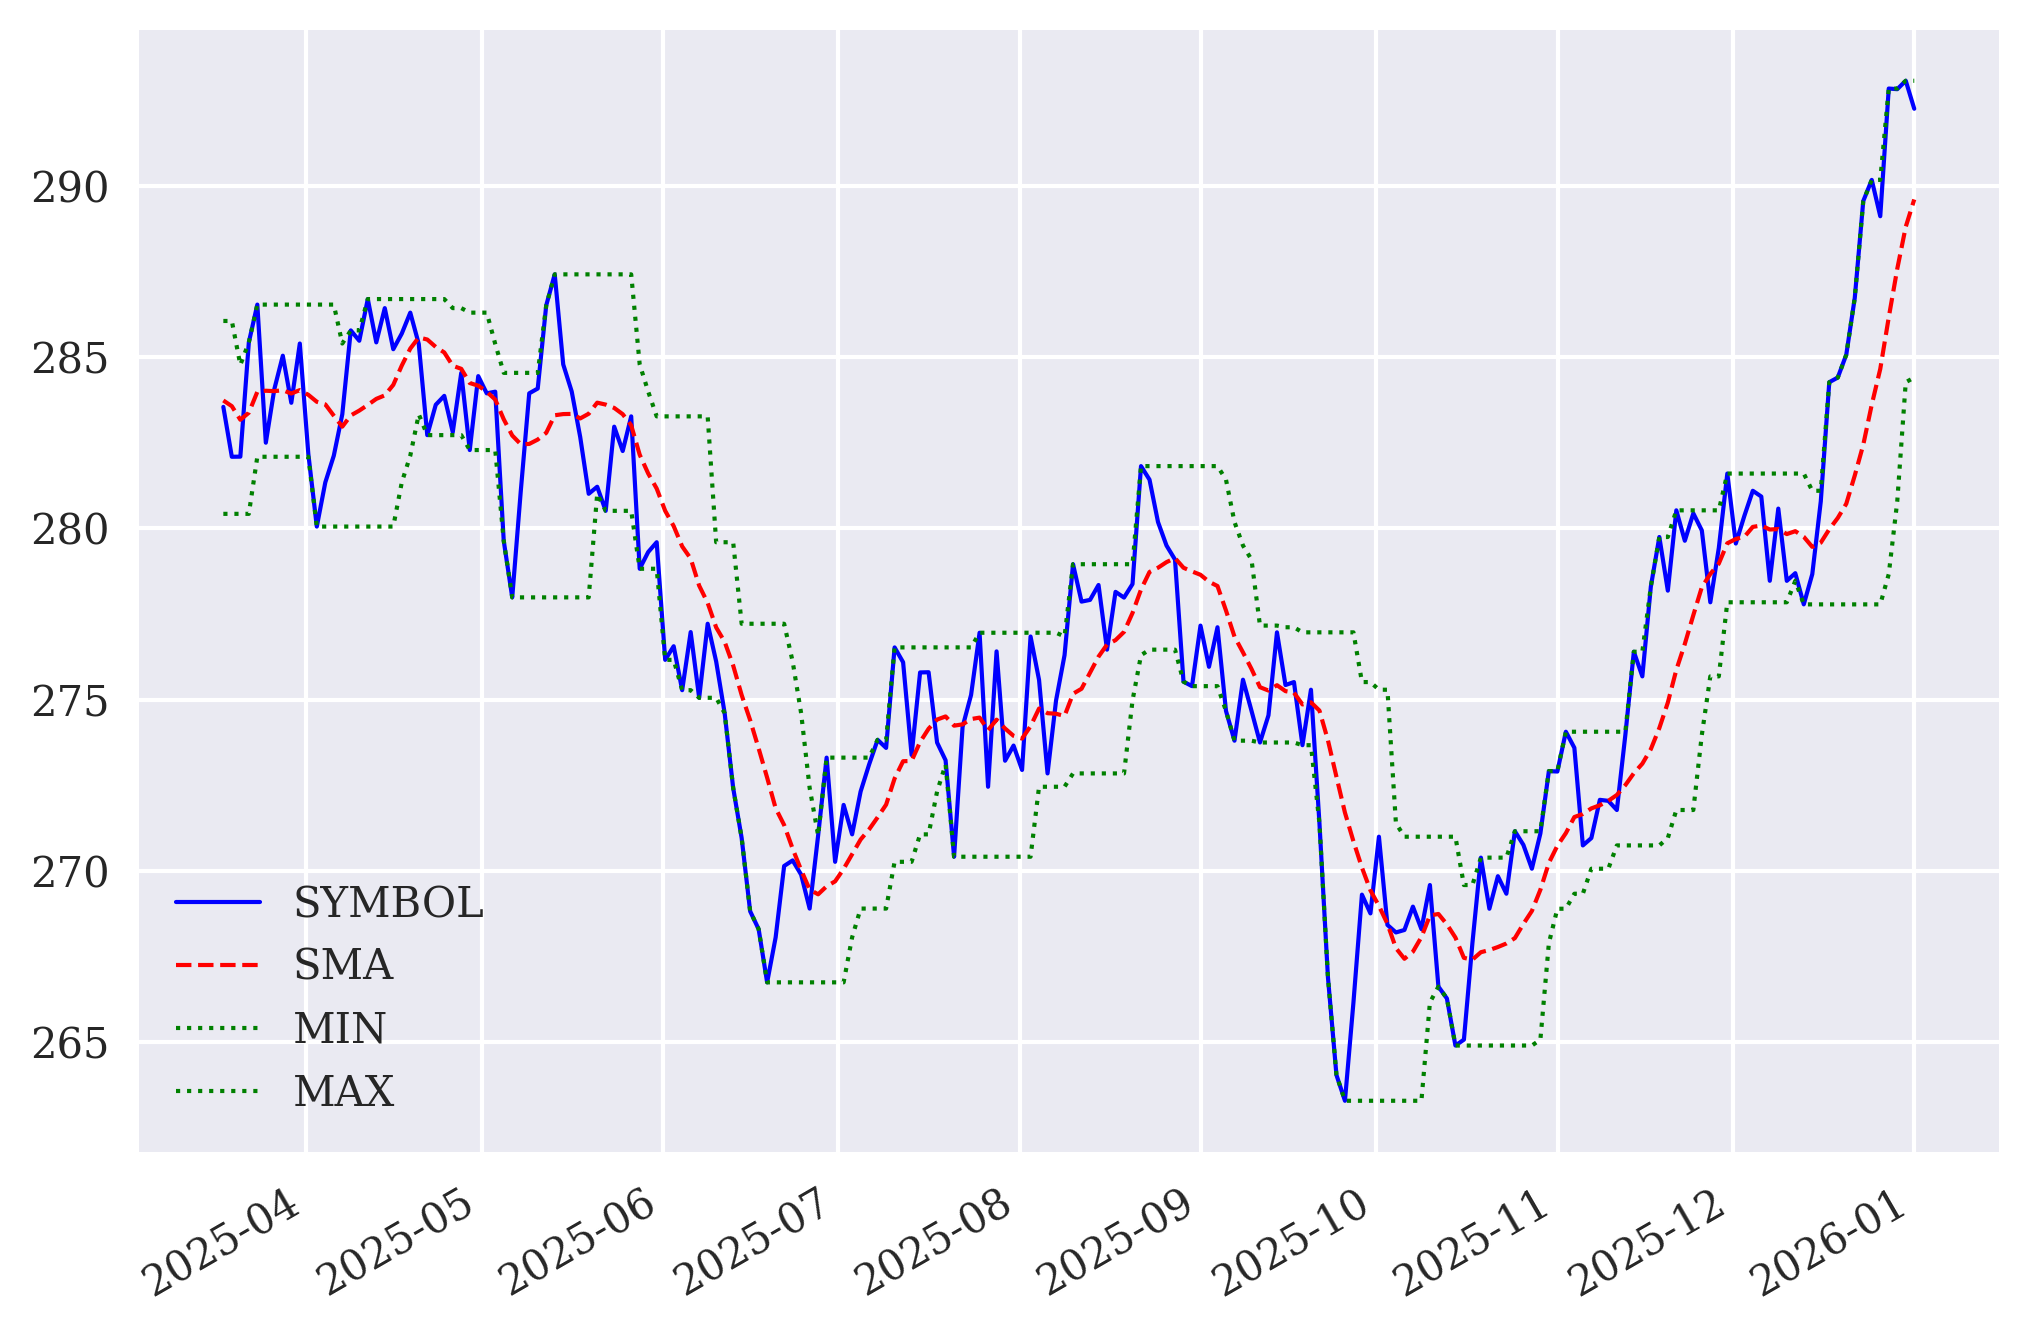

In [21]:
#@title ⚟ Plot SMA / MIN/ MAX
trading.data.iloc[-200:][[trading.symbol, 'SMA', 'MIN', 'MAX']].plot(style=['b-', 'r--', 'g:', 'g:'], lw=1.0);

In [25]:
#@title 🥷 Setup TradingAgent and test it

class TradingAgent(DQLAgent):
    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, input_dim=
            self.env.lags * self.env.n_features,
                        activation='relu'))
        self.model.add(Flatten())
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(2, activation='linear'))
        self.model.compile(loss='mse',
            optimizer=opt(learning_rate=lr))


trading = Trading(symbol, ['r', 'DEL', 'MOM'], window=10, lags=8,
            start='2024-1-1', end='2026-1-1', periods=2 * 252,
            x0=100, kappa=2, theta=50, sigma=0.1,
            leverage=1, min_accuracy=0.5, min_performance=0.85,
            new=True, normalize=True)

tradingagent = TradingAgent(trading.symbol, trading.features,
                 trading.n_features, trading, hu=24, lr=0.0001)

%time
tradingagent.test(1, min_accuracy=0.0,
           min_performance=0.0,
           verbose=True, full=False)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━

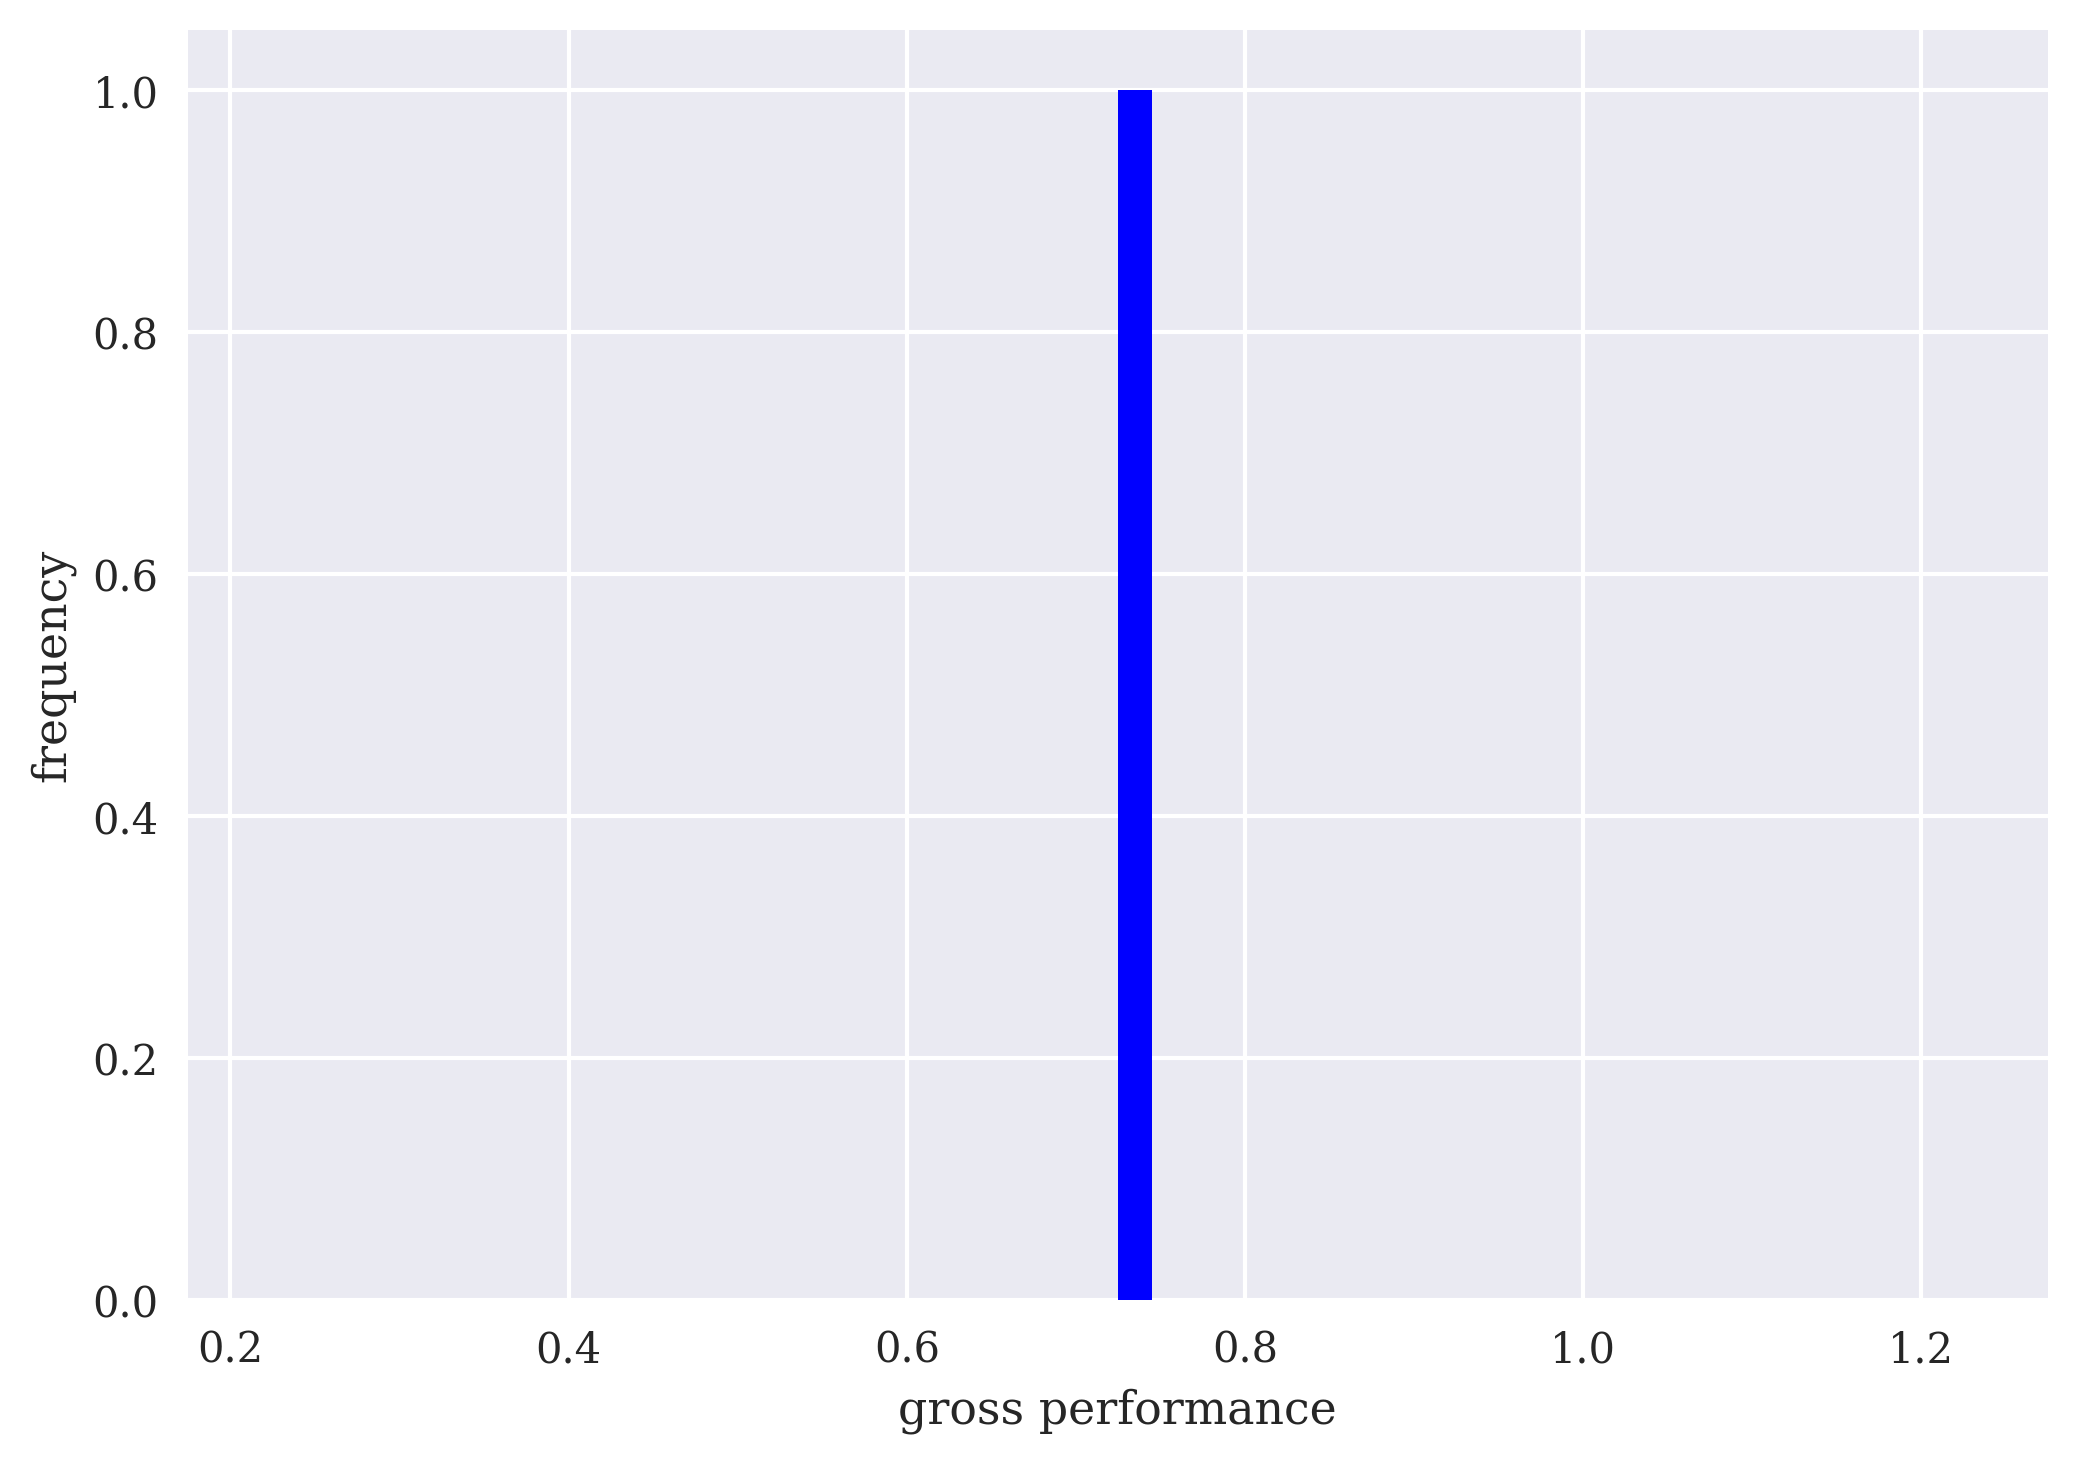

In [26]:
#@title 🪈 Performances of TradingAgent

random_performances = tradingagent.performances
sum(random_performances) / len(random_performances)

plt.hist(random_performances, bins=50, color='b')
plt.xlabel('gross performance')
plt.ylabel('frequency');

In [28]:
#@title ♻️ Re-learn and re-test the Trading Agent and plot random performances

N_STEPS=1 #@param {type:'integer'}
%time tradingagent.learn(N_STEPS)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

In [ ]:
#@title 👨‍🏫 Revalidate the model once again
%%time
tradingagent.test(50, min_accuracy=0.0,
           min_performance=0.0,
           verbose=True, full=False)

sum(tradingagent.performances) / len(tradingagent.performances)


plt.hist(random_performances, bins=30,
         color='b', label='random (left)')
plt.hist(tradingagent.performances, bins=30,
         color='r', label='trained(right)')
plt.xlabel('gross performance')
plt.ylabel('frequency')
plt.legend();

In [16]:
#@title 👨 Black Scholes model call value
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
from pylab import plt, mpl
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)
from bsm73 import bsm_call_value
S0 = 100
K = 100
T = 1.
t = 0.
r = 0.05
sigma = 0.2

print(f"Call value from Black-Scholes model: {bsm_call_value(S0, K, T, t, r, sigma)}")


Call value from Black-Scholes model: 10.450583572185565


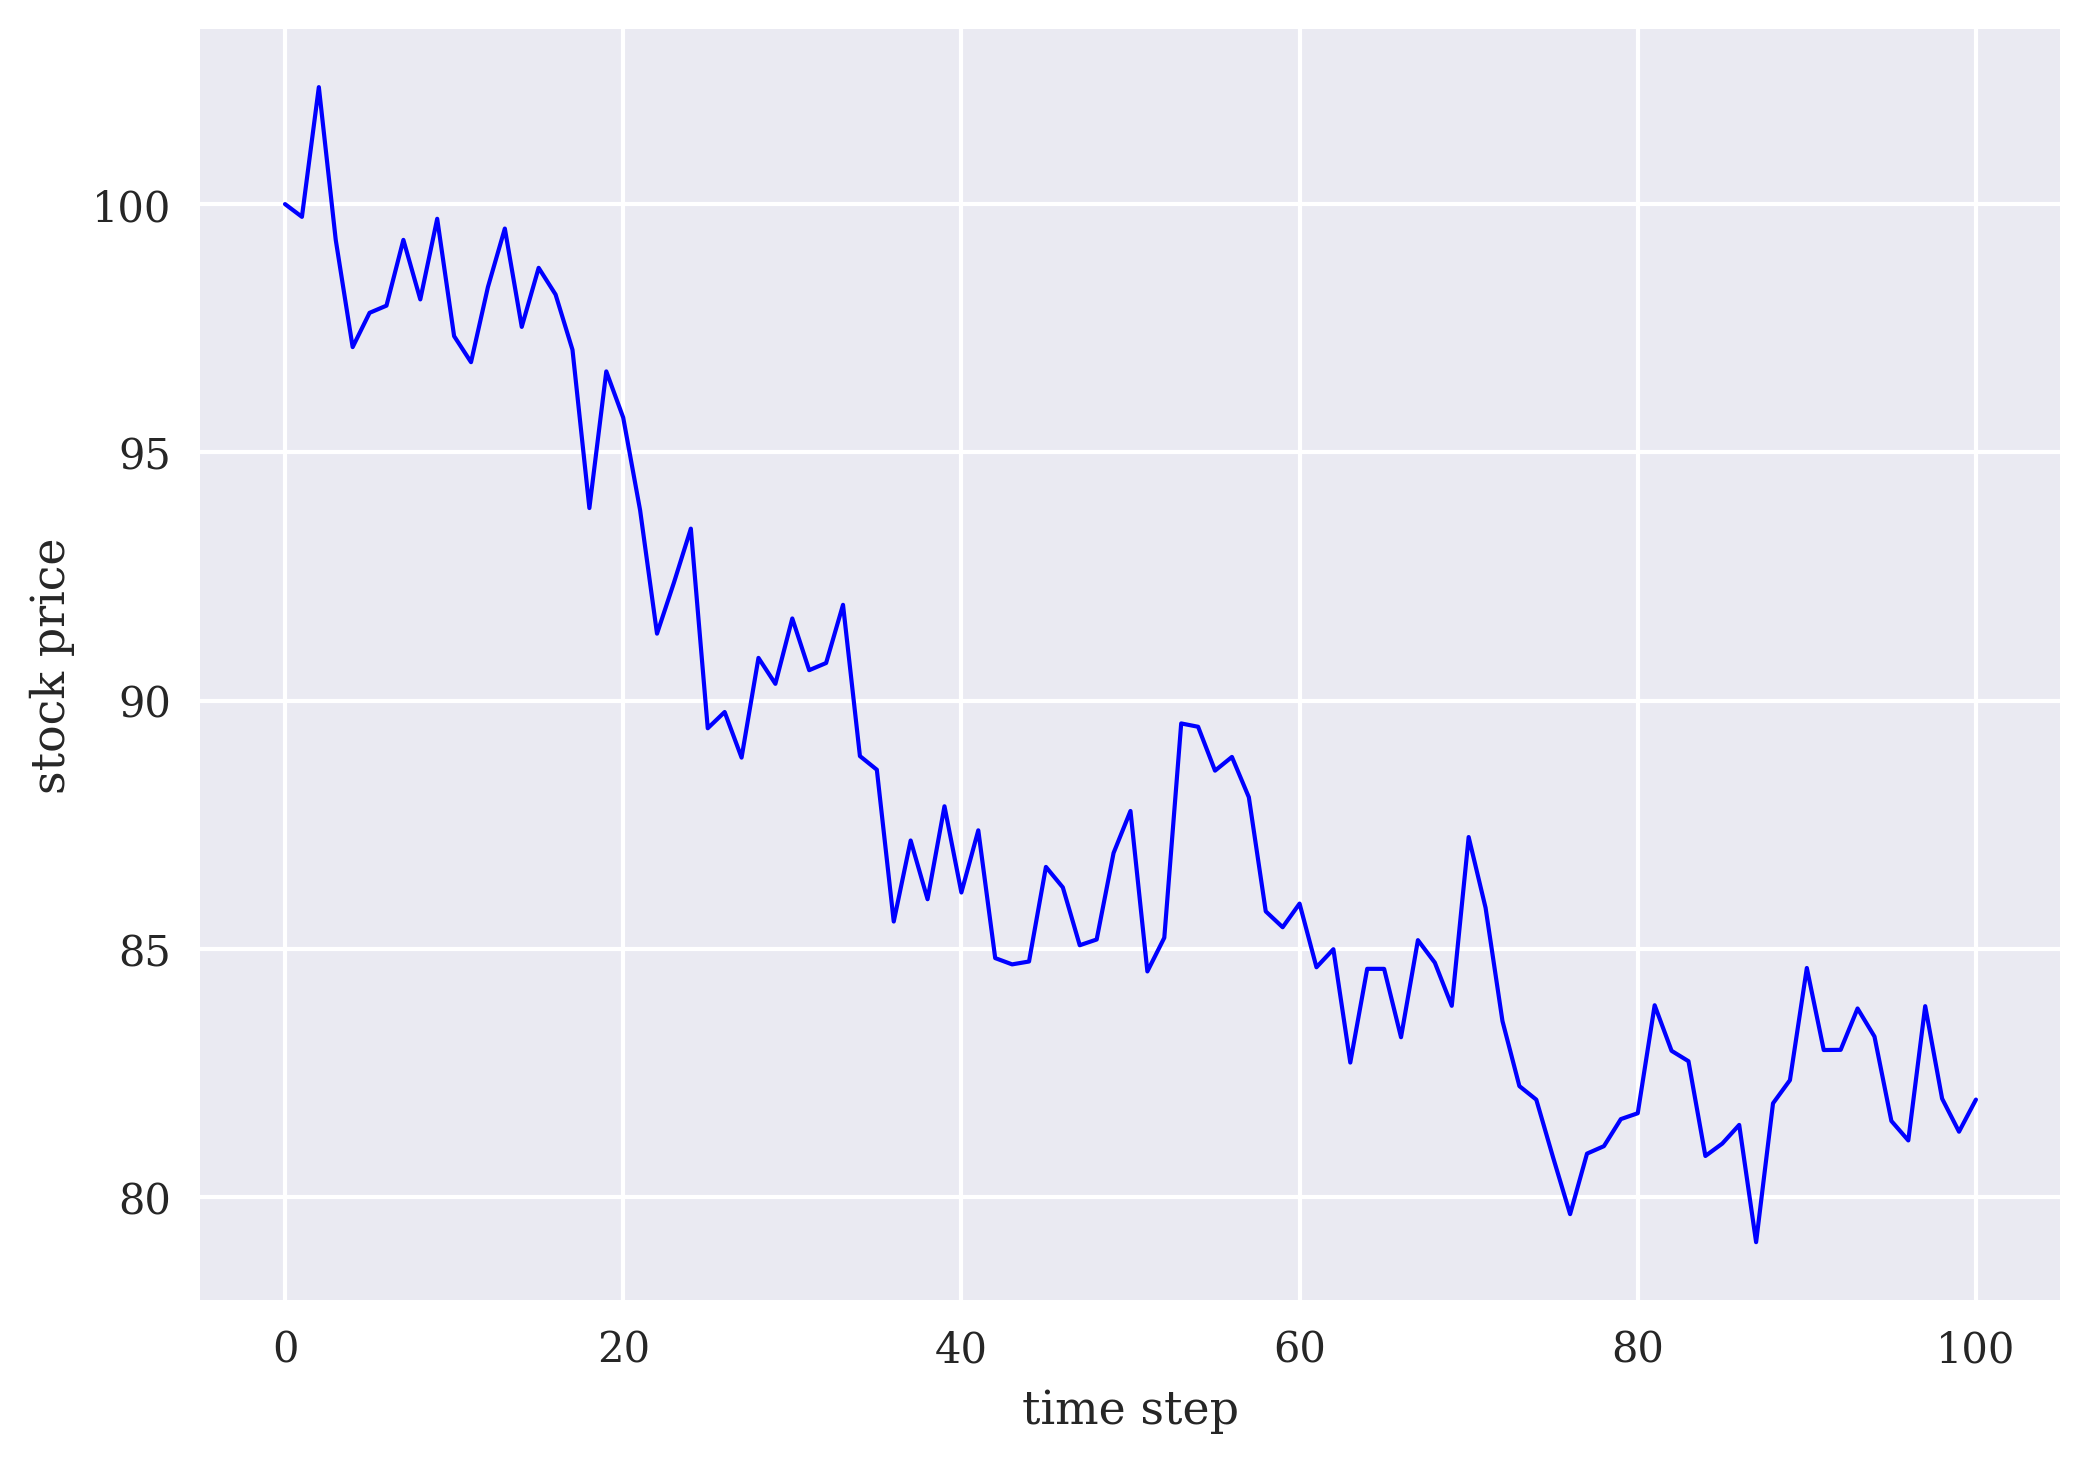

In [17]:
#@title 🎲 Simulate GBM
def simulate_gbm(S0, T, r, sigma, steps=100):
    gbm = [S0]
    dt = T / steps
    for t in range(1, steps + 1):
        st = gbm[-1] * math.exp((r - sigma ** 2 / 2) * dt
                    + sigma * math.sqrt(dt) * random.gauss(0, 1))
        gbm.append(st)
    return gbm

gbm = simulate_gbm(S0, T, r, sigma)
plt.plot(gbm, lw=1.0, c='b')
plt.xlabel('time step')
plt.ylabel('stock price');

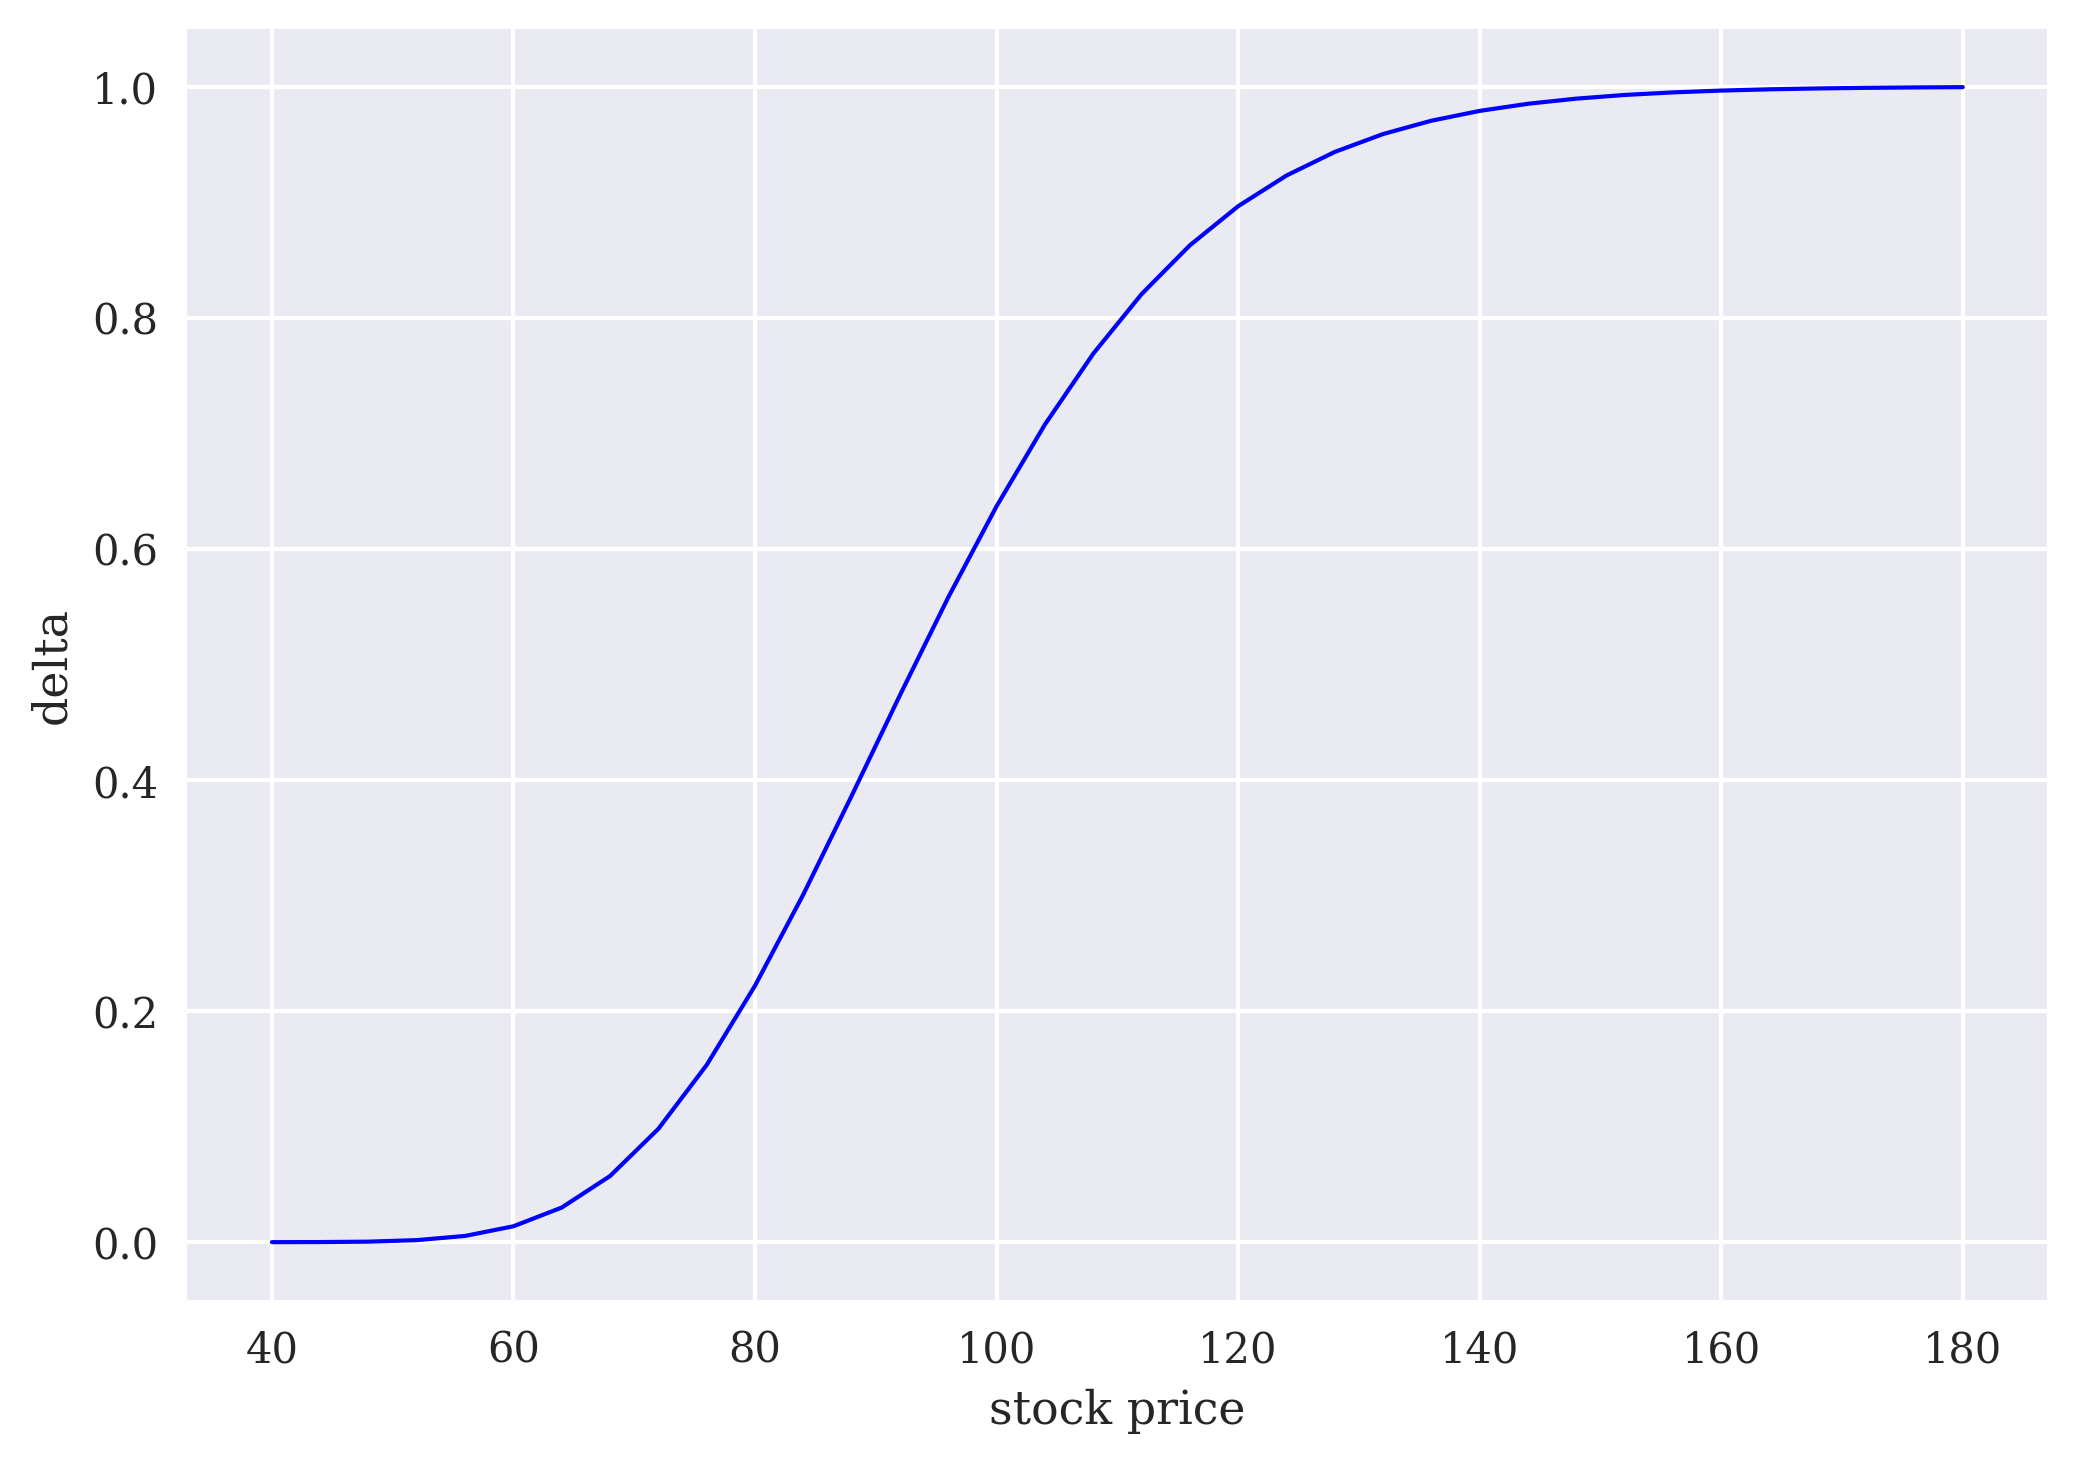

In [18]:
#@title 🔺 Calculate `bsm_delta`
def bsm_delta(St, K, T, t, r, sigma):
    d1 = ((math.log(St / K) + (r + 0.5 * sigma ** 2) * (T - t)) /
          (sigma * math.sqrt(T - t)))
    return stats.norm.cdf(d1, 0, 1)
S_ = range(40, 181, 4)
d = [bsm_delta(s, K, T, 0, r, sigma) for s in S_]
plt.plot(S_, d, lw=1.0, c='b')
plt.xlabel('stock price')
plt.ylabel('delta');

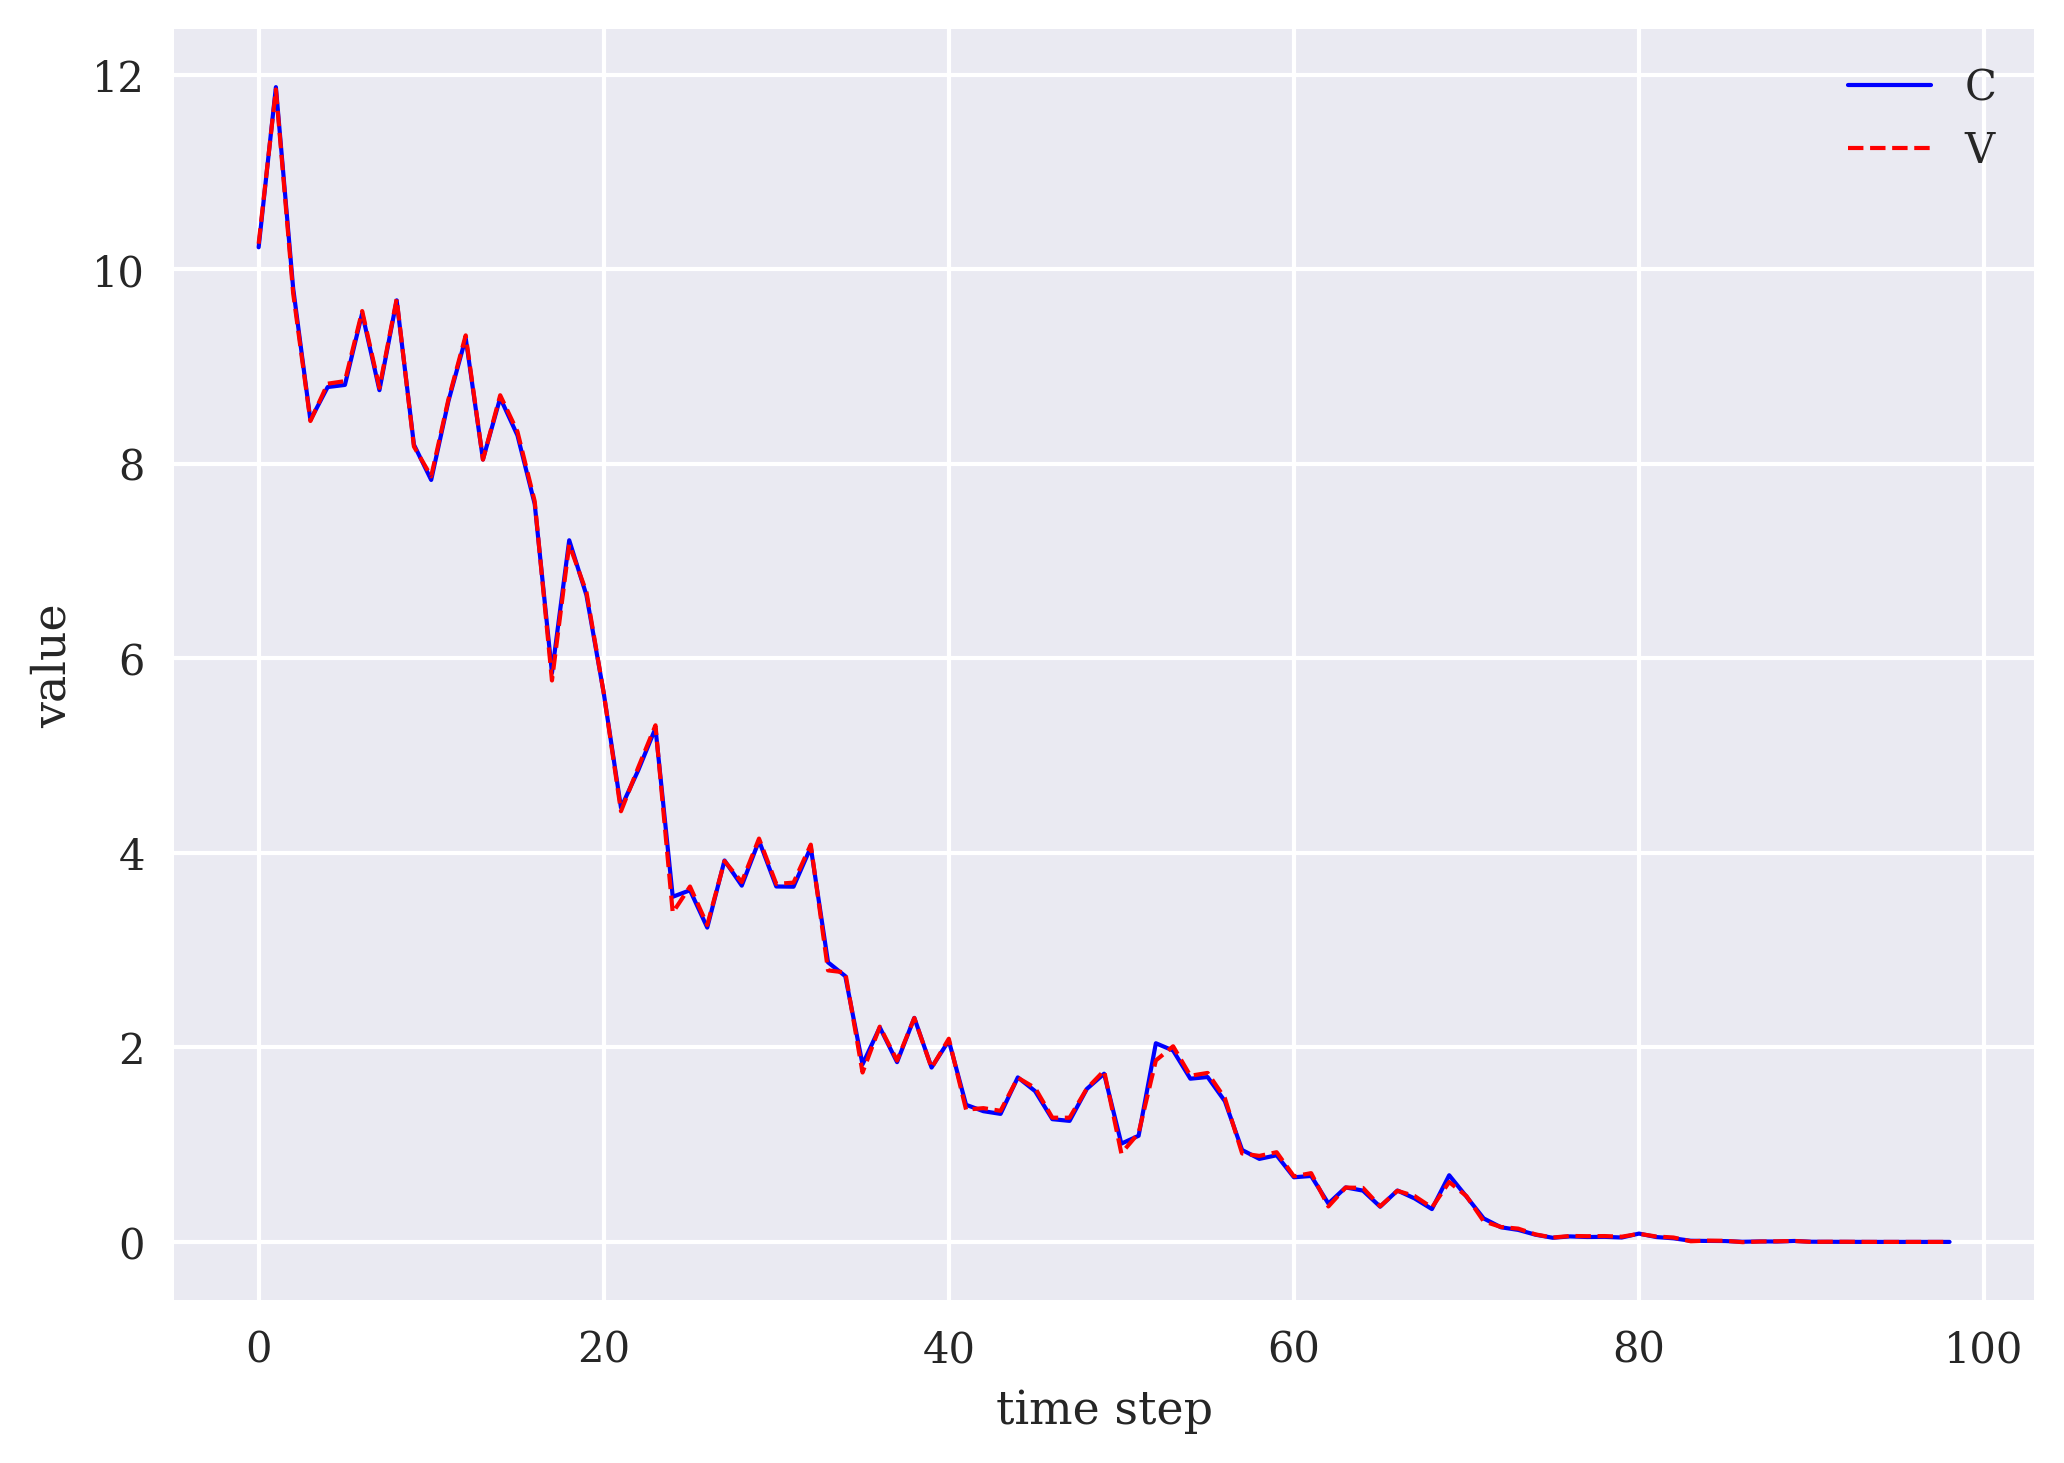

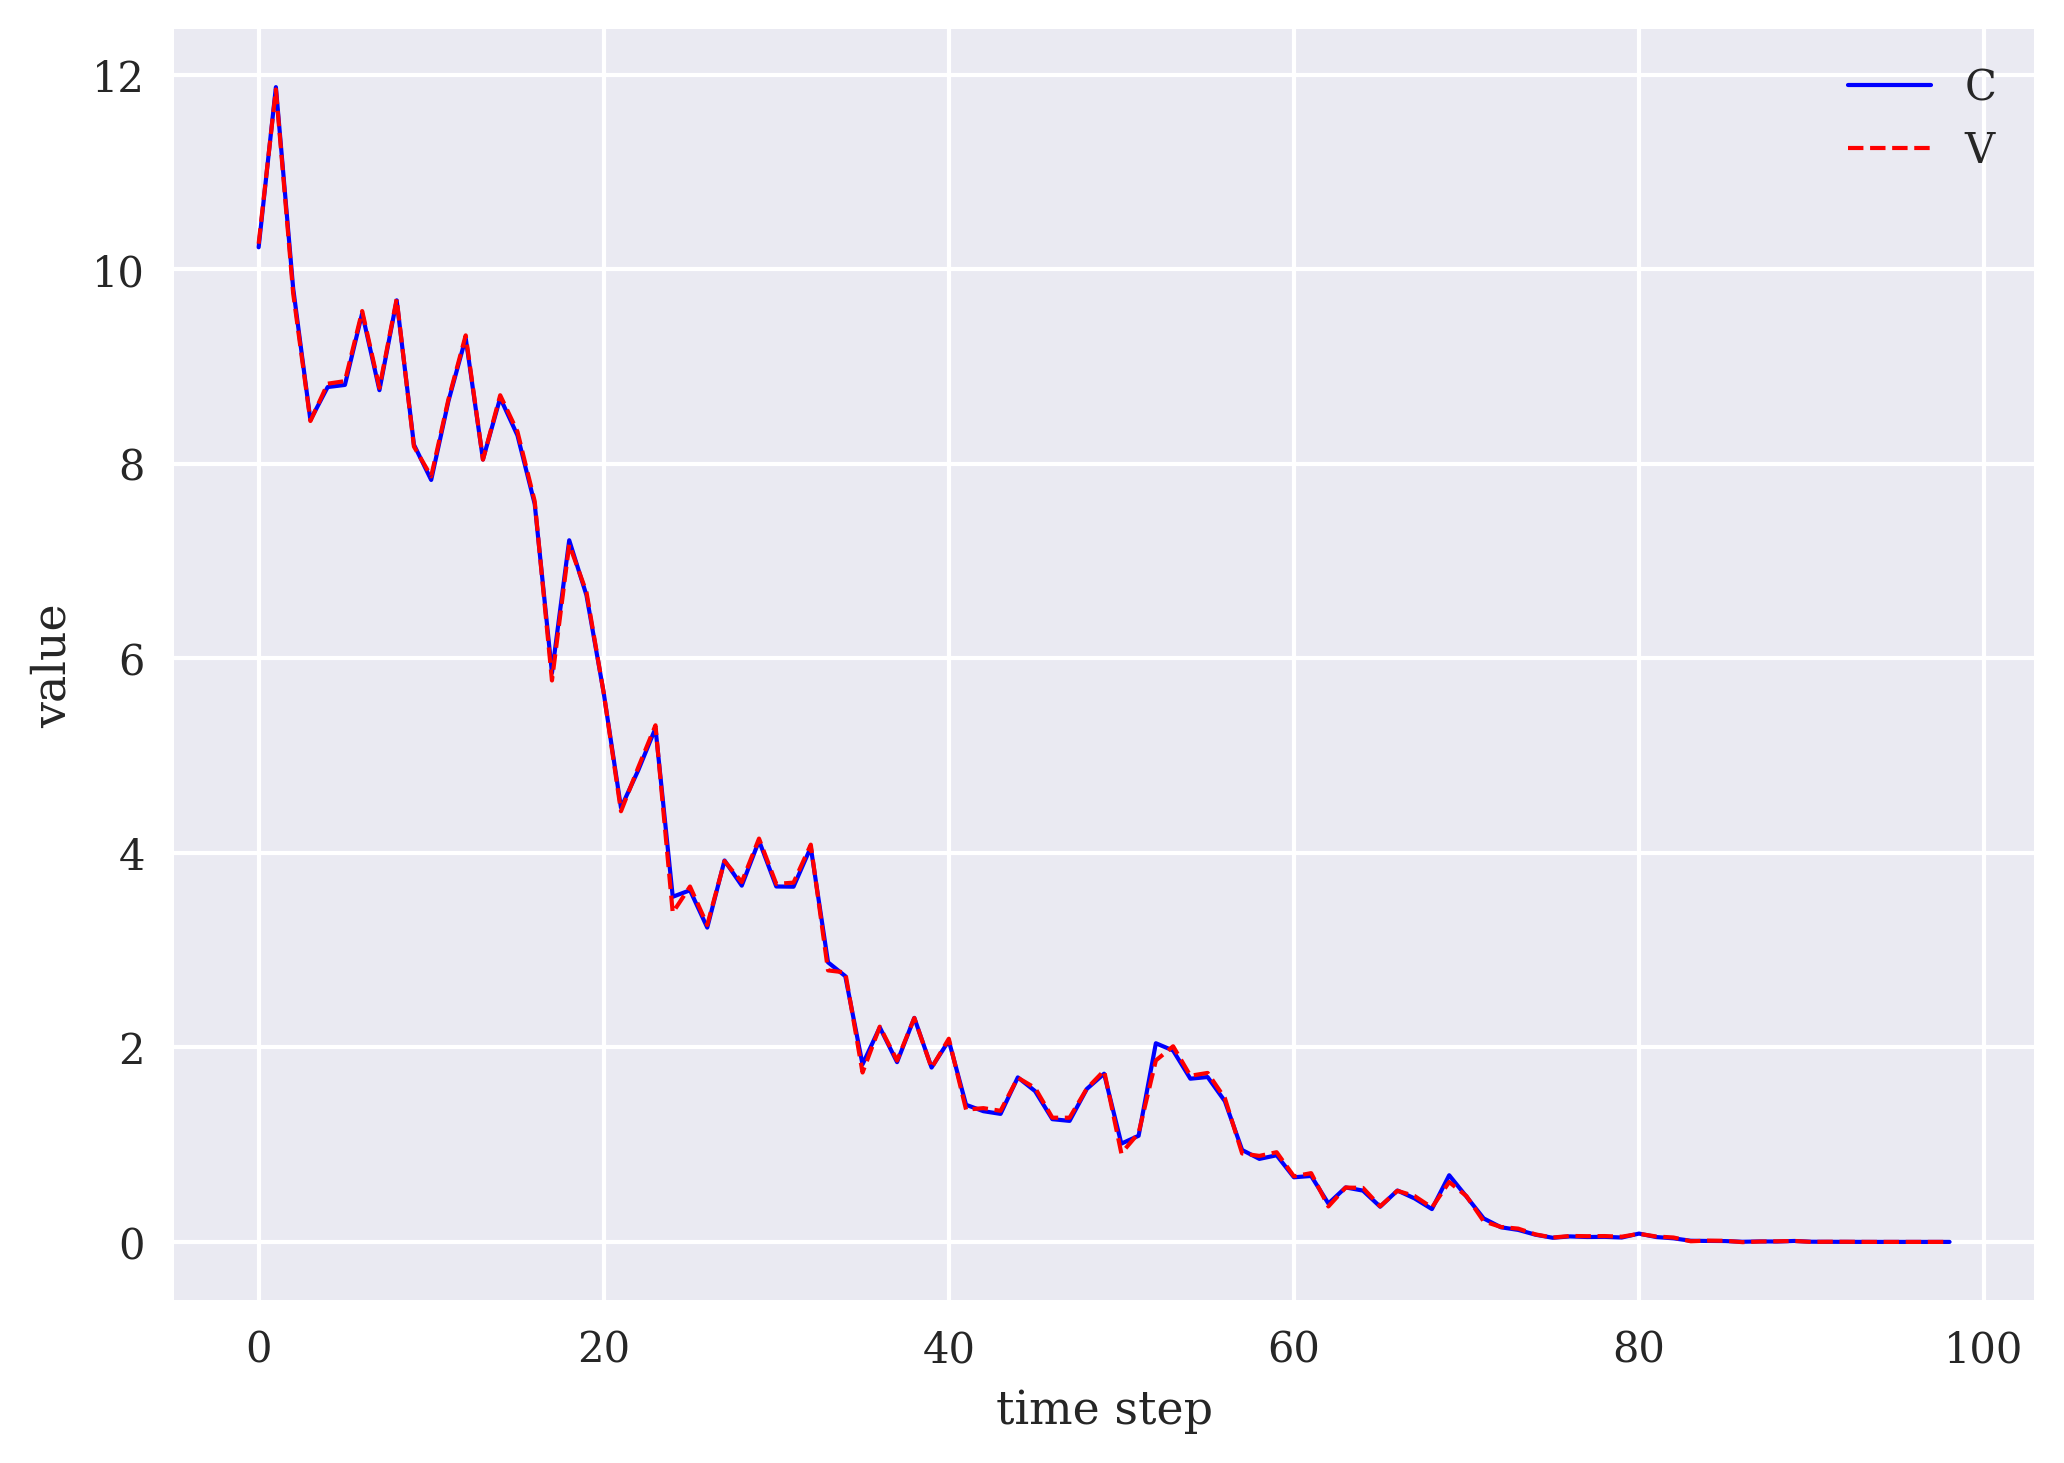

In [19]:
#@title ✖️ Option replication
dt = T / (len(gbm) - 1)
bond = [math.exp(r * i * dt) for i in range(len(gbm))]
def option_replication():
    res = pd.DataFrame()
    for i in range(len(gbm) - 1):
        C = bsm_call_value(gbm[i], K, T, i * dt, r, sigma)
        if i == 0:
            s = bsm_delta(gbm[i], K, T, i * dt, r, sigma)
            b = (C - s * gbm[i]) / bond[i]
        else:
            V = s * gbm[i] + b * bond[i]
            s = bsm_delta(gbm[i], K, T, i * dt, r, sigma)
            b = (C - s * gbm[i]) / bond[i]
            df = pd.DataFrame({'St': gbm[i], 'C': C, 'V': V,
                               's': s, 'b': b}, index=[0])
            res = pd.concat((res, df), ignore_index=True)
    return res
res = option_replication()






res[['C', 'V']].plot(style=['b', 'r--'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');
res[['C', 'V']].plot(style=['b', 'r--'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');


Mean difference: 0.002291010481212608
MSE: 0.0014618480915568664


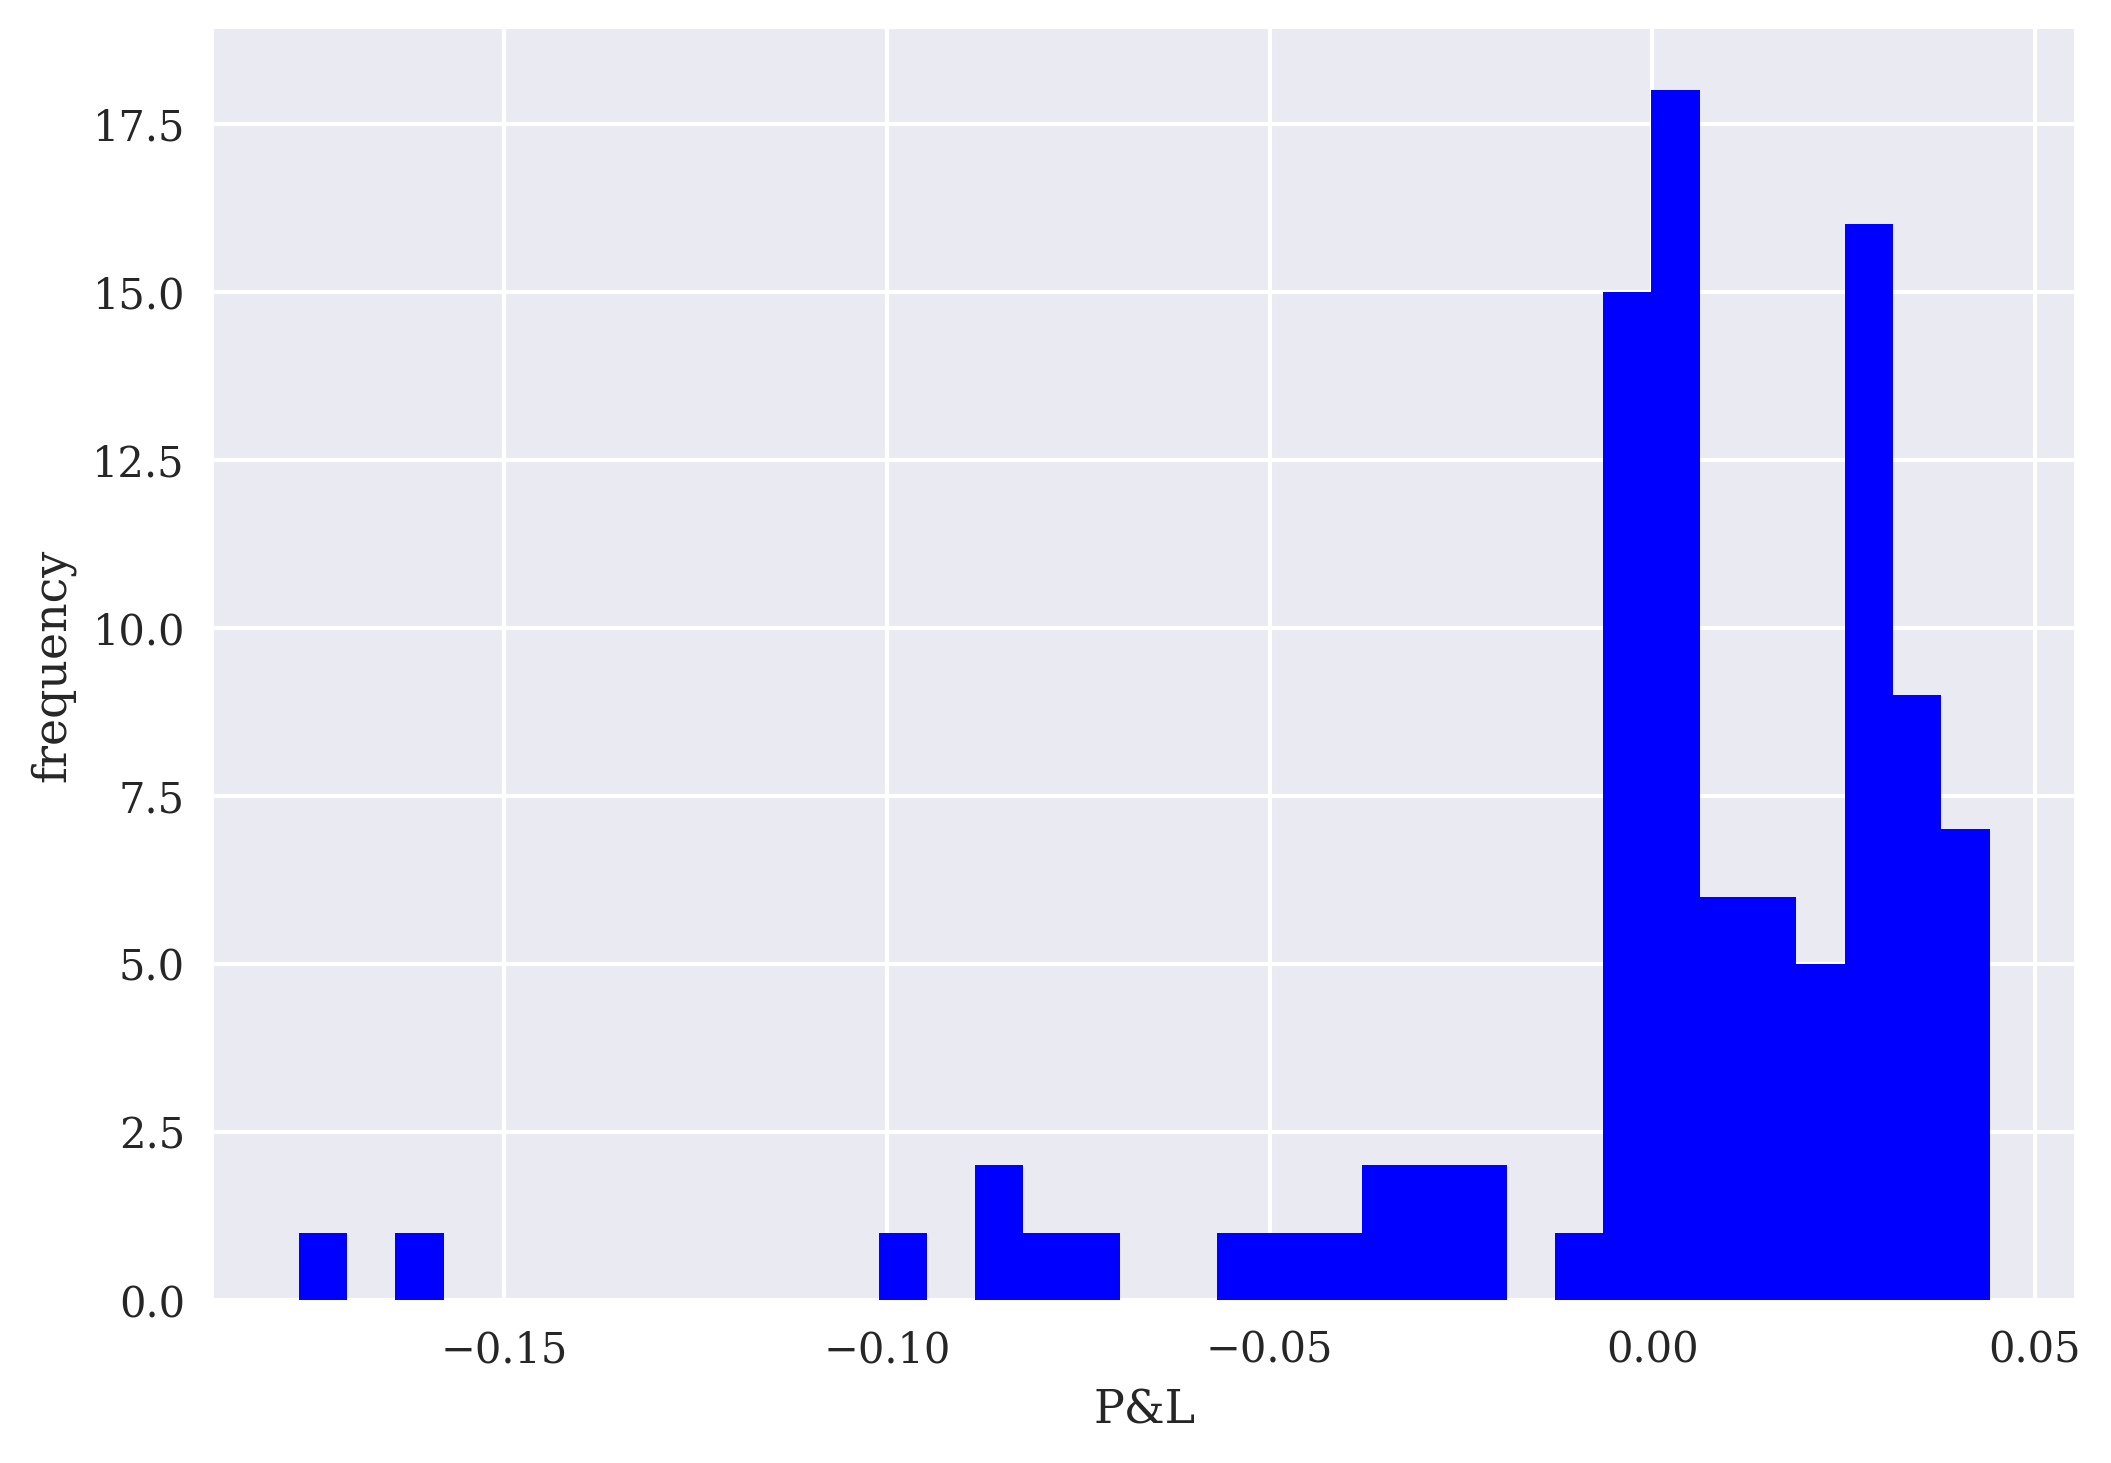

In [20]:
#@title 🖩 Calculate mean and MSE between replicated values
print(f"Mean difference: {(res['V'] - res['C']).mean()}")
print(f"MSE: {((res['V'] - res['C']) ** 2).mean()}")

(res['V'] - res['C']).hist(bins=35, color='b')
plt.xlabel('P&L')
plt.ylabel('frequency');

In [21]:
#@title 🫷 Hedging environment setup
class observation_space:
    def __init__(self, n):
        self.shape = (n,)
class action_space:
    def __init__(self, n):
        self.n = n
    def seed(self, seed):
        random.seed(seed)
    def sample(self):
        return random.random()
class Hedging:
    def __init__(self, S0, K_, T, r_, sigma_, steps):
        self.initial_value = S0
        self.strike_ = K_
        self.maturity = T
        self.short_rate_ = r_
        self.volatility_ = sigma_
        self.steps = steps
        self.observation_space = observation_space(5)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self._simulate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0
class Hedging(Hedging):
    def _simulate_data(self):
        s = [self.initial_value]
        self.strike = random.choice(self.strike_)
        self.short_rate = random.choice(self.short_rate_)
        self.volatility = random.choice(self.volatility_)
        self.dt = self.maturity / self.steps
        for t in range(1, self.steps + 1):
            st = s[t - 1] * math.exp(
              ((self.short_rate - self.volatility ** 2 / 2) * self.dt +
                self.volatility * math.sqrt(self.dt) *
                  random.gauss(0, 1)))
            s.append(st)
        self.data = pd.DataFrame(s, columns=['index'])
        self.data['bond'] = np.exp(self.short_rate *
                            np.arange(len(self.data)) * self.dt)
    def _get_state(self):
        St = self.data['index'].iloc[self.bar]
        Bt = self.data['bond'].iloc[self.bar]
        ttm = self.maturity - self.bar * self.dt
        if ttm > 0:
            Ct = bsm_call_value(St, self.strike,
                           self.maturity, self.bar * self.dt,
                           self.short_rate, self.volatility)
        else:
            Ct = max(St - self.strike, 0)
        return np.array([St, Bt, ttm, Ct, self.strike, self.short_rate,
                         self.stock, self.bond]), {}
    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)
    def reset(self):
        self.bar = 0
        self.bond = 0
        self.stock = 0
        self.treward = 0
        self.episode += 1
        self._simulate_data()
        self.state, _ = self._get_state()
        return self.state, _
    def step(self, action):
        if self.bar == 0:
            reward = 0
            self.bar += 1
            self.stock = float(action)
            self.bond = ((self.state[3] - self.stock * self.state[0]) /
                         self.state[1])
            self.new_state, _ = self._get_state()
        else:
            self.bar += 1
            self.new_state, _ = self._get_state()
            phi_value = (self.stock * self.new_state[0] +
                   self.bond * self.new_state[1])
            pl = phi_value - self.new_state[3]
            df = pd.DataFrame({'e': self.episode, 's': self.stock,
                               'b': self.bond, 'phi': phi_value,
                               'C': self.new_state[3], 'p&l[$]': pl,
                               'p&l[%]': pl / max(self.new_state[3],
                                                  1e-4) * 100,
                               'St': self.new_state[0],
                               'Bt': self.new_state[1],
                               'K': self.strike, 'r': self.short_rate,
                               'sigma': self.volatility},
                              index=[0])
            self.portfolios = pd.concat((self.portfolios, df),
                                        ignore_index=True)
            reward = -(phi_value - self.new_state[3]) ** 2
            self.stock = float(action)
            self.bond = ((self.new_state[3] -
                          self.stock * self.new_state[0]) /
                          self.new_state[1])
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, float(reward), done, False, {}

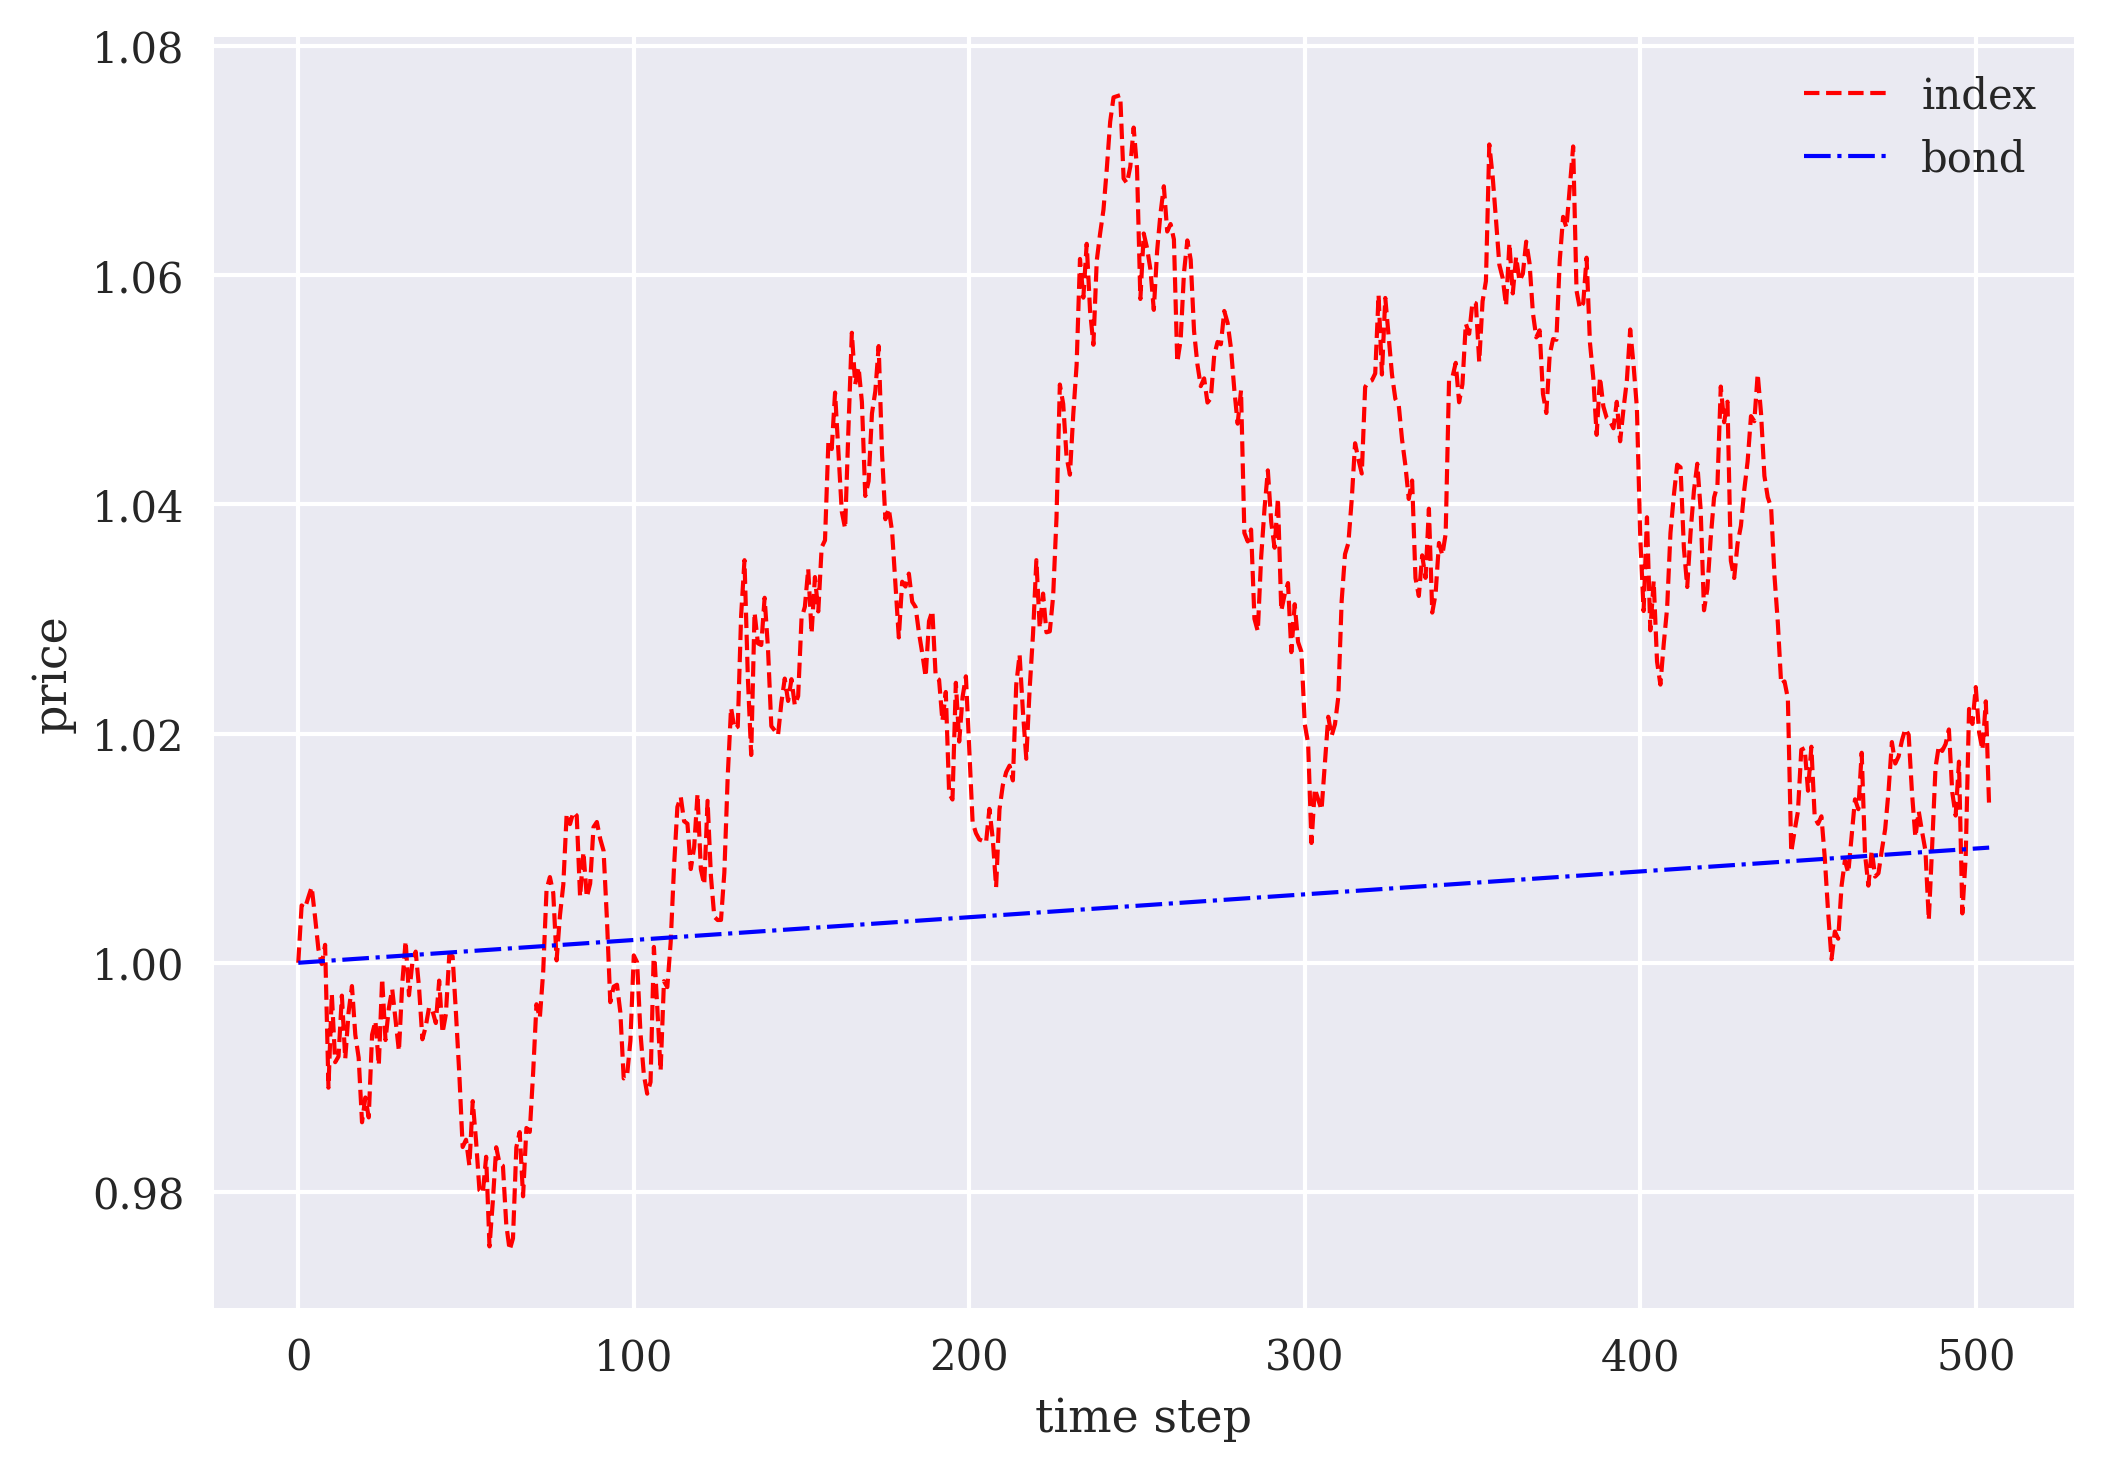

In [22]:
#@title 📭 Index and bond comparison
S0 = 100.
hedging = Hedging(S0=S0,
              K_=np.array([0.9, 0.95, 1., 1.05, 1.10]) * S0,
              T=1.0, r_=[0, 0.01, 0.05],
              sigma_=[0.1, 0.15, 0.2], steps=2 * 252)
hedging.seed(750)
hedging._simulate_data()
(hedging.data / hedging.data.iloc[0]).plot(
    lw=1.0, style=['r--', 'b-.'])
plt.xlabel('time step')
plt.ylabel('price');

e       s        b     phi       C  p&l[$]  p&l[%]        St   Bt      K  \
0  1  0.2678 -22.4876  3.8871  3.7649  0.1222  3.2447   98.4880  1.0  110.0   
1  1  0.5623 -51.6103  4.7116  4.3306  0.3809  8.7957  100.1716  1.0  110.0   
2  1  0.5996 -55.7307  4.3350  4.3258  0.0092  0.2131  100.1789  1.0  110.0   
3  1  0.8360 -79.4251  4.7708  4.5103  0.2605  5.7760  100.7111  1.0  110.0   
4  1  0.0274   1.7478  4.5084  4.4776  0.0308  0.6877  100.6422  1.0  110.0   

   r  sigma  
0  0    0.2  
1  0    0.2  
2  0    0.2  
3  0    0.2  
4  0    0.2

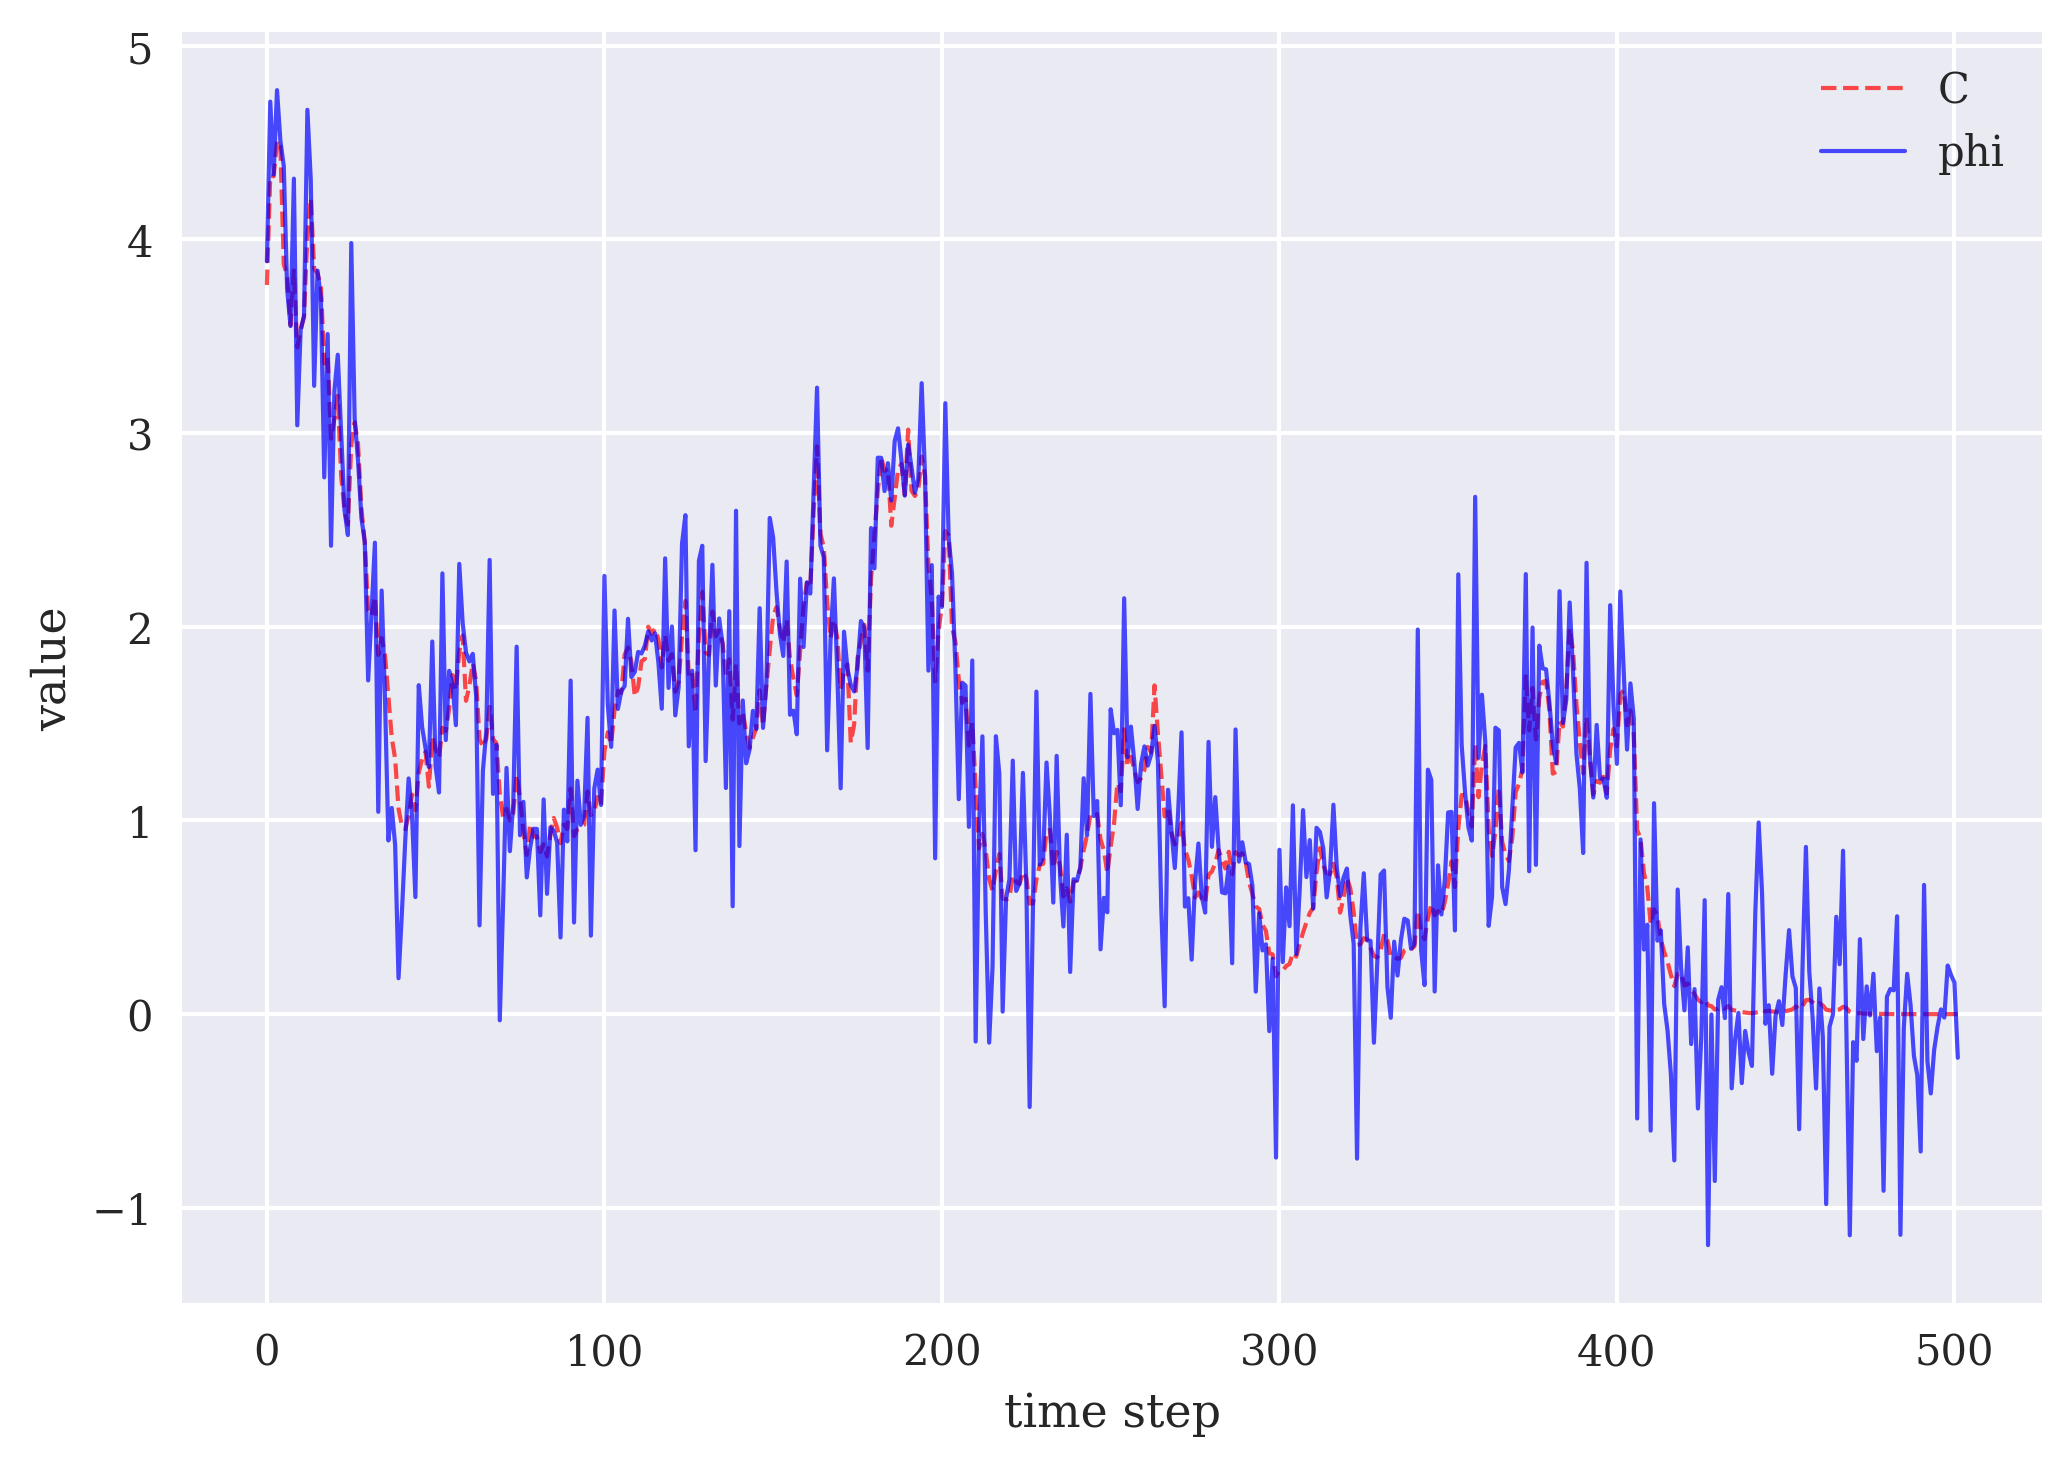

In [23]:
#@title 🖼️Hedging and C vs Phi comparison
hedging.reset()
for _ in range(hedging.steps - 1):
    hedging.step(hedging.action_space.sample())

display(hedging.portfolios.head().round(4))




hedging.portfolios[['C', 'phi']].plot(
    style=['r--', 'b-'], lw=1, alpha=0.7)
plt.xlabel('time step')
plt.ylabel('value');


Hedging portfolios P&L: 133.4348359335145


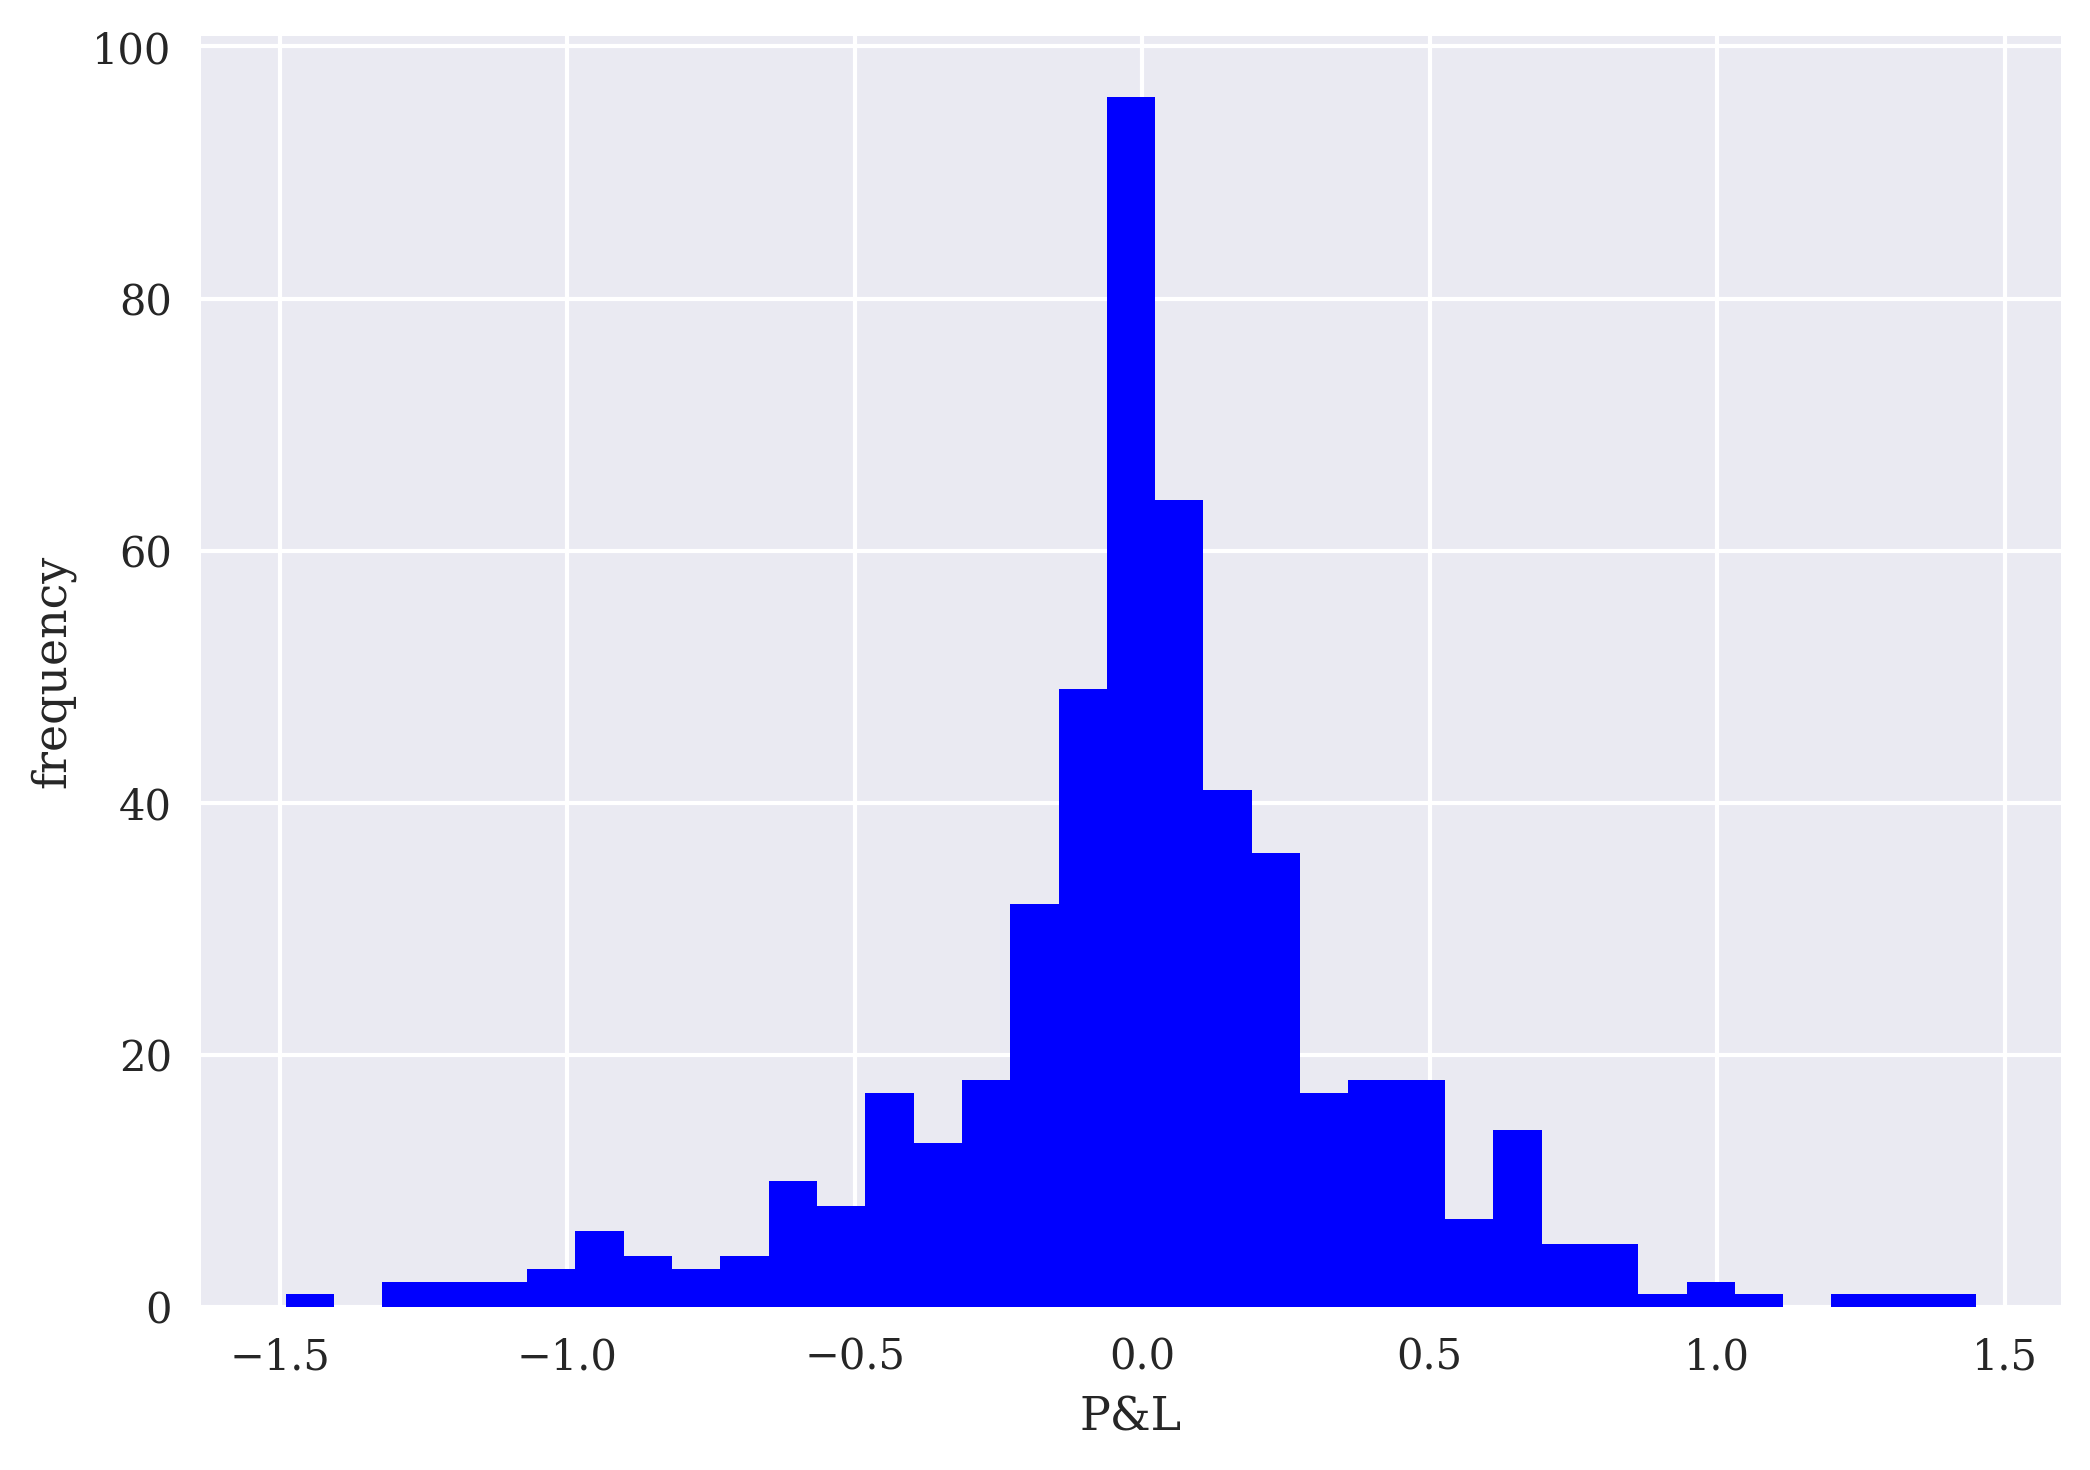

In [24]:
#@title 👛 Hedging portfolio overview
print(f"Hedging portfolios P&L: {hedging.portfolios['p&l[$]'].apply(abs).sum()}")
hedging.portfolios['p&l[$]'].hist(bins=35, color='b')
plt.xlabel('P&L')
plt.ylabel('frequency');

In [ ]:
#@title 💸 Hedging agent setup and learning

from dqlagent import *
from scipy.optimize import minimize

opt = keras.optimizers.Adam

class HedgingAgent(DQLAgent):
    def _create_model(self, hu, lr):
        self.model = Sequential()
        self.model.add(Dense(hu, input_dim=self.n_features,
                        activation='relu'))
        self.model.add(Dense(hu, activation='relu'))
        self.model.add(Dense(1, activation='linear'))
        self.model.compile(loss='mse',
                optimizer=opt(learning_rate=lr))
    def opt_action(self, state):
        bnds = [(0, 1)]
        def f(state, x):
            s = state.copy()
            s[0, 6] = x
            s[0, 7] = ((s[0, 3] - x * s[0, 0]) / s[0, 1])
            return self.model.predict(s)[0, 0]
        try:
            action = minimize(lambda x: -f(state, x), 0.5,
                              bounds=bnds, method='Powell',
                             )['x'][0]
        except:
            action = self.env.stock
        return action

    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        action = self.opt_action(state)
        return action
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            target = reward
            if not done:
                ns = next_state.copy()
                action = self.opt_action(ns)
                ns[0, 6] = action
                ns[0, 7] = ((ns[0, 3] -
                    action * ns[0, 0]) / ns[0, 1])
                target += (self.gamma *
                    self.model.predict(ns)[0, 0])
            self.model.fit(state, np.array([target]), epochs=1,
                           verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, len(self.env.data) + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f'total penalty={treward:4.2f}'
                    if verbose:
                        print(templ)
                    break

hedgingagent = HedgingAgent('SYM', feature=None, n_features=8,
                     env=hedging, hu=128, lr=0.0001)
EPISODES = 1 #@param {type:'integer'}
%time hedgingagent.learn(EPISODES)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7ebdc1e56c00>
Traceback (most recent call last):
  File "/usr/lib/python3.12/weakref.py", line 369, in remove
    def remove(k, selfref=ref(self)):

KeyboardInterrupt: 


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━

In [ ]:
#@title 🗠 Call option setup
print(f"Epsilon of the hedging agent: {hedgingagent.epsilon}")

%time hedgingagent.test(1)

n = max(hedgingagent.env.portfolios['e'])
n -= 1
display(hedgingagent.env.portfolios[hedgingagent.env.portfolios['e'] == n]['p&l[$]'].describe())

p = hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n].iloc[0][
    ['K', 'r', 'sigma']]
title = f"CALL | K={p['K']:.1f} | r={p['r']} | sigma={p['sigma']}"
hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n][
    ['phi', 'C', 'St']].iloc[:100].plot(
    secondary_y='St', title=title, style=['r-', 'b--', 'g:'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');


In [ ]:
#@title 📊 P&L Frequency
hedgingagent.env.portfolios[
    hedgingagent.env.portfolios['e'] == n]['p&l[$]'].hist(
        bins=35, color='blue')
plt.title(title)
plt.xlabel('P&L')
plt.ylabel('frequency');

In [ ]:
#@title Capital Market Line

plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

r = 0.025
beta = 0.2
sigma = 0.375
mu = r + beta * sigma

print(f"mu: {mu}")

vol = np.linspace(0, 0.5)
ret = r + beta * vol

fig, ax = plt.subplots()
plt.plot(vol, ret, 'b', label='capital market line (CML)')
plt.plot(0, r, 'g^', label='riskless asset')
plt.plot(sigma, mu, 'ro', label='market portfolio')
plt.xlabel('volatility/risk')
plt.ylabel('expected return')

ax.set_xticks((0, sigma))
ax.set_xticklabels((0, '$\sigma$',))
ax.set_yticks((0, r, mu))
ax.set_yticklabels((0, '$r$', '$\mu$'))
plt.ylim(0, 0.15)
plt.legend();



In [ ]:
#@title 🏦 Investing class setup

class observation_space:
    def __init__(self, n):
        self.shape = (n,)

class action_space:
    def __init__(self, n):
        self.n = n

    def seed(self, seed):
        random.seed(seed)

    def sample(self):
        return random.random()

class Investing:
    def __init__(self, S0, T, r_, mu_, sigma_, steps, amount):
        self.initial_value = S0
        self.maturity = T
        self.short_rate_ = r_
        self.index_drift_ = mu_
        self.volatility_ = sigma_
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

class Investing(Investing):
    def _generate_data(self):
        s = [self.initial_value]
        self.short_rate = random.choice(self.short_rate_)
        self.index_drift = random.choice(self.index_drift_)
        self.volatility = random.choice(self.volatility_)
        self.dt = self.maturity / self.steps
        for t in range(1, self.steps + 1):
            st = s[t - 1] * math.exp(
                ((self.index_drift - self.volatility ** 2 / 2) * self.dt +
                  self.volatility * math.sqrt(self.dt) * random.gauss(0, 1))
            )
            s.append(st)
        self.data = pd.DataFrame(s, columns=['Xt'])
        self.data['Yt'] = self.initial_value * np.exp(
            self.short_rate * np.arange(len(self.data)) * self.dt)
    def _get_state(self):
        Xt = self.data['Xt'].iloc[self.bar]
        Yt = self.data['Yt'].iloc[self.bar]
        return np.array([Xt, Yt, self.xt, self.yt]), {}

    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)

    def reset(self):
        self.bar = 0
        self.xt = 0
        self.yt = 0
        self.treward = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_value_new = self.initial_balance
        self.episode += 1
        self._generate_data()
        self.state, _ = self._get_state()
        return self.state, _

    def add_results(self, pl):
        df = pd.DataFrame({'e': self.episode, 'xt': self.xt,
                   'yt': self.yt, 'pv': self.portfolio_value,
                   'pv_new': self.portfolio_value_new, 'p&l[$]': pl,
                   'p&l[%]': pl / self.portfolio_value_new,
                   'Xt': self.state[0],  'Yt': self.state[1],
                   'Xt_new': self.new_state[0],
                   'Yt_new': self.new_state[1],
                   'r': self.short_rate, 'mu': self.index_drift,
                   'sigma': self.volatility}, index=[0])
        self.portfolios = pd.concat((self.portfolios, df),
                                    ignore_index=True)

    def step(self, action):
        self.bar += 1
        self.new_state, _ = self._get_state()
        if self.bar == 1:
            self.xt = action
            self.yt = (1 - action)
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = (
                self.xt * self.portfolio_value *
                self.new_state[0] / self.state[0] +
                self.yt * self.portfolio_value *
                self.new_state[1] / self.state[1])
            pl = self.portfolio_value_new - self.portfolio_value
            self.xt = action
            self.yt = (1 - action)
            self.add_results(pl)
            reward = pl
            self.portfolio_value = self.portfolio_value_new
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}



In [1]:
#@title ➡️ Asset Allocation

from dqlagent import *
from scipy.optimize import minimize

opt = keras.optimizers.Adam

S0 = 1.
investing = Investing(S0=S0, T=1.0, r_=[0.05], mu_=[0.3],
              sigma_=[0.35], steps=252, amount=1)
investing.seed(750)
investing._generate_data()
investing.data.plot(style=['g--', 'b:'], lw=1.0)
plt.xlabel('time step')
plt.ylabel('price');


ModuleNotFoundError: No module named 'dqlagent'

In [ ]:
#@title 👴 PORTFOLIO VALUE x RANDOM AGENT


investing.reset()

for _ in range(investing.steps - 1):
    investing.step(investing.action_space.sample())

investing.portfolios.head().round(3)

investing.portfolios[['Xt', 'Yt', 'pv']].plot(
    title='PORTFOLIO VALUE | RANDOM AGENT',
    style=['g--', 'b:', 'r-'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');



In [ ]:
#@title 📰 Learn and test InvestingAgent
investing = Investing(S0=S0, T=1.0, r_=[0, 0.025, 0.05],
              mu_=[0.05, 0.1, 0.15],
              sigma_=[0.1, 0.2, 0.3], steps=252, amount=1)

agent = InvestingAgent('2FS', feature=None, n_features=4,
                     env=investing, hu=128, lr=0.00025)
agent.xp = 2
agent.yp = 3
episodes = 64

%time agent.learn(episodes)
agent.epsilon
agent.env.portfolios = pd.DataFrame()
%time agent.test(10)



In [ ]:
#@title ☣️ Plot some stats for risky allocation



n = max(agent.env.portfolios['e'])
res = agent.env.portfolios[agent.env.portfolios['e'] == n]
res.head()


p = res.iloc[0][['r', 'mu', 'sigma']]
t = f"r={p['r']} | mu={p['mu']} | sigma={p['sigma']}"
res[['Xt', 'Yt', 'pv']].plot(
    title='PORTFOLIO VALUE | ' + t,
    style=['g--', 'b:', 'r-'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');

rets = res[['Xt', 'Yt', 'pv']].pct_change(
    ).mean() / agent.env.dt


stds = res[['Xt', 'Yt', 'pv']].pct_change(
    ).std() / math.sqrt(agent.env.dt)


rets[['Xt', 'pv']] / stds[['Xt', 'pv']]


res['xt'].mean()


res['xt'].std()


res['xt'].plot(title='RISKY ALLOCATION | ' + t,
               lw=1.0, c='b')
plt.ylim(res['xt'].min() - 0.1, res['xt'].max() + 0.1)
plt.xlabel('time step');

agent.env.portfolios.groupby('mu')['xt'].describe()


agent.env.portfolios.groupby('sigma')['xt'].describe()


agent.env.portfolios.groupby('mu')['pv_new'].describe()

agent.env.portfolios.groupby('sigma')['pv_new'].describe()

sigma
n = max(agent.env.portfolios['e'])
res = agent.env.portfolios[agent.env.portfolios['e'] == n]
p = res.iloc[0][['r', 'mu', 'sigma']]
t = f"r={p['r']} | mu={p['mu']} | sigma={p['sigma']}"
ax = res[['Xt', 'Yt', 'pv', 'xt']].plot(
    title='PORTFOLIO VALUE | ' + t,
    style=['g--', 'b:', 'r-', 'm-.'], lw=1,
    secondary_y='xt'
)

In [ ]:
#@title 💰 Investing class once again
class Investing(Investing):
    def __init__(self, asset_one='.SPX', asset_two='.VIX',
                 steps=252, amount=1):
        self.asset_one = asset_one
        self.asset_two = asset_two
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self.retrieved = False
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

    def _generate_data(self):
        if self.retrieved:
            pass
        else:
            url = 'https://certificate.tpq.io/rl4finance.csv'
            self.raw = pd.read_csv(url, index_col=0,
                                   parse_dates=True).dropna()
            self.retrieved = True
        self.data = pd.DataFrame()
        self.data['Xt'] = self.raw[self.asset_one]
        self.data['Yt'] = self.raw[self.asset_two]
        s = random.randint(self.steps, len(self.data))
        self.data = self.data.iloc[s-self.steps:s]
        self.data = self.data / self.data.iloc[0]
    def _get_state(self):
        Xt = self.data['Xt'].iloc[self.bar]
        Yt = self.data['Yt'].iloc[self.bar]
        self.date = self.data.index[self.bar]
        return np.array([Xt, Yt, Xt - Yt, self.xt, self.yt]), {}

    def add_results(self, pl):
        df = pd.DataFrame({
               'e': self.episode, 'date': self.date,
               'xt': self.xt, 'yt': self.yt,
               'pv': self.portfolio_value,
               'pv_new': self.portfolio_value_new, 'p&l[$]': pl,
               'p&l[%]': pl / self.portfolio_value_new * 100,
               'Xt': self.state[0],  'Yt': self.state[1],
               'Xt_new': self.new_state[0],
               'Yt_new': self.new_state[1],
                      }, index=[0])
        self.portfolios = pd.concat((self.portfolios, df),
                                    ignore_index=True)
    def step(self, action):
        self.bar += 1
        self.new_state, info = self._get_state()
        if self.bar == 1:
            self.xt = action
            self.yt = (1 - action)
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = (
                self.xt * self.portfolio_value *
                self.new_state[0] / self.state[0] +
                self.yt * self.portfolio_value *
                self.new_state[1] / self.state[1])
            pl = self.portfolio_value_new - self.portfolio_value
            pen = (self.xt - action) ** 2
            self.xt = action
            self.yt = (1 - action)
            self.add_results(pl)
            ret = self.portfolios['p&l[%]'].iloc[-1] / 100 * 252
            vol = self.portfolios['p&l[%]'].rolling(
                20, min_periods=1).std().iloc[-1] * math.sqrt(252)
            sharpe = ret / vol
            reward = sharpe - pen
            self.portfolio_value = self.portfolio_value_new
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}


In [ ]:
#@title 2️⃣ Investing Agent for 2AC
days = 2 * 252
investing = Investing(steps=days)
investing.data.head()
investing.data.corr()


investing.data.plot(secondary_y='Yt', style=['b', 'g--'], lw=1)

investing = Investing(steps=days)
agent = InvestingAgent('2AC', feature=None, n_features=5,
                     env=investing, hu=48, lr=0.0005)
agent.xp = 3
agent.yp = 4
episodes = 250

%time agent.learn(episodes)

agent.epsilon
agent.env.portfolios = pd.DataFrame()
%time agent.test(10)


agent.env.portfolios['xt'].describe()

n = max(agent.env.portfolios['e']) - 3
res = agent.env.portfolios[
        agent.env.portfolios['e'] == n].set_index('date')
res['xt'].plot(lw=1, c='b')
plt.ylim(res['xt'].min() - 0.1, res['xt'].max() + 0.1)
plt.ylabel('allocation (asset 1)');


res[['Xt', 'Yt', 'pv']].iloc[-1]

r = np.log(res[['Xt', 'Yt', 'pv']] / res[['Xt', 'Yt', 'pv']].shift(1))
rets = np.exp(r.mean() * 252) - 1
rets

stds = r.std() * math.sqrt(252)
stds

rets / stds

dtype: float64
res[['Xt', 'Yt', 'pv']].plot(
    title='PORTFOLIO VALUE',
    style=['g--', 'b:', 'r-'],
    lw=1, grid=True)
plt.ylabel('value');

values = agent.env.portfolios.groupby('e')[
        ['Xt', 'Yt', 'pv_new']].last()
values.tail()

values.mean()

((values['pv_new'] > values['Xt']) &
 (values['pv_new'] > values['Yt'])).value_counts()


agent.env.portfolios.groupby(['e'])['pv_new'].last()


In [ ]:
#@title 🛗 Three Asset case

episodes = 1 #@param {type:'integer'}
test_episodes = 1 #@param {type:'integer'}


%run assetallocation.py

days = 2 * 252

investing = Investing('.SPX', '.VIX', 'XAU=', steps=days)
investing.data.plot(lw=1, style=['g--', 'b:', 'm-.'])
plt.ylabel('price');

agent = InvestingAgent('3AC', feature=None, n_features=6,
                     env=investing, hu=128, lr=0.00025)
%time agent.learn(episodes)

print(f"Agent's epsilon: {agent.epsilon}")

agent.env.portfolios = pd.DataFrame()

%time agent.test(test_episodes)


display(agent.env.portfolios.groupby('e')[
    ['xt', 'yt', 'zt']].mean().mean())

display(agent.env.portfolios.groupby('e')[
    ['Xt', 'Yt', 'Zt', 'pv']].last().mean())

def get_r(n):
    r = agent.env.portfolios[
        agent.env.portfolios['e'] == n
        ].set_index('date')
    return r

n = min(agent.env.portfolios['e']) + 1

print(f"n: {n}")

r = get_r(n)

display(r[['xt', 'yt', 'zt']].mean())

display(r[['xt', 'yt', 'zt']].std())

r[['xt', 'yt', 'zt']].plot(
    title='ALLOCATIONS [%]',
    style=['g--', 'b:', 'm-.'],
    lw=1, grid=True)
plt.ylabel('allocation');

cols = ['Xt', 'Yt', 'Zt', 'pv']
sub = r[cols]
rets = sub.iloc[-1] / sub.iloc[0] - 1
rets

display(rets)

stds = sub.pct_change().std() * math.sqrt(252)

display(stds)

display(rets / stds)

sub.plot(style=['g--', 'b:', 'm-.', 'r-'], lw=1)
plt.ylabel('value');

sharpe = pd.DataFrame()

def calculate_sr():
    for n in set(investing.portfolios['e']):
        r = get_r(n)
        sub = r[cols]
        rets = sub.iloc[-1] / sub.iloc[0] - 1
        stds = sub.pct_change().std() * math.sqrt(252)
        sharpe[n] = rets / stds
calculate_sr()
display(sharpe.round(2))

display(sharpe.mean(axis=1))

((sharpe.loc['pv'] > sharpe.loc['Xt']) &
 (sharpe.loc['pv'] > sharpe.loc['Yt']) &
 (sharpe.loc['pv'] > sharpe.loc['Zt'])).value_counts()



In [ ]:
#@title ⚖️ Equally Weighted Portfolio
agent.opt_action = lambda state: np.ones(3) / 3
agent.env.portfolios = pd.DataFrame()

%time agent.test(10)

sharpe = pd.DataFrame()
calculate_sr()
display(sharpe.round(2))

display(sharpe.mean(axis=1))

((sharpe.loc['pv'] > sharpe.loc['Xt']) &
 (sharpe.loc['pv'] > sharpe.loc['Yt']) &
 (sharpe.loc['pv'] > sharpe.loc['Zt'])).value_counts()


In [ ]:
#@title 🥝 3 Asset Allocation
%run assetallocation.py
days = 2 * 252


investing = Investing('.SPX', '.VIX', 'XAU=', steps=days)
investing.data.plot(lw=1, style=['g--', 'b:', 'm-.'])
plt.ylabel('price');


agent = InvestingAgent('3AC', feature=None, n_features=6,
                     env=investing, hu=128, lr=0.00025)
episodes = 1 #@param {type:'integer'}
test_episodes = 1 #@param {type:'integer'}
%time agent.learn(episodes)

agent.epsilon

agent.env.portfolios = pd.DataFrame()
%time agent.test(test_episodes)

agent.env.portfolios.groupby('e')[
    ['xt', 'yt', 'zt']].mean().mean()

agent.env.portfolios.groupby('e')[
    ['Xt', 'Yt', 'Zt', 'pv']].last().mean()

def get_r(n):
    r = agent.env.portfolios[
        agent.env.portfolios['e'] == n
        ].set_index('date')
    return r

n = min(agent.env.portfolios['e']) + 1
n

r = get_r(n)
r[['xt', 'yt', 'zt']].mean()

r[['xt', 'yt', 'zt']].std()

r[['xt', 'yt', 'zt']].plot(
    title='ALLOCATIONS [%]',
    style=['g--', 'b:', 'm-.'],
    lw=1, grid=True)
plt.ylabel('allocation');

cols = ['Xt', 'Yt', 'Zt', 'pv']
sub = r[cols]
rets = sub.iloc[-1] / sub.iloc[0] - 1
rets

stds = sub.pct_change().std() * math.sqrt(252)
stds

rets / stds


sub.plot(style=['g--', 'b:', 'm-.', 'r-'], lw=1)
plt.ylabel('value');

sharpe = pd.DataFrame()
def calculate_sr():
    for n in set(investing.portfolios['e']):
        r = get_r(n)
        sub = r[cols]
        rets = sub.iloc[-1] / sub.iloc[0] - 1
        stds = sub.pct_change().std() * math.sqrt(252)
        sharpe[n] = rets / stds
calculate_sr()
sharpe.round(2)

sharpe.mean(axis=1)


((sharpe.loc['pv'] > sharpe.loc['Xt']) &
 (sharpe.loc['pv'] > sharpe.loc['Yt']) &
 (sharpe.loc['pv'] > sharpe.loc['Zt'])).value_counts()


agent.opt_action = lambda state: np.ones(3) / 3
agent.env.portfolios = pd.DataFrame()
%time agent.test(test_episodes)


sharpe = pd.DataFrame()
calculate_sr()
sharpe.round(2)
sharpe.mean(axis=1)


((sharpe.loc['pv'] > sharpe.loc['Xt']) &
 (sharpe.loc['pv'] > sharpe.loc['Yt']) &
 (sharpe.loc['pv'] > sharpe.loc['Zt'])).value_counts()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━

In [ ]:
#@title Optimal execution

plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)
class AlmgrenChriss:
    def __init__(self, T, N, S0, sigma, X, gamma, eta, lamb):
        self.T = T
        self.N = N
        self.dt = T / N
        self.S0 = S0
        self.sigma = sigma
        self.X = X
        self.gamma = gamma
        self.eta = eta
        self.lamb = lamb
    def optimal_execution(self):
        kappa = np.sqrt(self.lamb * self.sigma ** 2 / self.eta)
        t = np.linspace(0, self.T, self.N + 1)
        xt_sum = (self.X * np.sinh(kappa * (self.T - t)) /
                  np.sinh(kappa * self.T))
        xt = -np.diff(xt_sum, prepend=0)
        xt[0] = 0
        return t, xt
T = 10
N = 10
S0 = 1
sigma = 0.15
X = 1
gamma = 0.1
eta = 0.1
lamb_high = 0.2
lamb_low = 0.0001
ac = AlmgrenChriss(T, N, S0, sigma, X, gamma, eta, lamb_high)
t, xth = ac.optimal_execution()
t
array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])
xth.round(3)


ac.lamb = lamb_low
t, xtl = ac.optimal_execution()
xtl.round(3)
array([0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
plt.plot(t, ac.X - xth.cumsum(), 'r', lw=1,
         label='high $\\lambda$ (position)')
plt.plot(t, xth, 'rs', markersize=4,
         label='high $\\lambda$ (trade)')
plt.plot(t, ac.X- xtl.cumsum(), 'b--', lw=1,
         label='low $\\lambda$ (position)')
plt.plot(t, xtl, 'bo', markersize=4,
         label='low $\\lambda$ (trade)')
plt.xlabel('trading day')
plt.ylabel('shares (normalized to 1)')
plt.legend();

from numpy.random import default_rng
class AlmgrenChriss(AlmgrenChriss):
    def simulate_stock_price(self, xt, seed=None):
        rng = default_rng(seed=seed)
        S = np.zeros(self.N + 1)
        S[0] = self.S0
        P = np.zeros(self.N + 1)
        P[0] = self.S0
        for t in range(1, self.N + 1):
            dZ = rng.normal(0, np.sqrt(self.dt))
            S[t] = S[t - 1] + sigma * dZ
            P[t] = S[t] - self.gamma * xt[:t + 1].sum()
        return S, P

ac = AlmgrenChriss(T, N, S0, sigma, X, gamma, eta, lamb_high)
t, xth = ac.optimal_execution()
xth.round(2)

seed = 250
S, Ph = ac.simulate_stock_price(xth, seed=seed)
ac.lamb = lamb_low
t, xtl = ac.optimal_execution()
xtl.round(2)


S, Pl = ac.simulate_stock_price(xtl, seed=seed)
plt.plot(t, S, 'b', lw=1, label='simulated stock price path')
plt.plot(t, Ph, 'r--', lw=1, label='adjusted path (high $\\lambda$)')
plt.plot(t, Pl, 'g:', lw=1, label='adjusted path (low $\\lambda$)')
plt.xlabel('trading day')
plt.ylabel('stock price (normalized to 1)')
plt.legend();

class AlmgrenChriss(AlmgrenChriss):
    def calculate_costs(self, xt):
        temporary_cost = np.sum(self.eta *
                    (xt / self.dt) ** 2 * self.dt)
        permanent_cost = np.sum(self.gamma * np.cumsum(xt) * xt)
        execution_risk = self.lamb * self.sigma ** 2 * np.sum(
            (np.cumsum(xt[::-1])[::-1] / self.dt) ** 2 * self.dt)
        TEC = temporary_cost + permanent_cost + execution_risk
        return temporary_cost, permanent_cost, execution_risk, TEC

ac = AlmgrenChriss(T, N, S0, sigma, X, gamma, eta, lamb_high)
t, xth = ac.optimal_execution()
tc, pc, er, TEC = ac.calculate_costs(xth)
print(f'lambda = {ac.lamb}')
print(f'temporary cost = {tc:7.4f}')
print(f'permanent cost = {pc:7.4f}')
print(f'execution risk = {er:7.4f}')
print(f'total ex. cost = {TEC:7.4f}')

ac.lamb = lamb_low
t, xtl = ac.optimal_execution()
tc, pc, er, TEC = ac.calculate_costs(xtl)

print(f'lambda = {ac.lamb}')
print(f'temporary cost = {tc:7.4f}')
print(f'permanent cost = {pc:7.4f}')
print(f'execution risk = {er:7.4f}')
print(f'total ex. cost = {TEC:7.4f}')

class Execution:
    def __init__(self, T, N, sigma, X, gamma, eta, lamb):
        self.T = T
        self.N = N
        self.dt = T / N
        self.sigma = sigma
        self.X = X
        self.gamma = gamma
        self.eta = eta
        self.lamb = lamb
        self.episode = 0
    def _get_state(self):
        s = np.array([self.X_,
                    self.bar / self.N])
        state = np.hstack((self.xt, s))
        return state, {}
    def reset(self):
        self.bar = 0
        self.treward = 0
        self.episode += 1
        self.X_ = self.X
        self.xt = np.zeros(self.N + 1)
        self.tec = pd.DataFrame(
            {'pc': 0, 'tc': 0, 'er': 0}, index=[0])
        return self._get_state()
    def step(self, action):
        self.bar += 1
        self.xt[self.bar] = action
        self.X_ -= action
        pc = np.sum(self.gamma *
                np.cumsum(self.xt) * self.xt)
        tc = np.sum(self.eta *
                (self.xt / self.dt) ** 2 * self.dt)
        er = self.lamb * self.sigma ** 2 * np.sum(
            (np.cumsum(self.xt[::-1])[::-1] / self.dt) ** 2
            * self.dt)
        df = pd.DataFrame({'pc': tc, 'tc': pc, 'er': er},
                          index=[0])
        self.tec = pd.concat((self.tec, df))
        cost = self.tec.diff().fillna(0).iloc[-1]
        tec = cost.sum()
        self.state, _ = self._get_state()
        pen = 0
        if self.bar < self.N:
            if self.X_ <= 0.0001:
                done = True
            else:
                done = False
        elif self.bar == self.N:
            pen = abs(self.X_) * 10
            done = True
        return self.state, -(tec + pen), done, False, {}
execution = Execution(T, N, sigma, X, gamma, eta, lamb_low)
execution.reset()
execution.step(1.0)

execution.reset()

execution.step(0.5)

execution.step(0.5)


execution.reset()
cost = list()
for i in range(10):
    cost.append(execution.step(0.1)[1])
print(f'TEC = {sum(cost):.3f}')
TEC = -0.065
execution = Execution(T, N, sigma, X, gamma, eta, lamb_low)
rng = default_rng(seed=100)
def gen_rn():
    alpha = np.ones(N)
    rn = rng.dirichlet(alpha)
    rn = np.insert(rn, 0, 0)
    return rn
rn = gen_rn()
rn


rn.sum()

def execute_trades():
    for _ in range(5):
        execution.reset()
        rn = gen_rn()
        for i in range(1, 11):
            execution.step(rn[i])
        tec = execution.tec.iloc[-1].sum()
        print(f'TEC = {tec:.3f}')

execute_trades()


execution = Execution(T, N, sigma, X, gamma, eta, lamb_high)
execute_trades()


from dqlagent import *
random.seed(100)
tf.random.set_seed(100)
opt = keras.optimizers.legacy.Adam
class ExecutionAgent(DQLAgent):
    def __init__(self, symbol, feature, n_features, env,
                 hu=24, lr=0.0001, rng='equal'):
        self.epsilon = 1.0
        self.epsilon_decay = 0.9975
        self.epsilon_min = 0.1
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        self.eta = 1.0
        self.trewards = list()
        self.max_treward = -np.inf
        self.n_features = n_features
        self.env = env
        self.episodes = 0
        self.rng = rng
        self._generate_rn()
        self.actor = self._create_model(hu, lr, 'sigmoid')
        self.critic = self._create_model(hu, lr, 'linear')
class ExecutionAgent(ExecutionAgent):
    def _generate_rn(self):
        if self.rng == 'equal':
            alpha = np.ones(self.env.N)
        elif self.rng == 'decreasing':
            alpha = range(self.env.N, 0, -1)
        else:
            alpha = rng.random(self.env.N)
        rn = rng.dirichlet(alpha)
        self.rn = np.insert(rn, 0, 0)
class ExecutionAgent(ExecutionAgent):
    def _create_model(self, hu, lr, out_activation):
        model = Sequential()
        model.add(Dense(hu, input_dim=self.n_features,
                        activation='relu'))
        model.add(Dense(hu, activation='relu'))
        model.add(Dense(1, activation=out_activation))
        model.compile(loss='mse', optimizer=opt(learning_rate=lr))
        return model
class ExecutionAgent(ExecutionAgent):
    def act(self, state):
        if random.random() <= self.epsilon or self.episodes < 250:
            return min(self.rn[self.f], state[0, -2])
        else:
            action = self.actor.predict(state)[0, 0]
        return action
class ExecutionAgent(ExecutionAgent):
    def replay(self):
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            target = reward
            if not done:
                target += self.eta * self.critic.predict(
                        next_state)[0, 0]
                self.critic.fit(state, np.array([target]),
                        epochs=1, verbose=False)
                # advantage = target - self.critic.predict(state)[0, 0]
                self.actor.fit(state, np.array([action]),
                        # sample_weight=np.array([advantage]),
                        epochs=1, verbose=False)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self._generate_rn()
class ExecutionAgent(ExecutionAgent):
    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, self.env.N + 1):
                action = self.actor.predict(state)[0, 0]
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f'total reward={treward:4.3f}'
                    if verbose:
                        print(templ)
                    break
            print(self.env.xt)
execution = Execution(T, N, sigma, X, gamma, eta, lamb_low)
executionagent = ExecutionAgent(None, feature=None,
                    n_features=execution.N + 3,
                    env=execution, hu=64, lr=0.0001,
                    rng='equal')
episodes = 2500
%time executionagent.learn(episodes)
episode=2500 | treward= -0.270 | max= -0.065
CPU times: user 2min 42s, sys: 35.8 s, total: 3min 18s
Wall time: 2min 37s
executionagent.test(1)
total reward=-0.912
[0.         0.09795619 0.09197164 0.09160777 0.09103356 0.09467734
 0.09440769 0.09722784 0.08991307 0.08550413 0.07989337]
xtl_ = execution.xt
xtl_.sum()
0.9141926020383835
execution = Execution(T, N, sigma, X, gamma, eta, lamb_high)
executionagent = ExecutionAgent(None, feature=None,
                    n_features=execution.N + 3,
                    env=execution, hu=64, lr=0.0001,
                    rng='decreasing')
%time executionagent.learn(episodes)
episode=2500 | treward= -0.280 | max= -0.085
CPU times: user 2min 48s, sys: 36.9 s, total: 3min 24s
Wall time: 2min 43s
executionagent.test(1)
total reward=-0.199

xth_ = execution.xt
xth_.sum()


plt.plot(xtl[1:], 'b', lw=1, label='optimal for low $\lambda$')
plt.plot(xtl_[1:], 'b:', lw=1, label='learned for low $\lambda$')
plt.plot(xth[1:], 'r--', lw=1, label='optimal for high $\lambda$')
plt.plot(xth_[1:], 'r-.', lw=1, label='learned for high $\lambda$')
plt.xlabel('trading day')
plt.ylabel('trade size')
plt.legend();

The Python Quants